In [2]:
import os
import sys
#sys.path.append('C:\\Users\\dhruv\\Anaconda3\\envs\\testPanorama\\Lib\\site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from imutils import paths
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
import random
import pickle
import csv
from pandas import *
import math

In [3]:
!export PATH=/Library/TeX/texbin:$PATH

'export' is not recognized as an internal or external command,
operable program or batch file.


In [107]:
imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\003_new\\images\\"
coordFilePath = '..\\win_det_heatmaps\coordinatesFromPostProcessing-3_new-shufflenet.csv'
seqLogInfo = imgPath + "\\myfile.txt"
depth = 750 # Drone distance to building in cms
windowCount = 0

verticalPlane = np.zeros((1500,1000,3),np.uint8)
verticalPlaneCopy = np.copy(verticalPlane)
focalLength = 920 # in pixels
nmsThresh = 0

# offset_ramp = 15 #cm 001
offset_ramp = 81 #cm 002
# offset_ramp = 0 #cm 003

In [108]:
def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

def prepareBinaryMask(img_gray, coordinates, padding = 5):
    ret, binary_img = cv2.threshold(img_gray, 255, 255, cv2.THRESH_BINARY)
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        binary_img[startY:endY, startX:endX] = 1
    return binary_img

def mapToPick(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick

def mapToPickv1(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
#         startX, startY = coordinates[i][0]
#         endX, endY = coordinates[i][2]
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick

In [109]:
#read imu data file - old data set

#from pandas import *
#seqLogInfo = "/home/src21/Documents/BuildingAssessment/002/myfile.csv"
#data = read_csv(seqLogInfo, sep = " , ", header=None)
#d = data[:][1][2].split(':')
#heights_allImages = [int(data[:][1][i].split(':')[1]) for i in range(len(data))]
#print(heights_allImages)

In [110]:
#old data set

# in degrees
#pitch_allImages = [int(data[:][2][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
#print(pitch_allImages)

# in degrees read roll and yaw
#roll_allImages = [int(data[:][2][i][1:-1].split(',')[1].split(':')[1]) for i in range(len(data))]
#print(roll_allImages)

#yaw_allImages = [int(data[:][2][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
#print(yaw_allImages)

In [111]:
#read imu data file
data = read_csv(seqLogInfo, sep = " , ", header=None)
#print(data[1][0][1:-1].split(',')[9].split(':')[1])

heights_allImages = [int(data[1][i][1:-1].split(',')[9].split(':')[1]) for i in range(len(data))]
print(heights_allImages)

imgNames = [(data[0][i].split(': ')[1]) for i in range(len(data))]
print(imgNames)

[120, 190, 240, 290, 340, 390, 530, 580, 640, 660, 700, 730, 770, 790, 830, 870, 920, 930, 960, 1000]
['bakul3_003_000120.png', 'bakul3_003_000190.png', 'bakul3_003_000240.png', 'bakul3_003_000290.png', 'bakul3_003_000340.png', 'bakul3_003_000390.png', 'bakul3_003_000530.png', 'bakul3_003_000580.png', 'bakul3_003_000630.png', 'bakul3_003_000660.png', 'bakul3_003_000690.png', 'bakul3_003_000730.png', 'bakul3_003_000770.png', 'bakul3_003_000800.png', 'bakul3_003_000830.png', 'bakul3_003_000870.png', 'bakul3_003_000920.png', 'bakul3_003_000930.png', 'bakul3_003_000960.png', 'bakul3_003_0001000.png']


<ipython-input-111-bcc678e92cfa>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = read_csv(seqLogInfo, sep = " , ", header=None)


In [112]:
# in degrees
pitch_allImages = [int(data[1][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
print('pitch: ', pitch_allImages)

# in degrees read roll and yaw
roll_allImages = [int(data[1][i][1:-1].split(',')[1].split(':')[1]) for i in range(len(data))]
print('roll: ', roll_allImages)

yaw_allImages = [int(data[1][i][1:-1].split(',')[2].split(':')[1]) for i in range(len(data))]
print('yaw: ', yaw_allImages)

# imu correction for pitch
y_corrections = [-depth*np.tan(np.radians(int(pitch_allImages[i]))) for i in range(len(pitch_allImages))]
print('y_corrections for pitch: ', y_corrections)
print(len(y_corrections))


"""
# imu correction for roll
y_corrections_r = [-depth*np.tan(np.radians(int(roll_allImages[i]))) for i in range(len(roll_allImages))]
print(y_corrections_r)
print(type(y_corrections_r[1]))
print(len(y_corrections_r))

# imu correction for yaw
y_corrections_y = [-depth*np.tan(np.radians(int(yaw_allImages[i]))) for i in range(len(yaw_allImages))]
print(y_corrections_y)
print(type(y_corrections_y[1]))
print(len(y_corrections_y))
"""

pitch:  [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, -1, 1]
roll:  [0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2]
yaw:  [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]
y_corrections for pitch:  [-0.0, -0.0, -13.09129869616319, -13.09129869616319, -13.09129869616319, -0.0, -13.09129869616319, -13.09129869616319, -13.09129869616319, -13.09129869616319, -13.09129869616319, -13.09129869616319, -0.0, -13.09129869616319, -13.09129869616319, -13.09129869616319, -0.0, -13.09129869616319, 13.09129869616319, -13.09129869616319]
20


'\n# imu correction for roll\ny_corrections_r = [-depth*np.tan(np.radians(int(roll_allImages[i]))) for i in range(len(roll_allImages))]\nprint(y_corrections_r)\nprint(type(y_corrections_r[1]))\nprint(len(y_corrections_r))\n\n# imu correction for yaw\ny_corrections_y = [-depth*np.tan(np.radians(int(yaw_allImages[i]))) for i in range(len(yaw_allImages))]\nprint(y_corrections_y)\nprint(type(y_corrections_y[1]))\nprint(len(y_corrections_y))\n'

### Initialized Variables

In [113]:
## HEIGHT INFO OF SEQUENCE
# height_info_1 = [60, 110, 230, 330, 380, 420, 450, 480, 510, 530, 560, 580, 590, 600, 610, 670, 750, 780, 800, 850, 910, 950, 1000]
# height_info = [170, 220, 350, 420, 500, 560, 640, 700, 740, 800, 860, 910, 960, 1000]
# height_info = [160, 240, 330, 500, 580, 660, 730, 740, 910]
# height_info_4 = [90, 160, 210, 270, 330, 380, 400, 520, 580, 620, 650, 700, 760, 840, 890, 940, 980, 1000]
# height_info_2 = [50, 90, 140, 200, 230, 310, 340, 360, 420, 450, 510, 590, 640, 670, 720, 750, 780, 810, 920, 950, 970, 990]
# height_info_3 = [70, 120, 150, 170, 200, 310, 330, 390, 430, 470, 500, 520, 550, 600, 630, 690, 720, 750, 800, 860]

print("Height Info Size:", len(heights_allImages))

Height Info Size: 20


In [114]:
## Loading Coords from CSV File & Mapping to all 4 coords of Windows logic

def loadCoordsFromCSV(filePath):
    with open(filePath, newline='') as f:
        csvread = csv.reader(f)
#         print(csvread)
        batch_data = list(csvread)

    batch_data_int = []
    for inner_list in batch_data:
        innet_out_list = []
        for string in inner_list:
            if string == 'nan':
                string = np.nan
#             innet_out_list.append(int(float(string)))
            innet_out_list.append((float(string)))
        batch_data_int.append(innet_out_list)

    FinalList = []
    for i in range(len(batch_data_int)):
        el = batch_data_int[i]
        elChunks = [el[x:x+4] for x in range(0, len(el), 4)]
        newElChunks = elChunks.copy()
        for i in range(len(elChunks)):
            chunk = elChunks[i]
            newChunk = chunk.copy()

            newChunk.insert(2, chunk[0])
            newChunk.insert(3, chunk[3])
            newChunk.insert(6, chunk[2])
            newChunk.insert(7, chunk[1])
            newElChunks[i] = newChunk
        perImageCoords = np.array(newElChunks)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        FinalList.append(perImageCoords)

#     print("Final list:", FinalList)
    print("Final list size:", len(FinalList))
    return FinalList

## Here input is in form of list of sX, sY, eX, eY
## Eg: input = [[[s1,s2, e1,e2], [s1, s2, e1, e2]],   [[s3,s4,e3,e4],[s3,s4,e3,e4]]]
def mapToAll4Coords(input):
    inputInListOfLists = [arr.tolist() for arr in input]
    finalListMappedWithAll4Coords = []
    for image in inputInListOfLists:
        finalSubList = []
        imageClone = image.copy()
        for i in range(len(image)):
            window = image[i]
            windowClone = window.copy()
            windowClone.insert(2, window[0])
            windowClone.insert(3, window[3])
            windowClone.insert(6, window[2])
            windowClone.insert(7, window[1])
            imageClone[i] = windowClone
        perImageCoords = np.array(imageClone)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        finalListMappedWithAll4Coords.append(perImageCoords)
    
    return finalListMappedWithAll4Coords

# ## Eg to test mapToAll4Coords()
# input = [np.array([[107, 225, 255, 332]]), np.array([[100, 295, 255, 407]]), np.array([[125, 455, 275, 550], [92, 17, 255, 165]])]

# input_Arr = np.array(input)
# print(input_Arr)
# mapped4Coords = mapToAll4Coords(input)
# print(mapped4Coords)
# print(mapped4Coords[0].shape)

## Plane Mapping, NMS and Storey Logic Functions

# FOV = 82.6 degrees, imgDim = 720*960, FocalLength = 410 pixels

def mapToVerticalPlane(focalLength, depth, boundingBoxes, height, verticalPlane, img,i):
    mappedBoundingBoxes = []
    heightOfPlane = verticalPlane.shape[0]
    h, w, c = img.shape
    
    for box in boundingBoxes:
        sX, sY, eX, eY = box
        print(box)
        
        sY = h/2 - sY
        eY = h/2 - eY
        
        #sY = h/2 - sY - y_corrections[i]
        #eY = h/2 - eY - y_corrections[i]
        
        mappedSX, mappedSY, mappedEX, mappedEY = sX, int(heightOfPlane - ((sY*depth/focalLength) + y_corrections[i] + height)), eX, int(heightOfPlane - ((eY*depth/focalLength) + y_corrections[i] + height))
        
        cv2.rectangle(verticalPlane, (mappedSX, mappedSY), (mappedEX, mappedEY), (255, 255, 255), 4)
        
        mappedBoundingBoxes.append((mappedSX, mappedSY, mappedEX, mappedEY))
    return mappedBoundingBoxes
        

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
#         print("overlap: ", overlap)
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

############### Calculating storey #####################
def calculateStoreys(coords, heightOfPlane = 1500):
    yTop = coords[:,1]
    yBottom = coords[:,3]
    yAvg = (yTop + yBottom)/2
    storeyCount = 1 if len(coords) > 0 else 0
    index = 0
    storeyHeights = [heightOfPlane - yAvg[0]] if len(coords) > 0 else []
#     print('yTop:', yTop)
#     print('yAvg:', yAvg)
#     print('yBottom:', yBottom)    
    print('yAvg Heights:', heightOfPlane - yAvg)

    singleStoreyHeight = []
    avgStoreyHeights = []
    
    for i in range(len(coords)):
        if (((yAvg[index] > yTop[i]) and (yAvg[index] < yBottom[i])) or 
            ((yTop[index] > yTop[i]) and (yTop[index] < yBottom[i]))  or
            ((yBottom[index] > yTop[i]) and (yBottom[index] < yBottom[i]))):
            singleStoreyHeight.append(heightOfPlane - yAvg[i])
            continue
        else:
            avgStoreyHeights.append(sum(singleStoreyHeight)/len(singleStoreyHeight))
            singleStoreyHeight = []
            index = i
            storeyCounted = False
            for j in range(i):  
                if (((yAvg[index] > yTop[j]) and (yAvg[index] < yBottom[j])) or 
                    ((yTop[index] > yTop[j]) and (yTop[index] < yBottom[j])) or
                    ((yBottom[index] > yTop[j]) and (yBottom[index] < yBottom[j]))):
                    storeyCounted = True
                    break
            if(storeyCounted == False):
                storeyHeights.append(heightOfPlane - yAvg[index])
                singleStoreyHeight.append(heightOfPlane - yAvg[i])
                storeyCount+=1
                
    avgStoreyHeights.append(sum(singleStoreyHeight)/len(singleStoreyHeight))
    print('avgStoreyHeights: ', avgStoreyHeights)
    print('StoreyCount after running post processing module: ', storeyCount)
    return storeyCount, storeyHeights, avgStoreyHeights

def plotBoxes(verticalPlane, boxes):
    for box in boxes:
        sX, sY, eX, eY = box
        cv2.rectangle(verticalPlane, (sX, sY), (eX, eY), (255, 255, 255), 3)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlane, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()
    cv2.imwrite('after_nms_vertical_plane.png',verticalPlane)

Final list size: 20
[INFO] loading images...
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000120.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000190.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000240.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000290.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000340.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000390.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000530.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000580.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\003_new\images\bakul3_003_000630.png
F:\IIIT-H Work\win_det_heatm

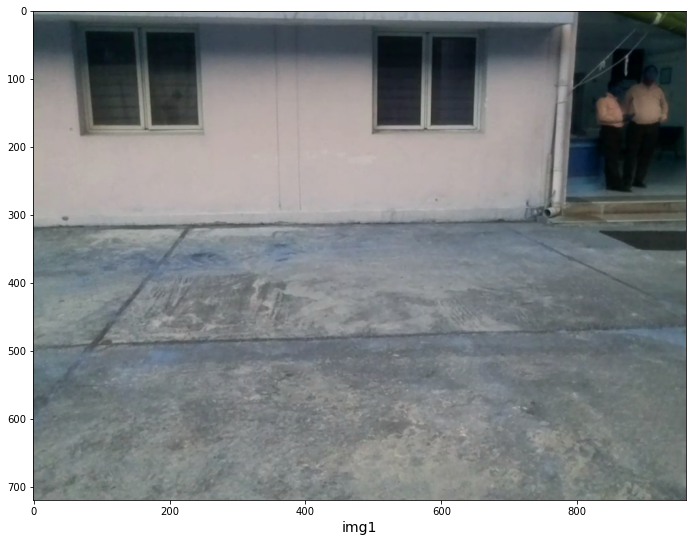

[[[464.  12.]
  [464. 200.]
  [677. 200.]
  [677.  12.]]

 [[ 66.  17.]
  [ 66. 192.]
  [261. 192.]
  [261.  17.]]]
(2, 4, 2)
[464, 12, 677, 200]
[66, 17, 261, 192]


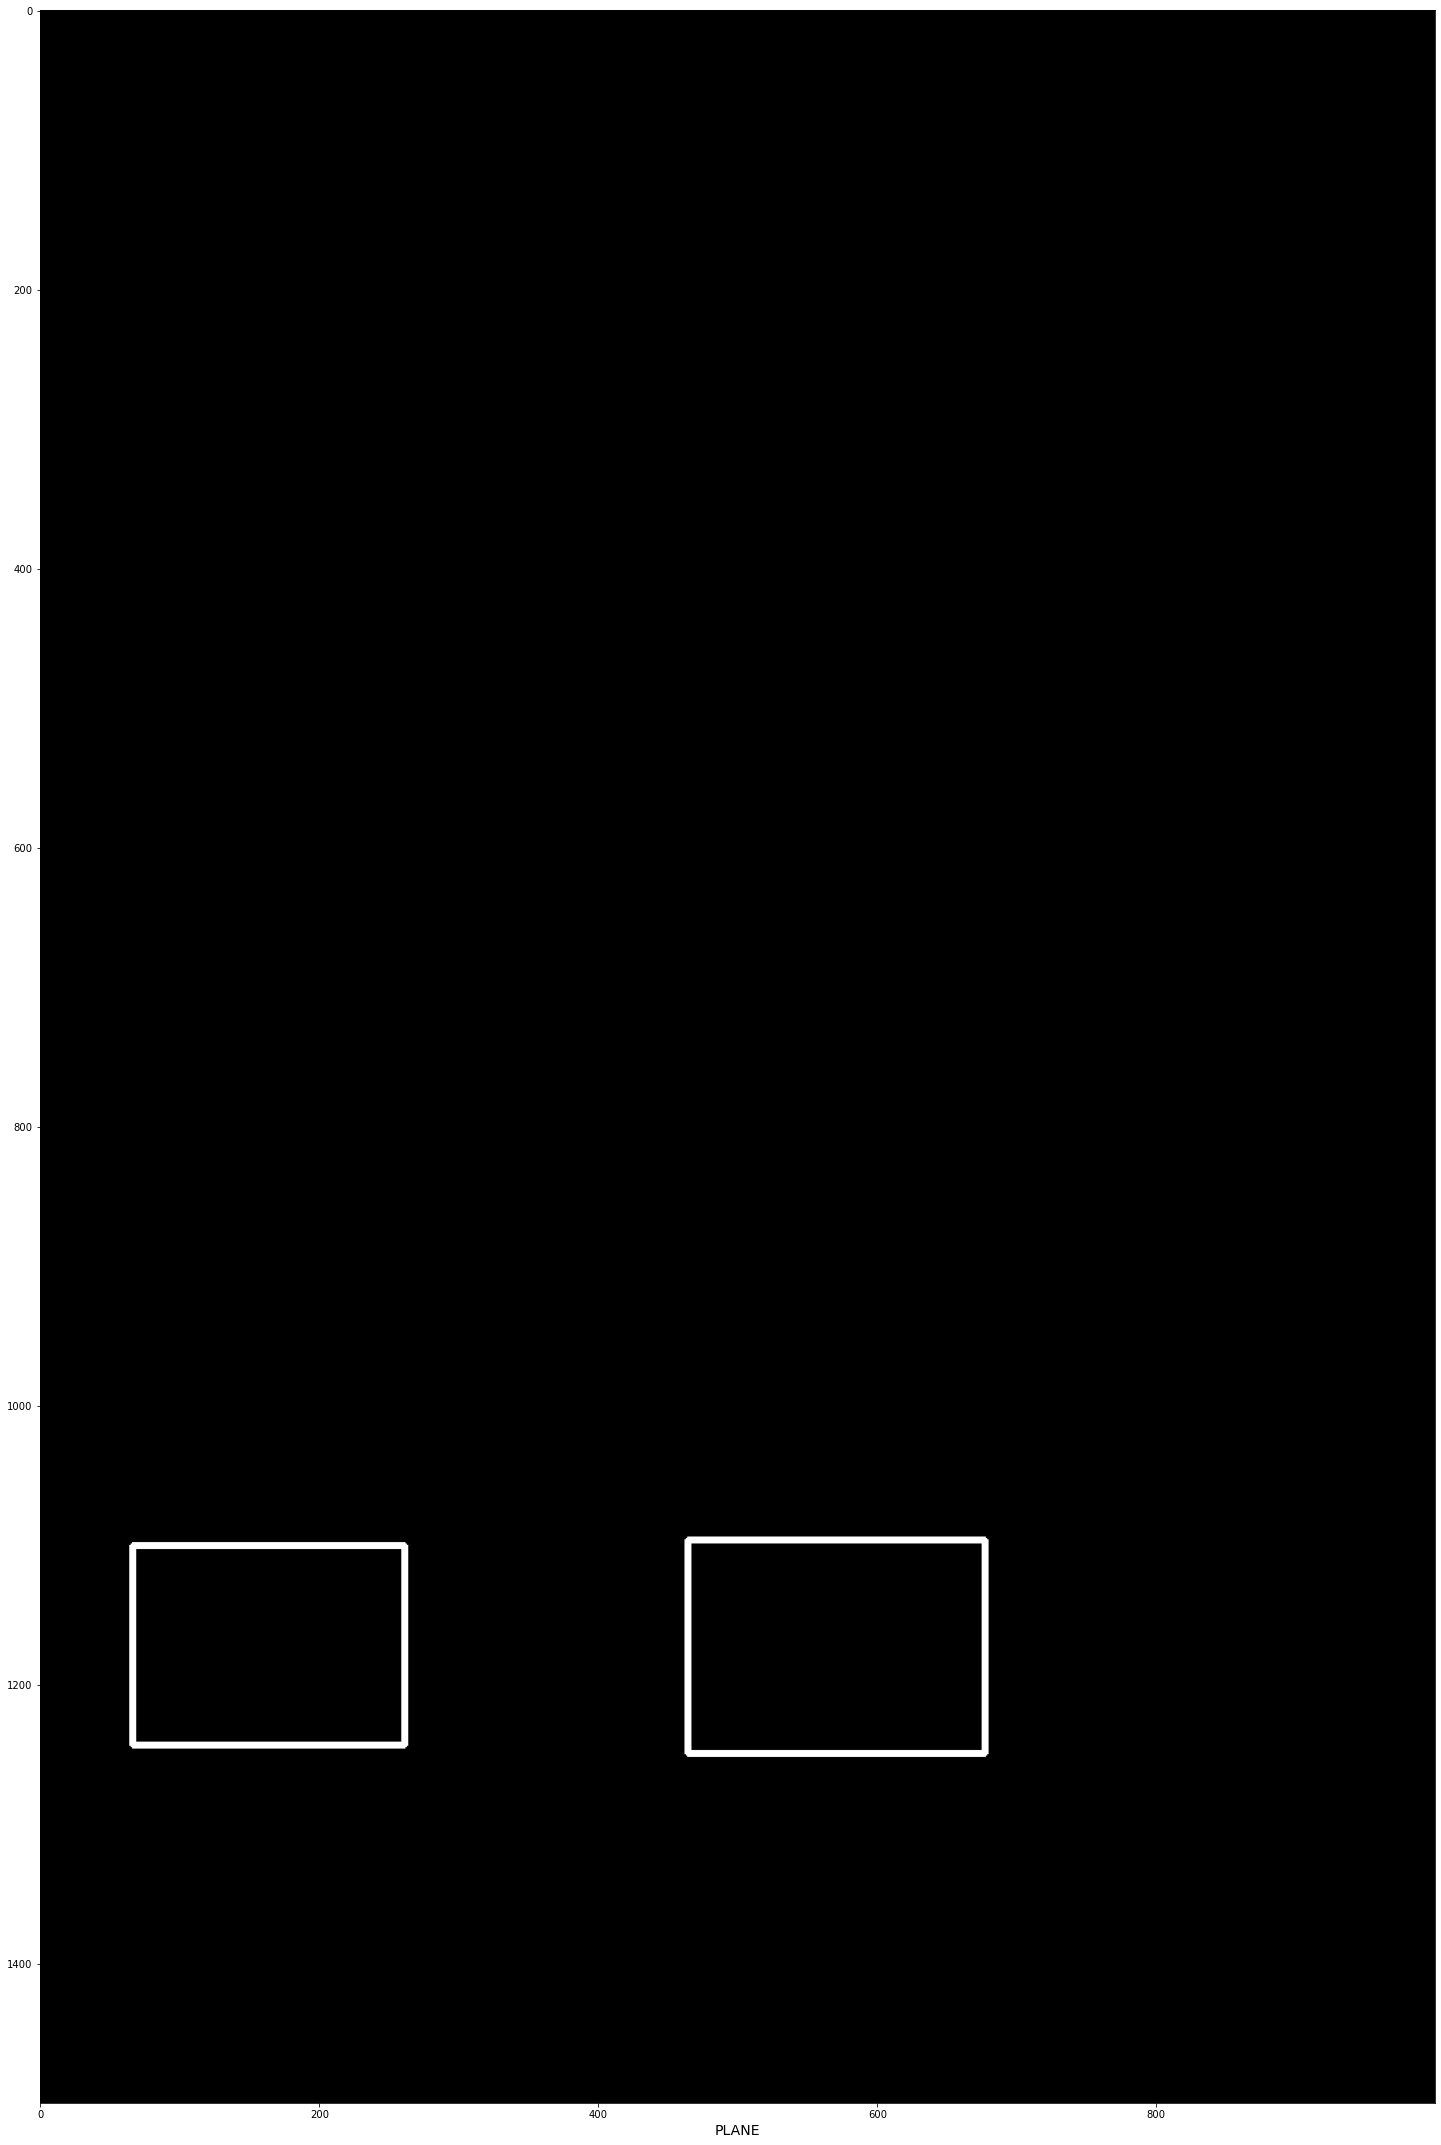

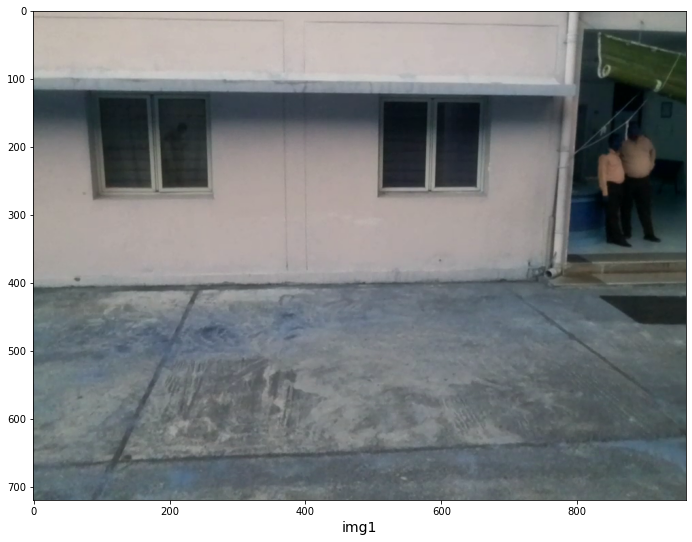

[[[480. 110.]
  [480. 290.]
  [682. 290.]
  [682. 110.]]

 [[ 88. 115.]
  [ 88. 285.]
  [278. 285.]
  [278. 115.]]]
(2, 4, 2)
[480, 110, 682, 290]
[88, 115, 278, 285]


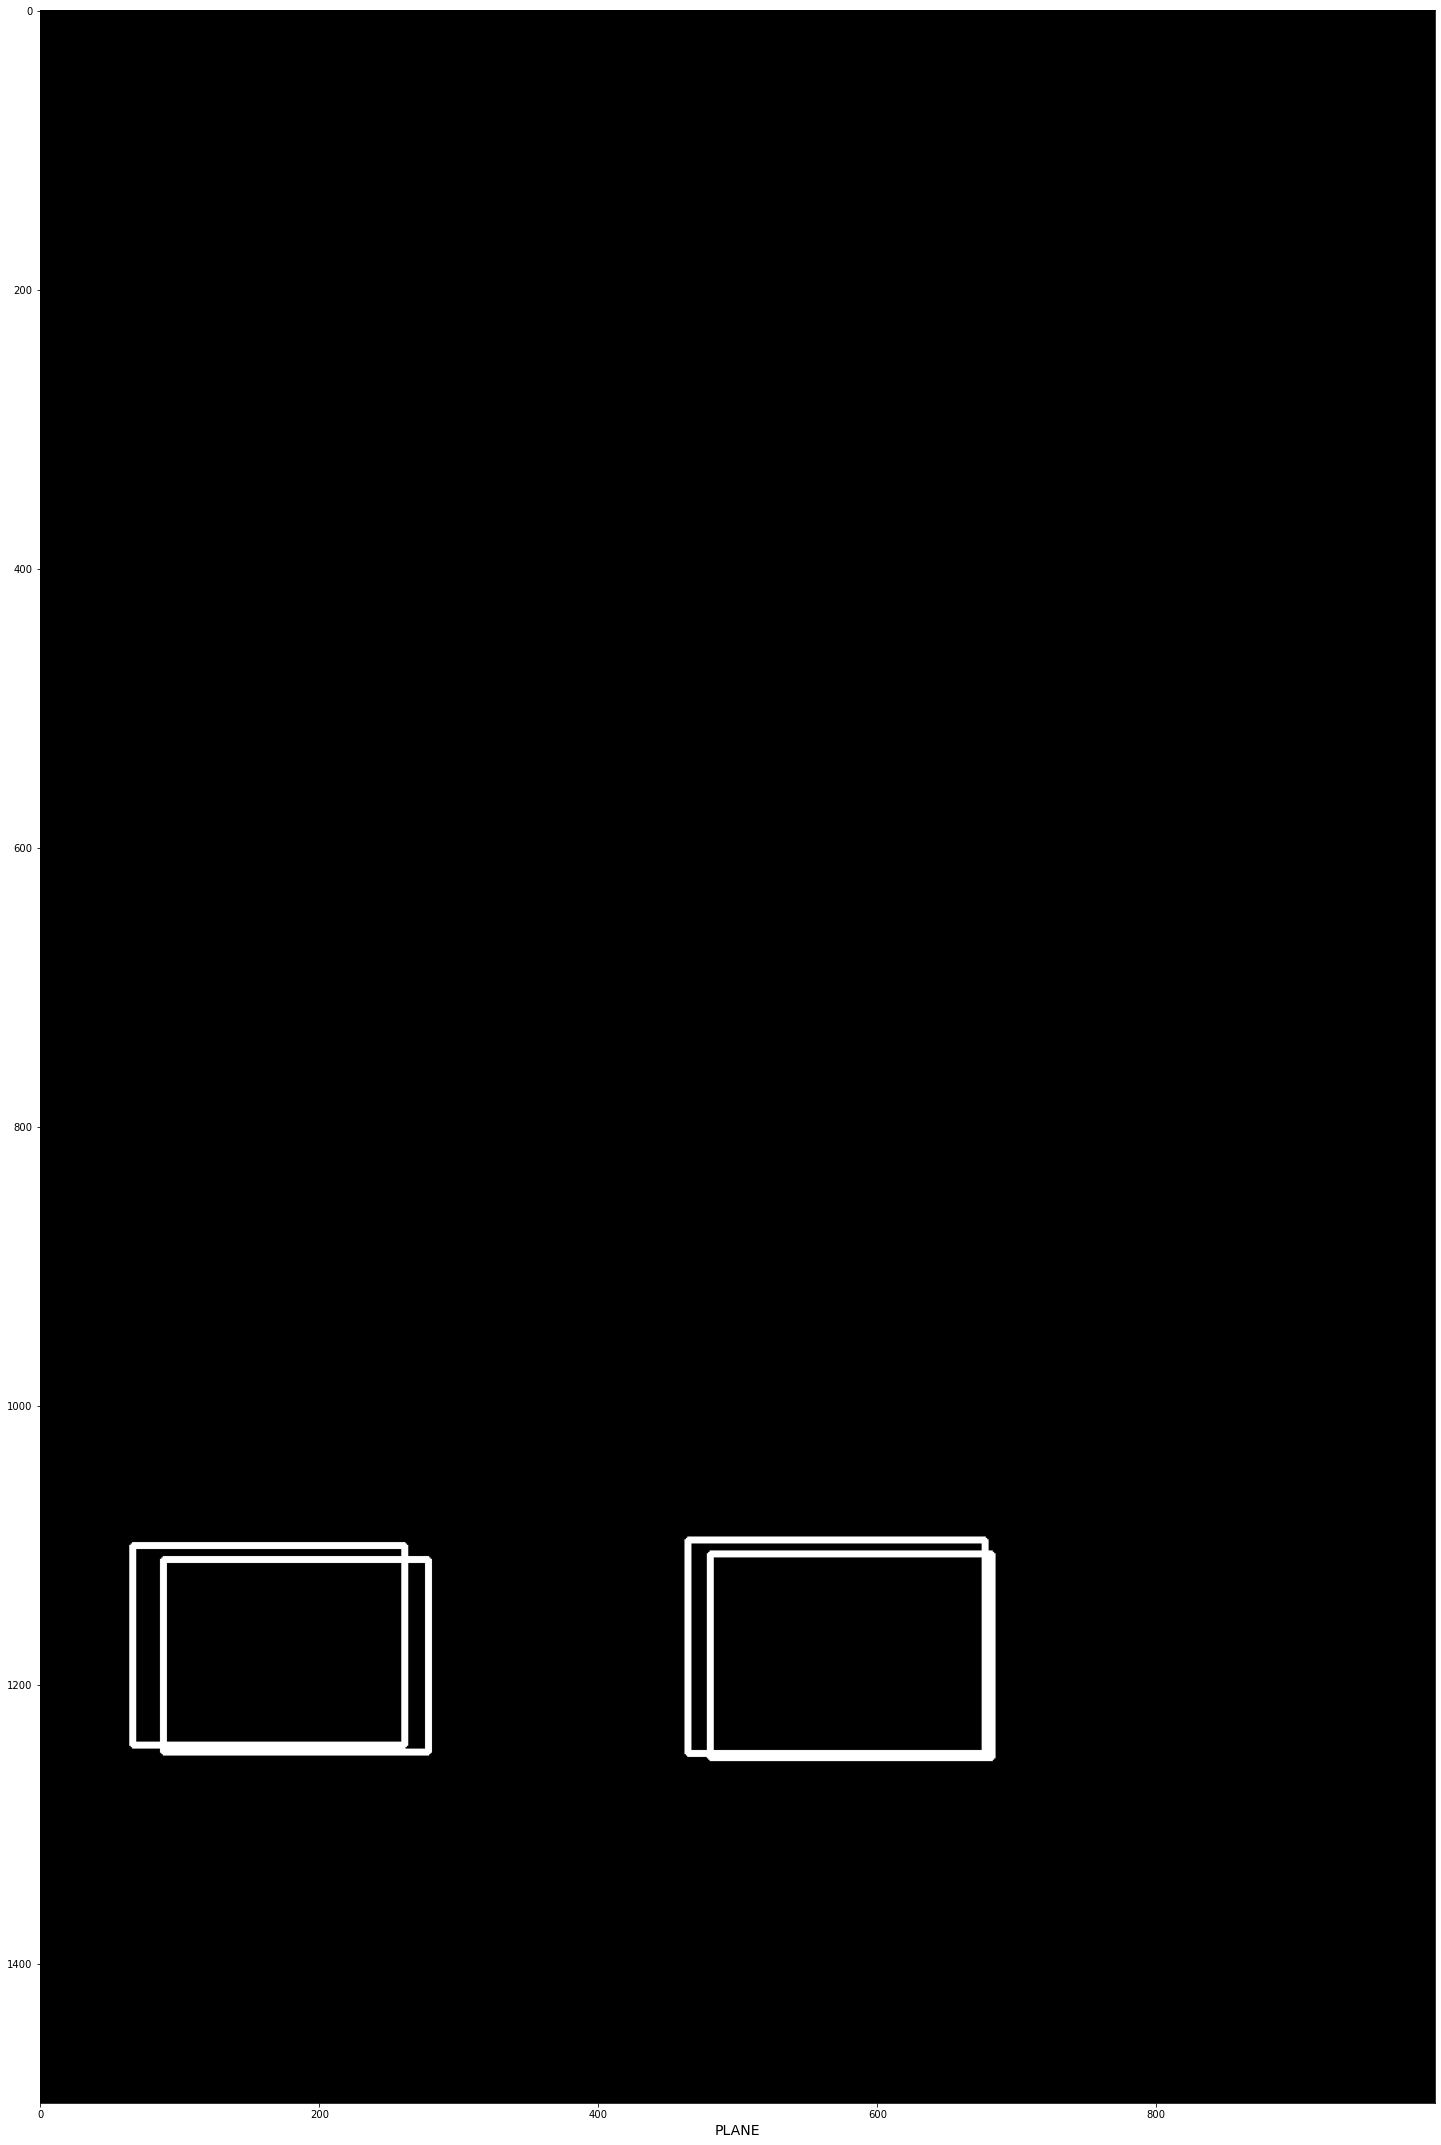

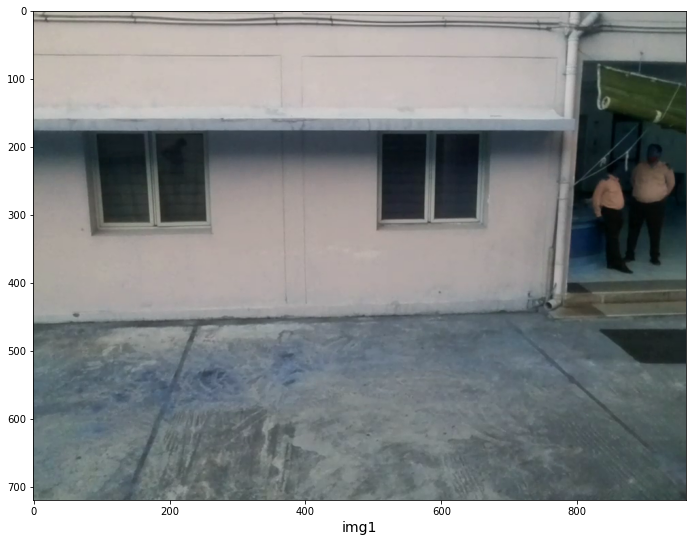

[[[479. 167.]
  [479. 337.]
  [679. 337.]
  [679. 167.]]

 [[ 81. 165.]
  [ 81. 332.]
  [268. 332.]
  [268. 165.]]]
(2, 4, 2)
[479, 167, 679, 337]
[81, 165, 268, 332]


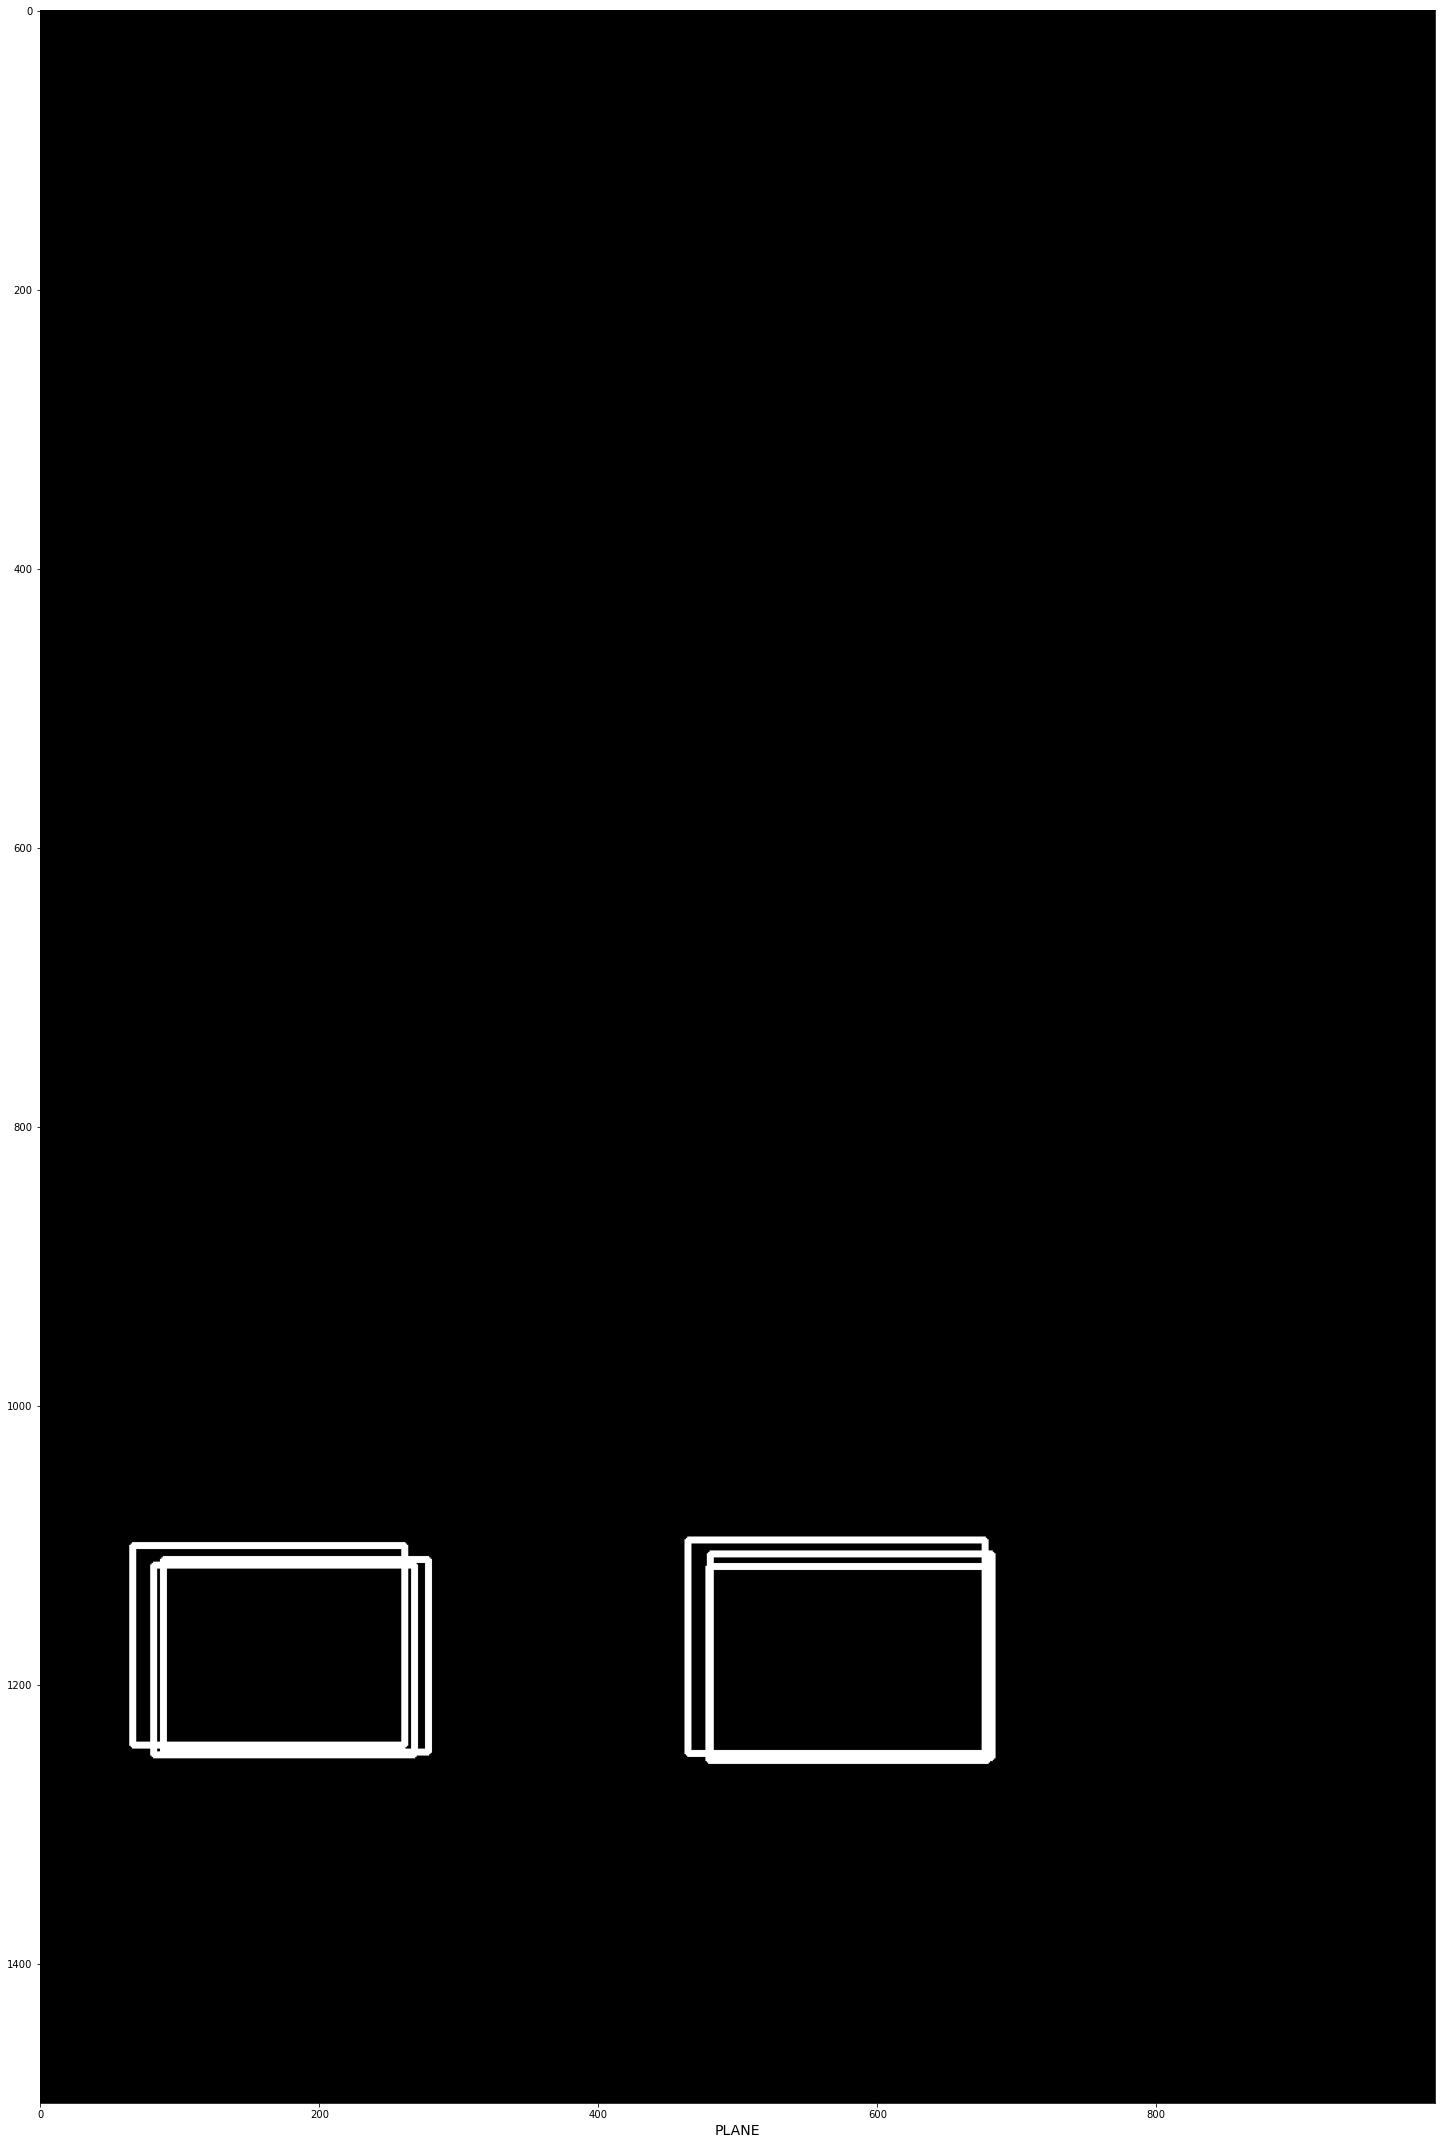

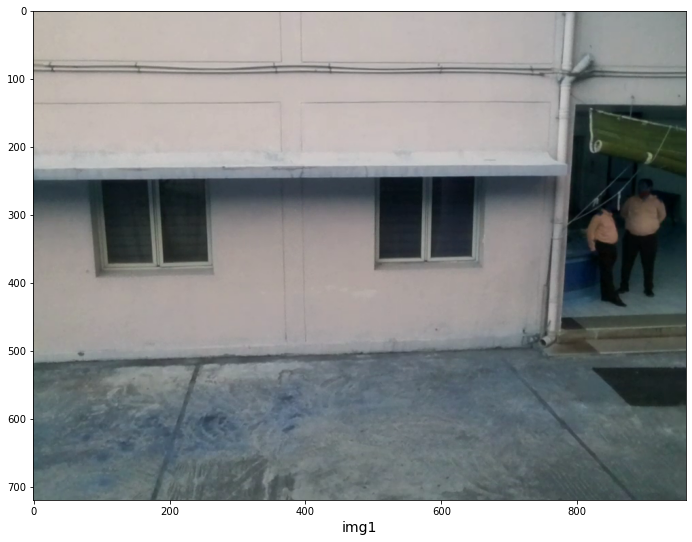

[[[472. 240.]
  [472. 400.]
  [672. 400.]
  [672. 240.]]

 [[ 87. 257.]
  [ 87. 380.]
  [257. 380.]
  [257. 257.]]]
(2, 4, 2)
[472, 240, 672, 400]
[87, 257, 257, 380]


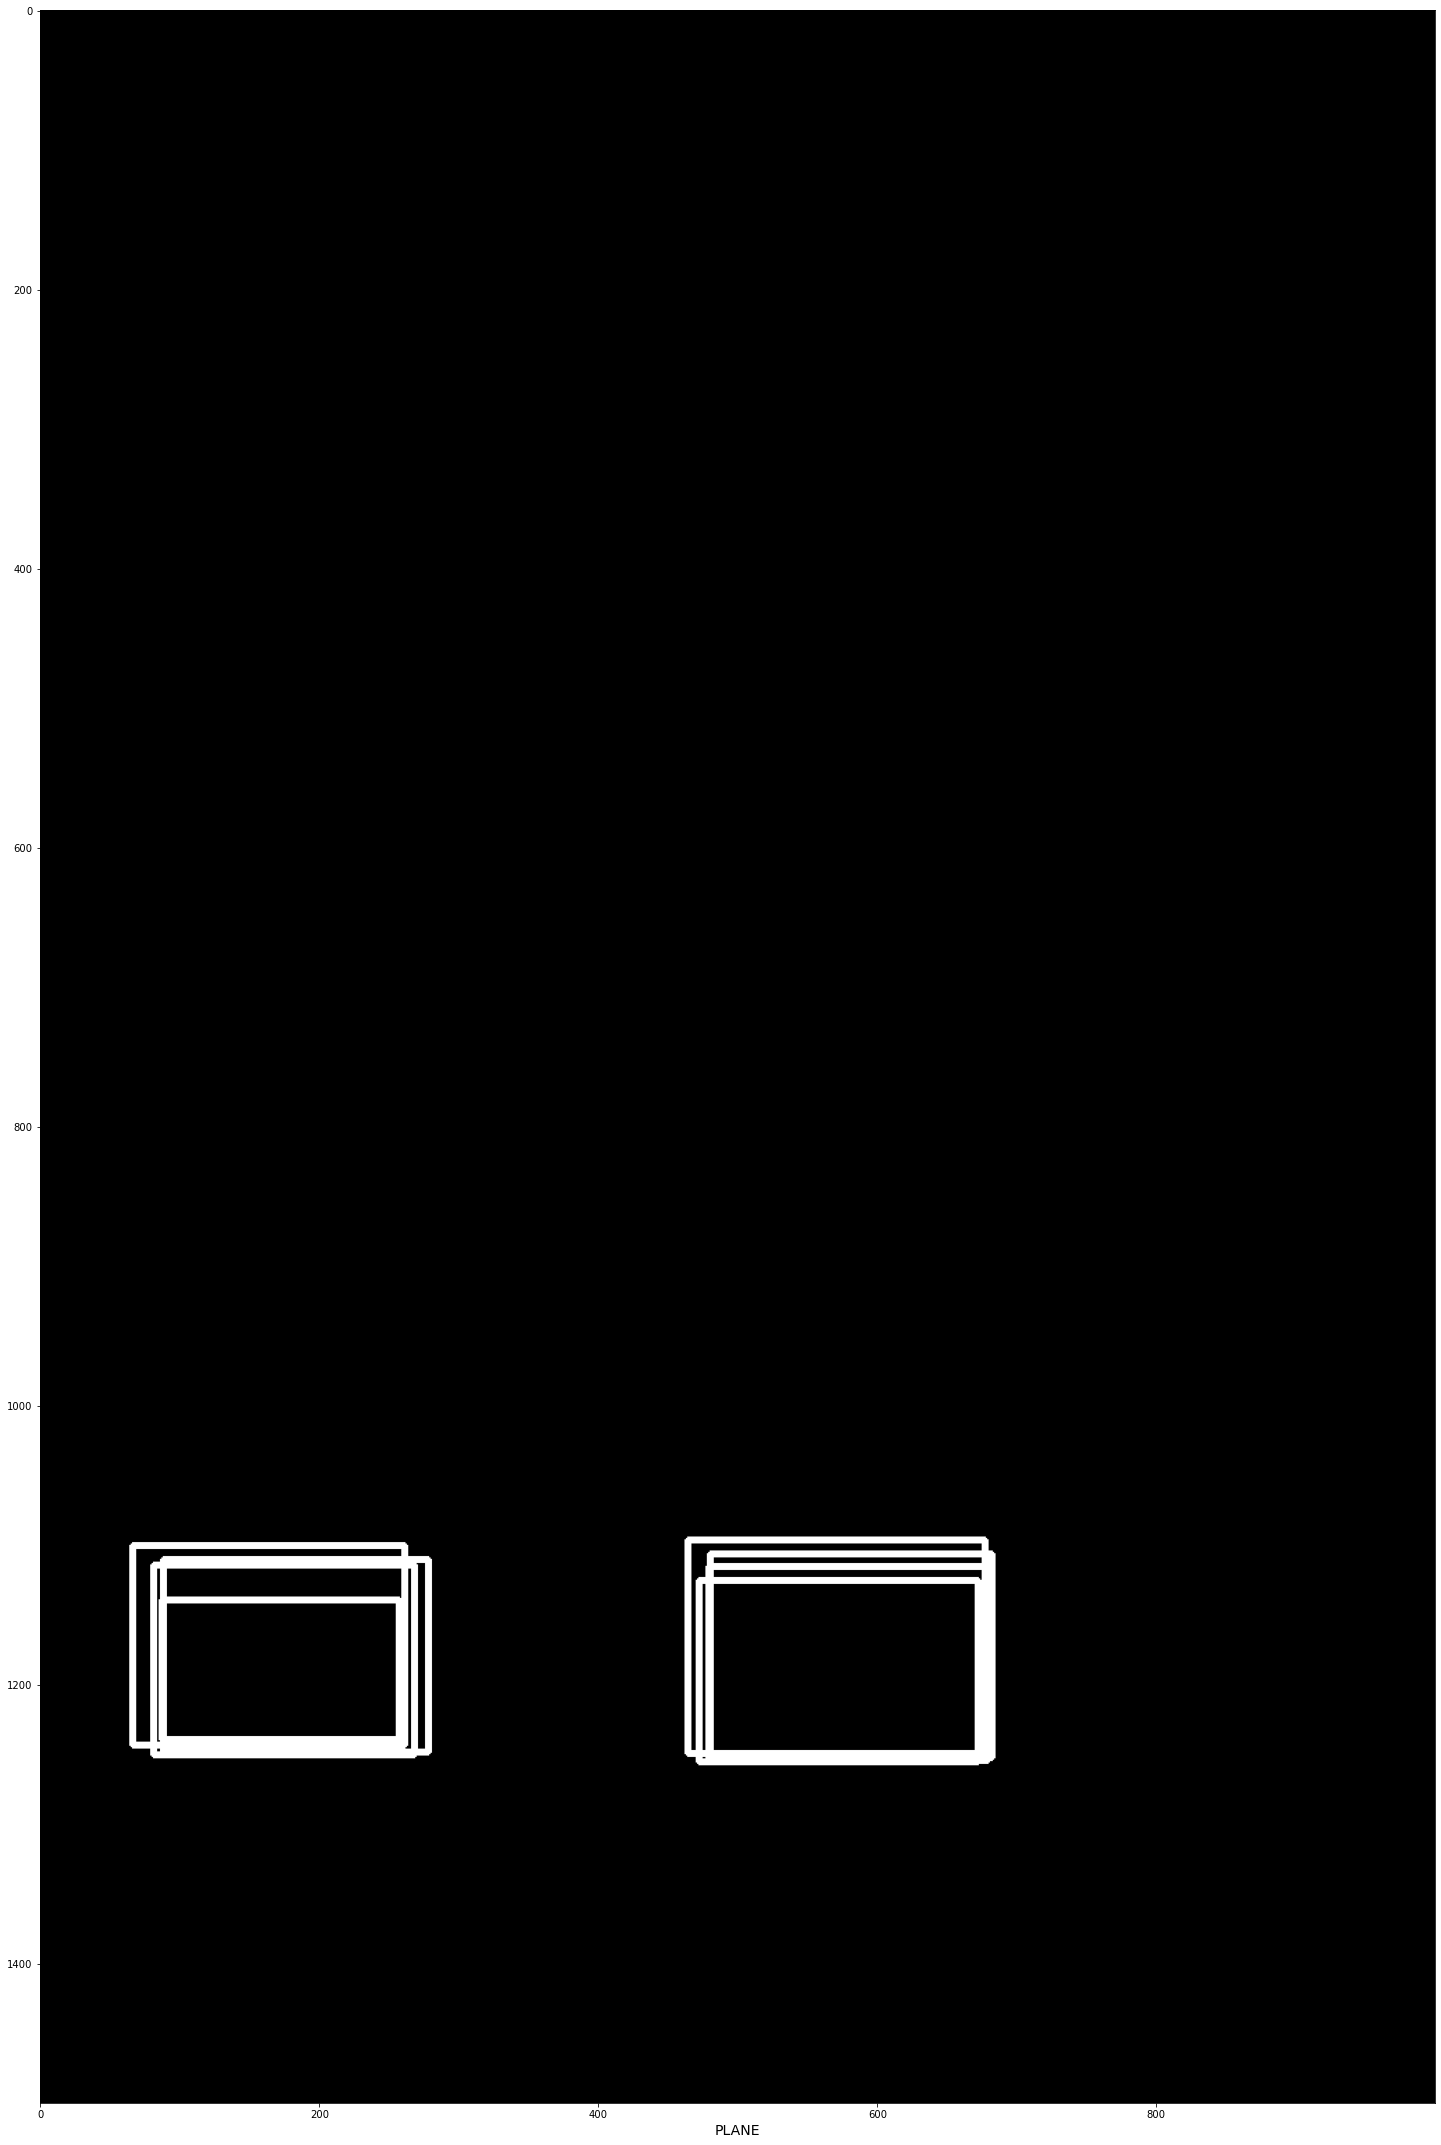

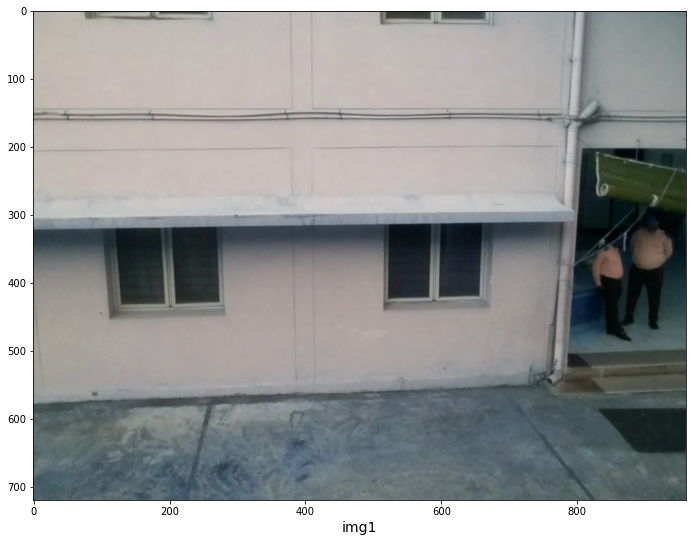

[[[485. 307.]
  [485. 460.]
  [683. 460.]
  [683. 307.]]

 [[107. 327.]
  [107. 440.]
  [275. 440.]
  [275. 327.]]]
(2, 4, 2)
[485, 307, 683, 460]
[107, 327, 275, 440]


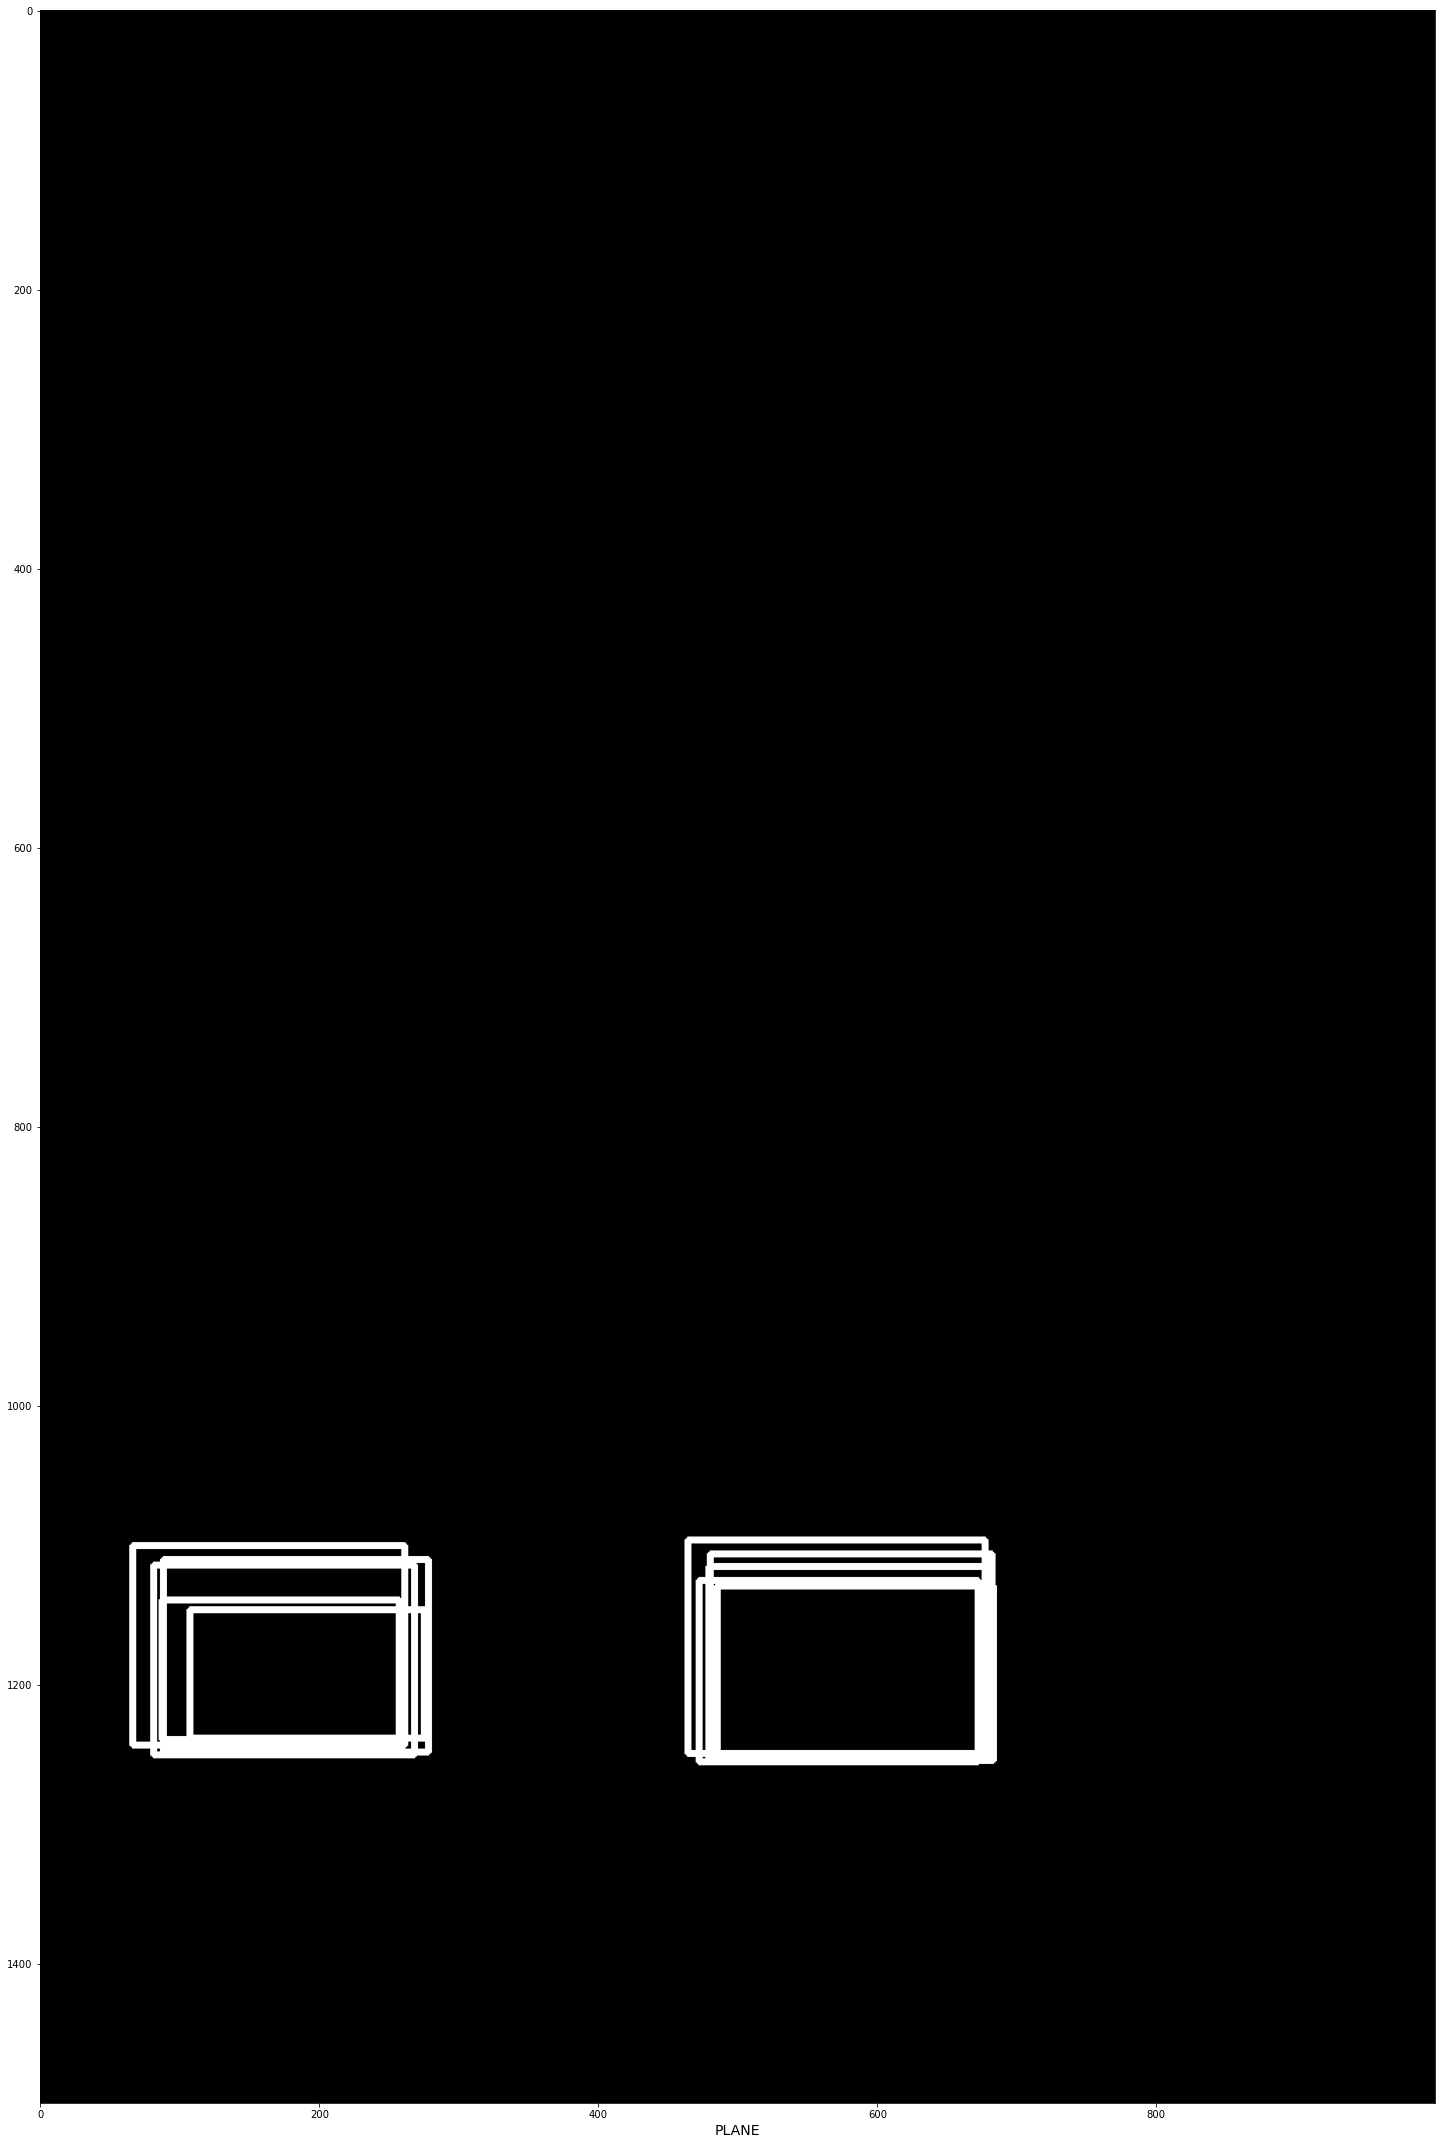

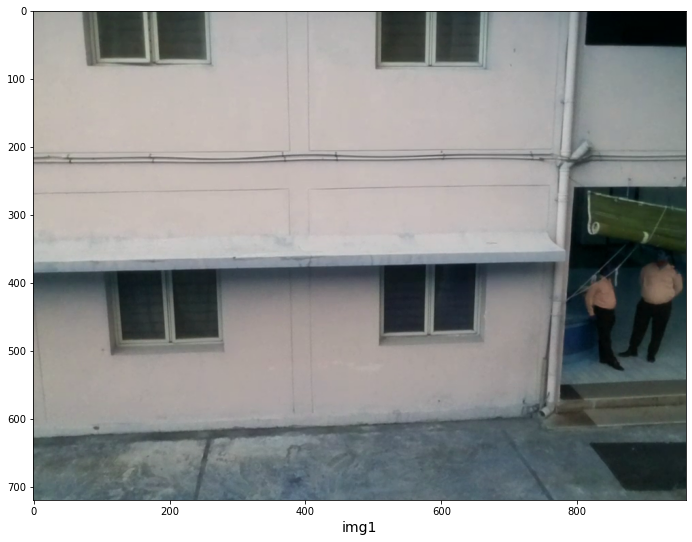

[[[112. 390.]
  [112. 490.]
  [275. 490.]
  [275. 390.]]

 [[510. 382.]
  [510. 480.]
  [655. 480.]
  [655. 382.]]

 [[ 75.   0.]
  [ 75. 100.]
  [265. 100.]
  [265.   0.]]

 [[472.   0.]
  [472.  97.]
  [687.  97.]
  [687.   0.]]]
(4, 4, 2)
[112, 390, 275, 490]
[510, 382, 655, 480]
[75, 0, 265, 100]
[472, 0, 687, 97]


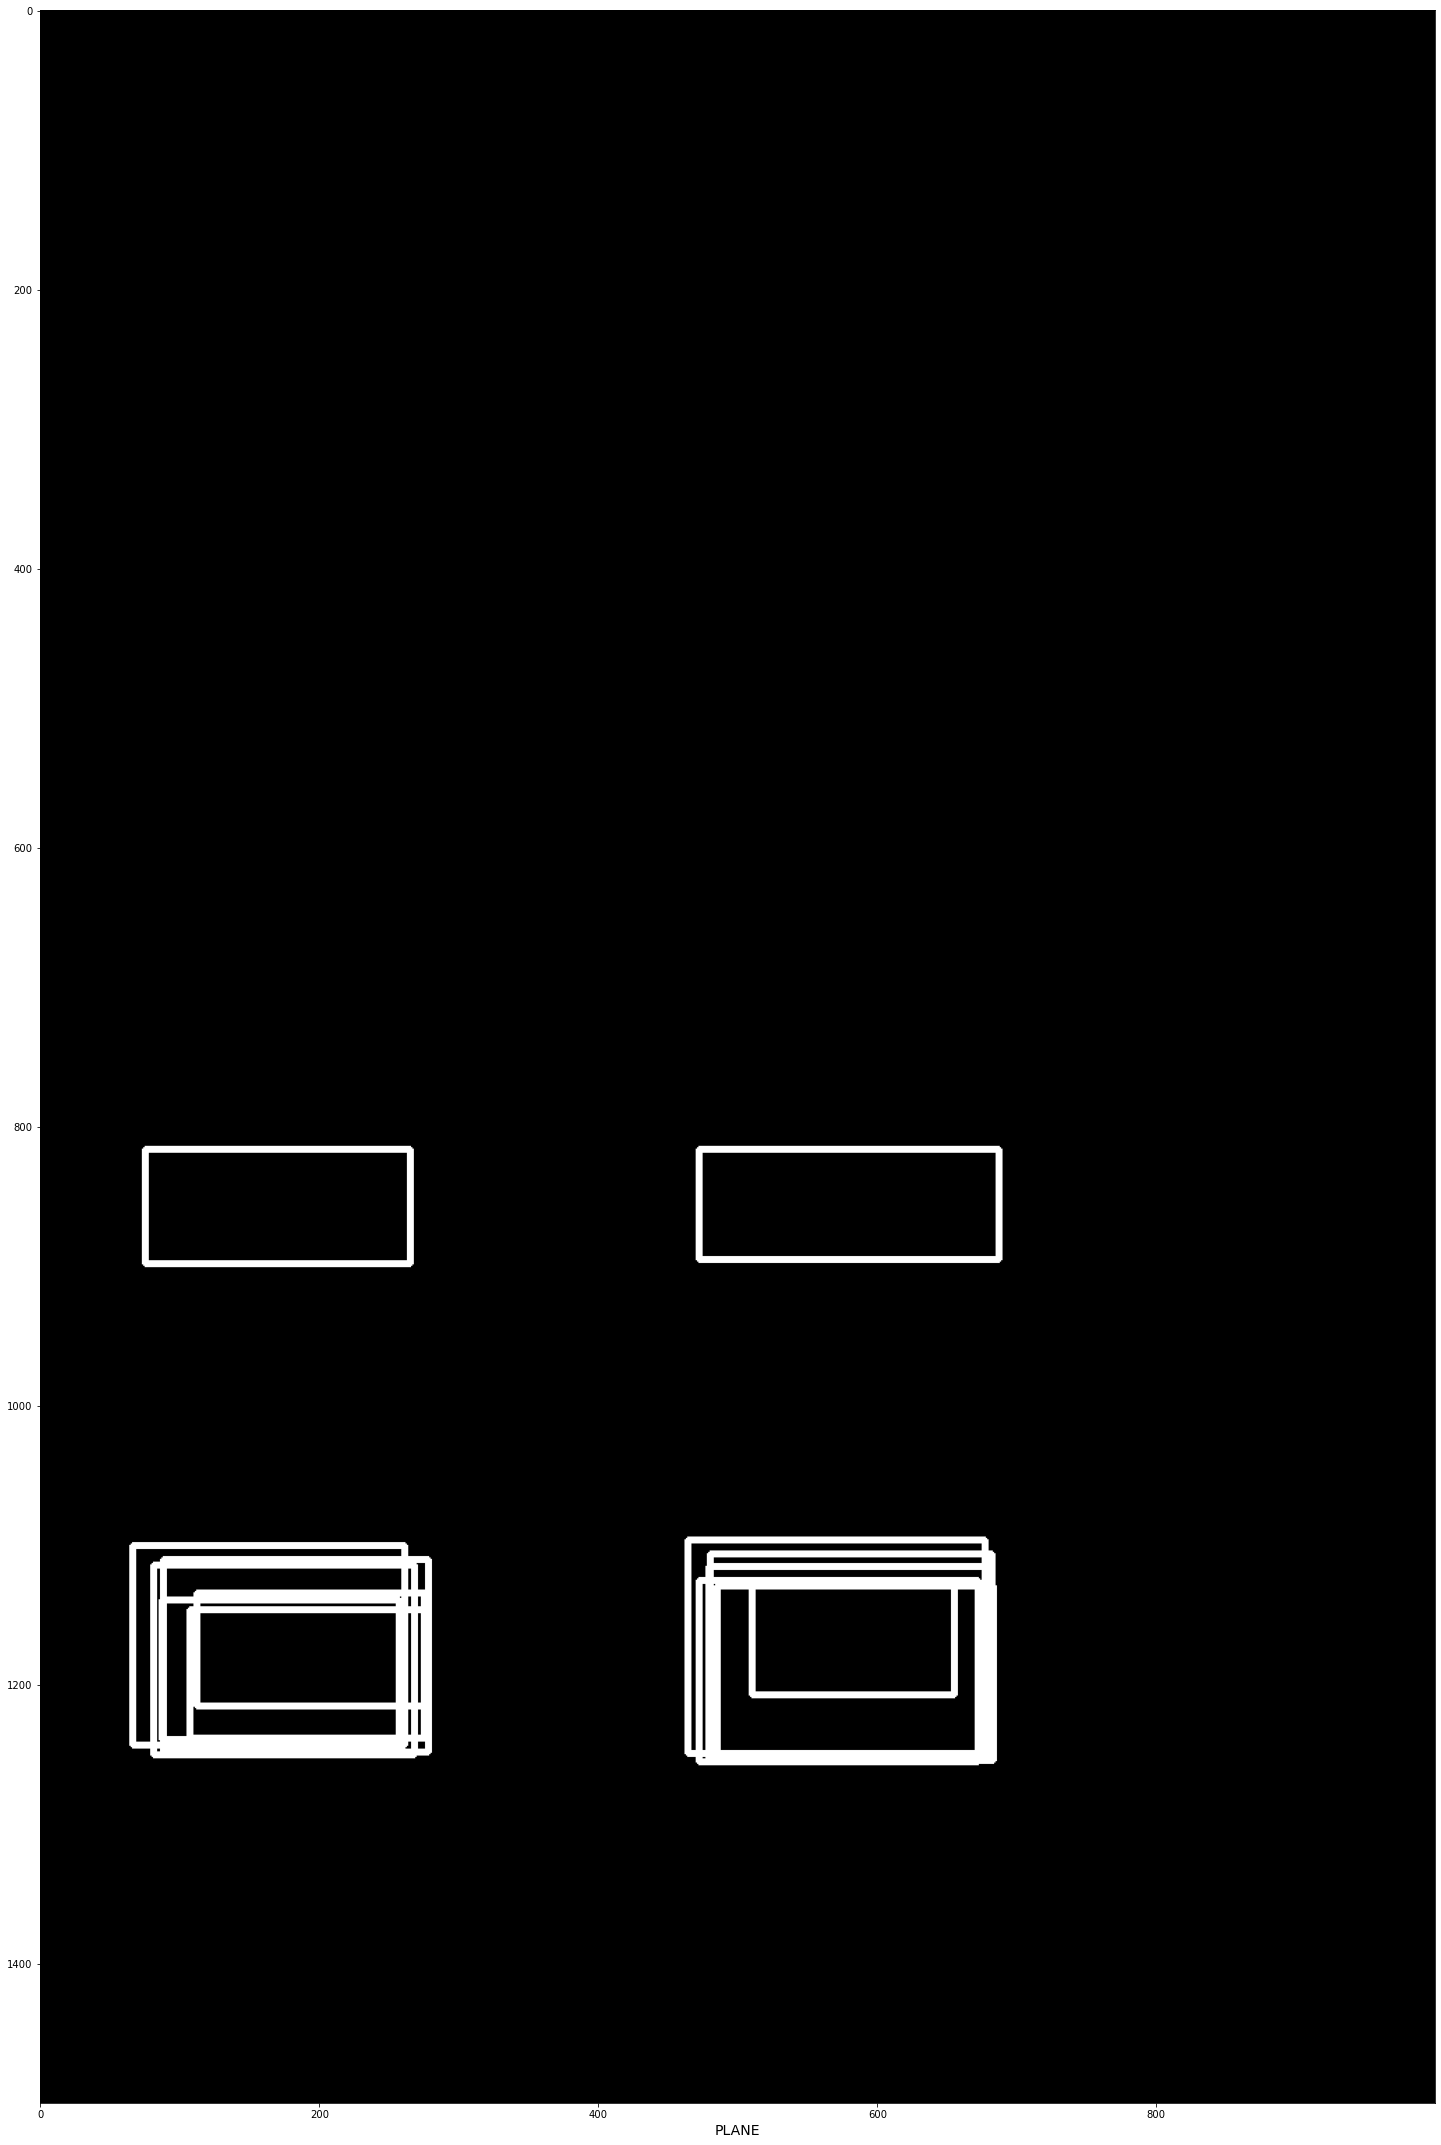

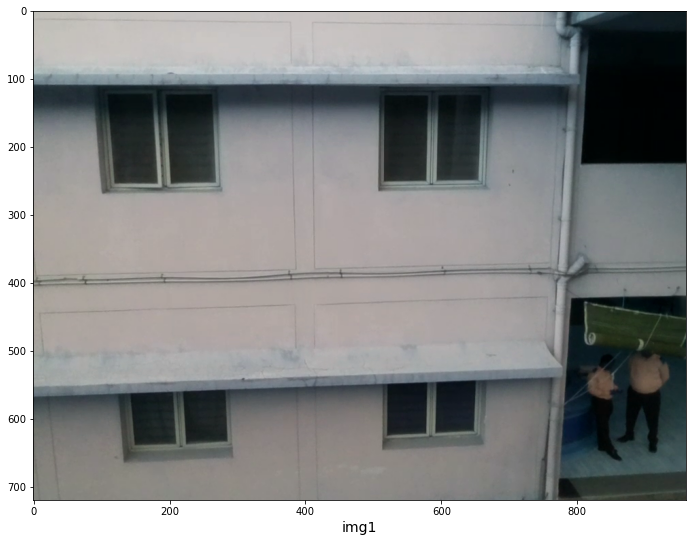

[[[132. 570.]
  [132. 650.]
  [287. 650.]
  [287. 570.]]

 [[515. 552.]
  [515. 632.]
  [655. 632.]
  [655. 552.]]

 [[481. 102.]
  [481. 285.]
  [686. 285.]
  [686. 102.]]

 [[ 93. 102.]
  [ 93. 277.]
  [286. 277.]
  [286. 102.]]]
(4, 4, 2)
[132, 570, 287, 650]
[515, 552, 655, 632]
[481, 102, 686, 285]
[93, 102, 286, 277]


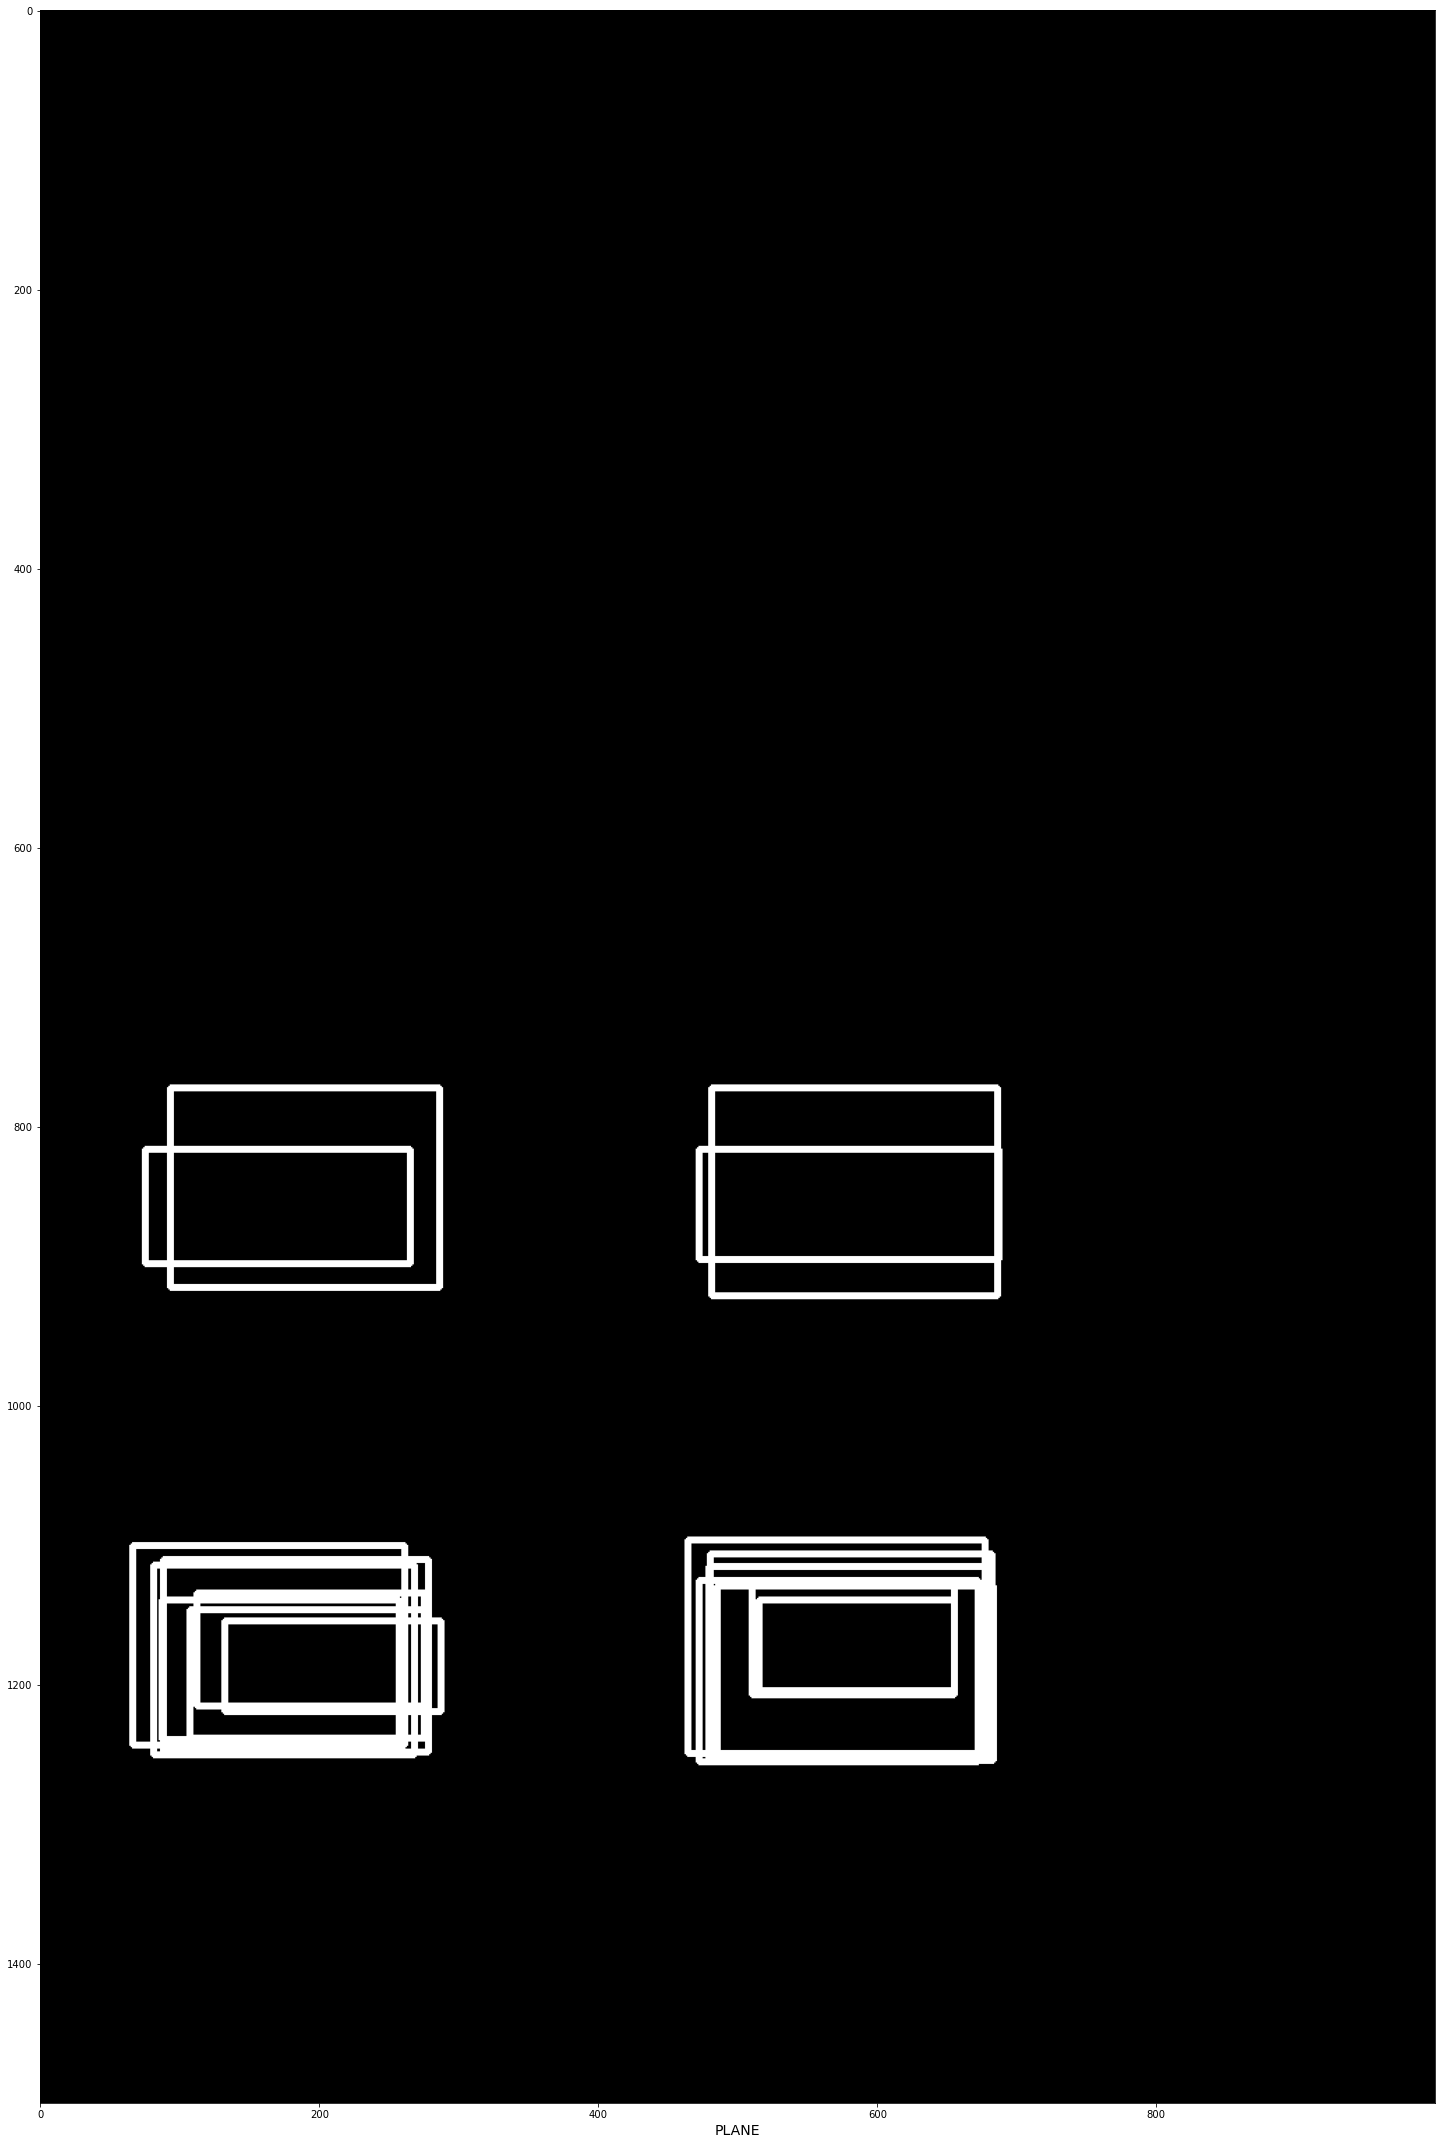

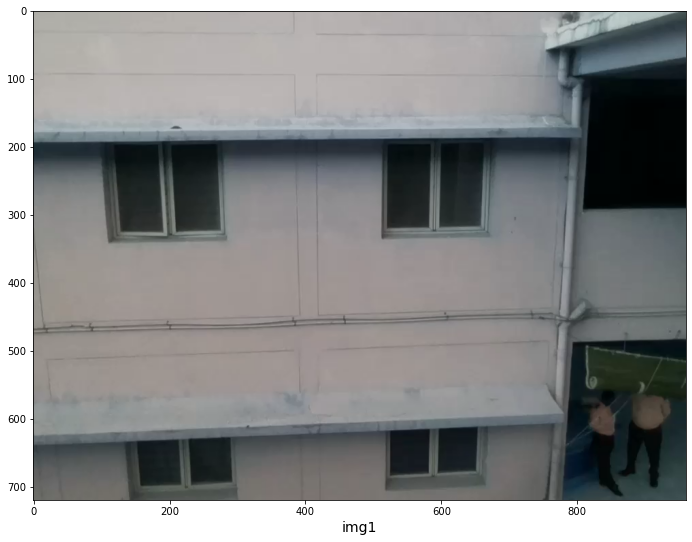

[[[142. 637.]
  [142. 710.]
  [295. 710.]
  [295. 637.]]

 [[517. 622.]
  [517. 690.]
  [657. 690.]
  [657. 622.]]

 [[482. 185.]
  [482. 352.]
  [687. 352.]
  [687. 185.]]

 [[105. 205.]
  [105. 332.]
  [280. 332.]
  [280. 205.]]]
(4, 4, 2)
[142, 637, 295, 710]
[517, 622, 657, 690]
[482, 185, 687, 352]
[105, 205, 280, 332]


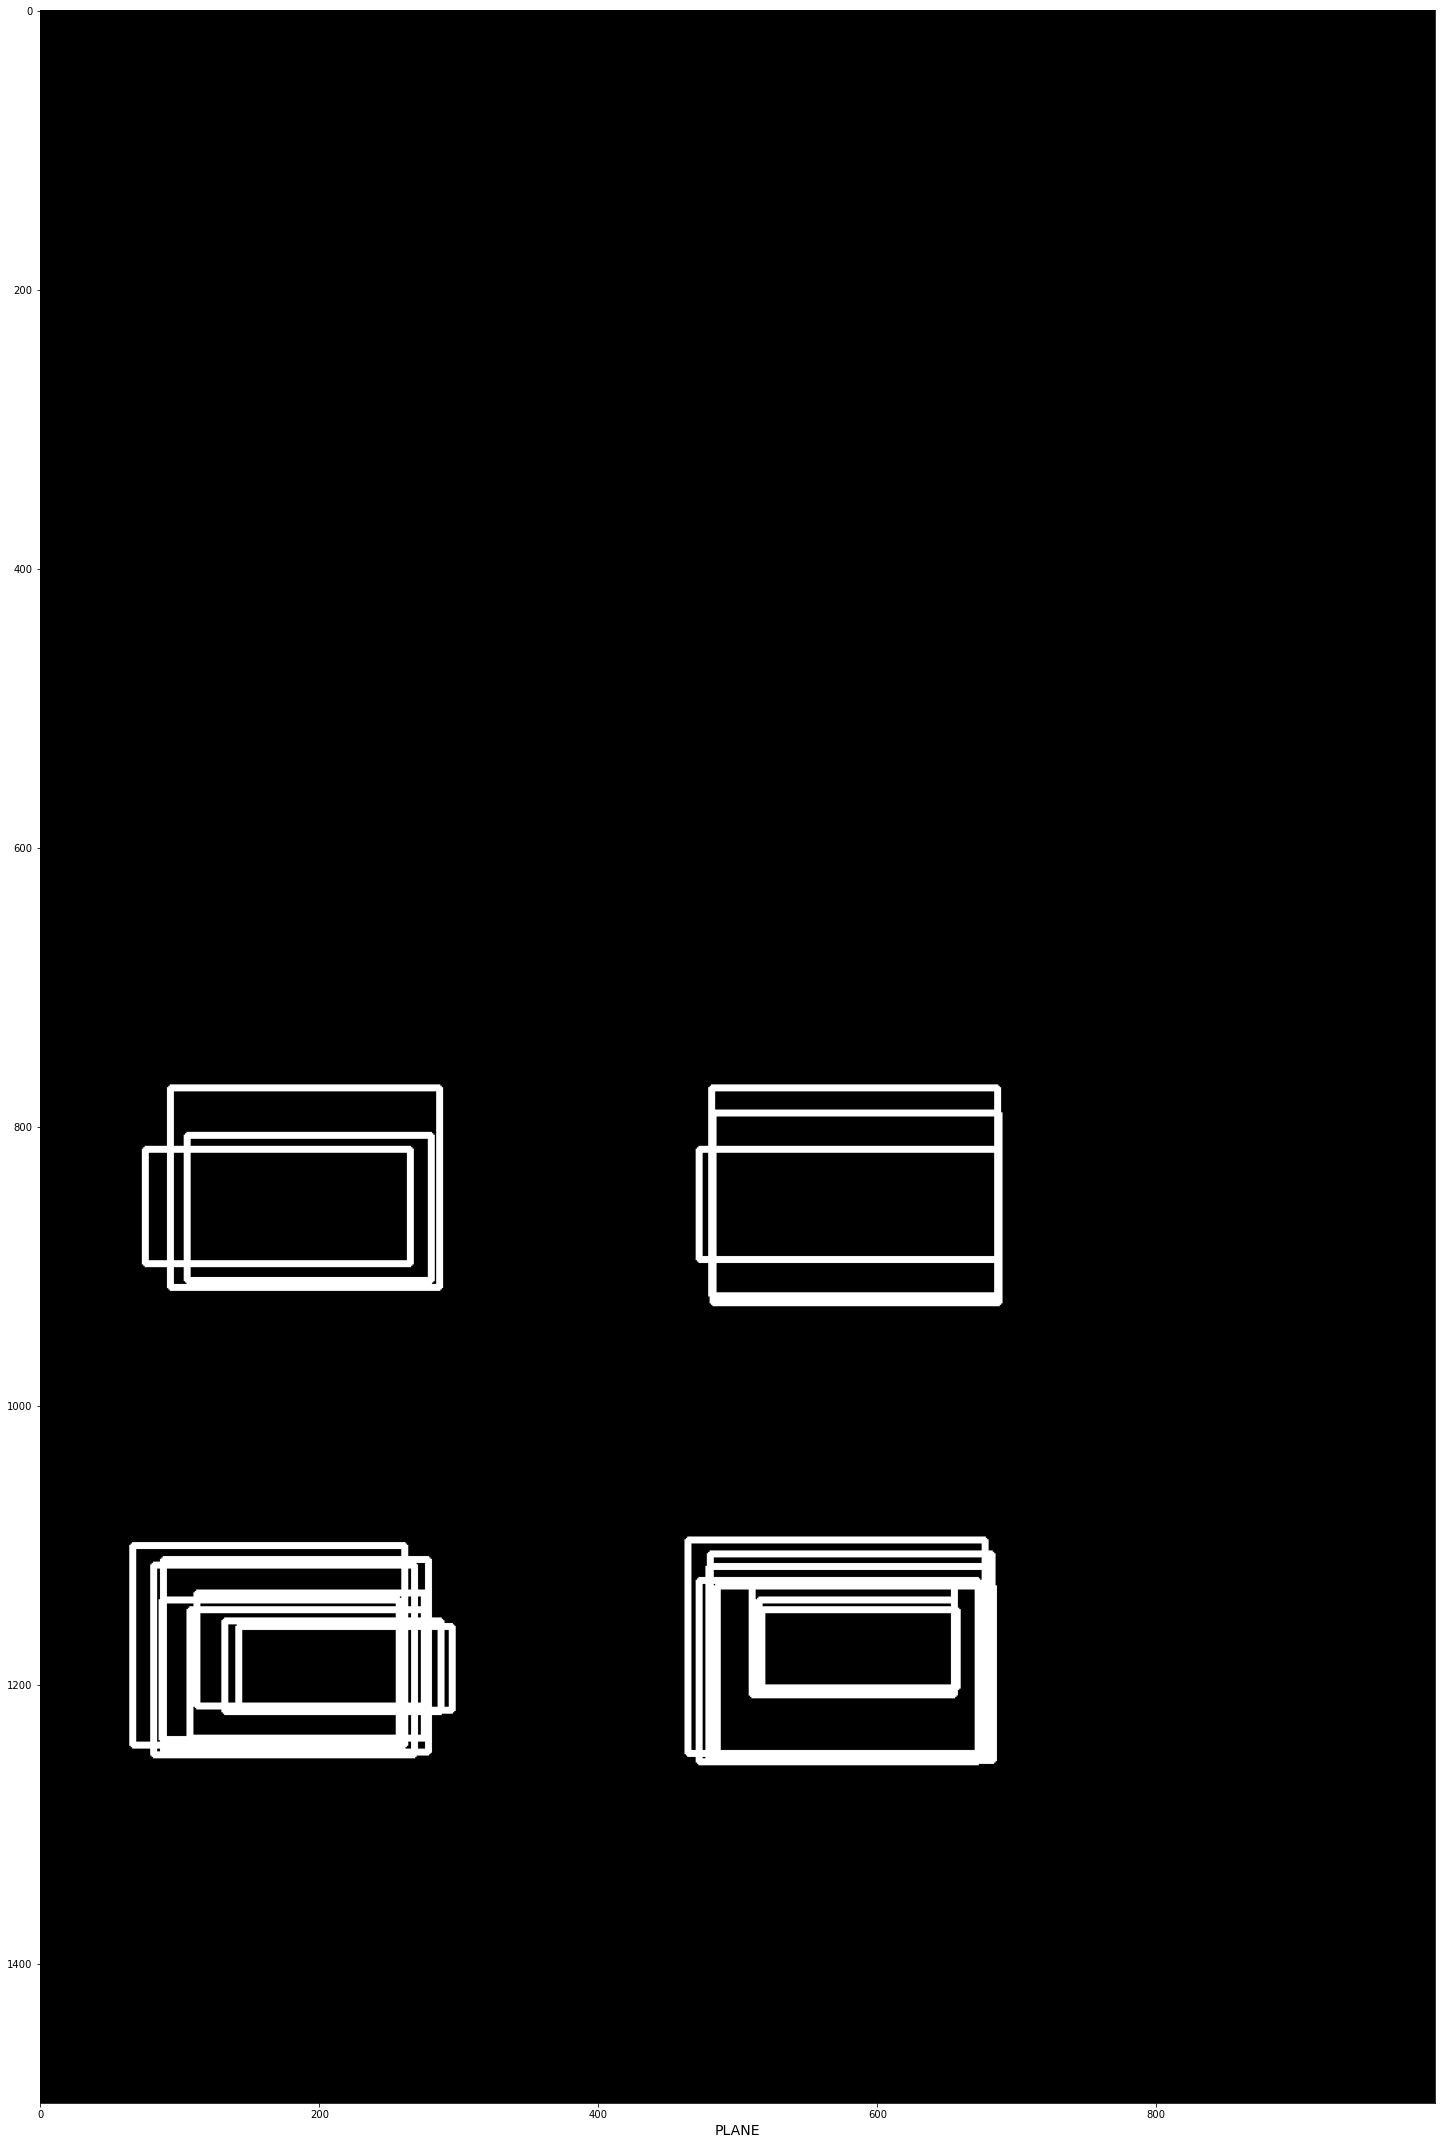

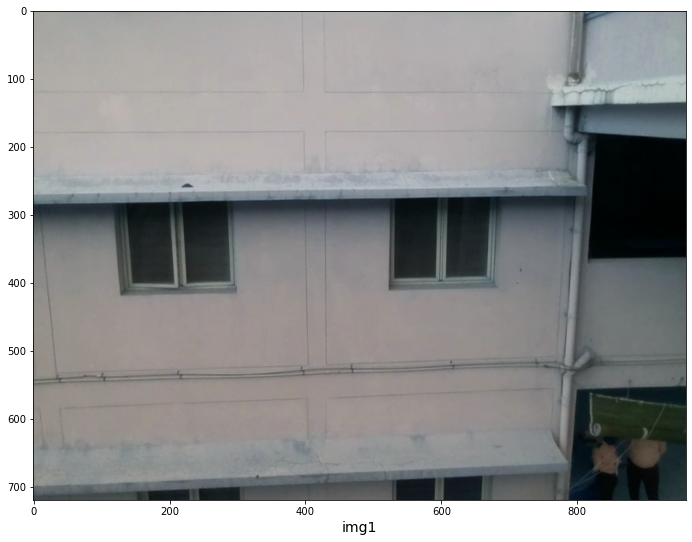

[[[122. 292.]
  [122. 407.]
  [292. 407.]
  [292. 292.]]

 [[527. 282.]
  [527. 402.]
  [672. 402.]
  [672. 282.]]]
(2, 4, 2)
[122, 292, 292, 407]
[527, 282, 672, 402]


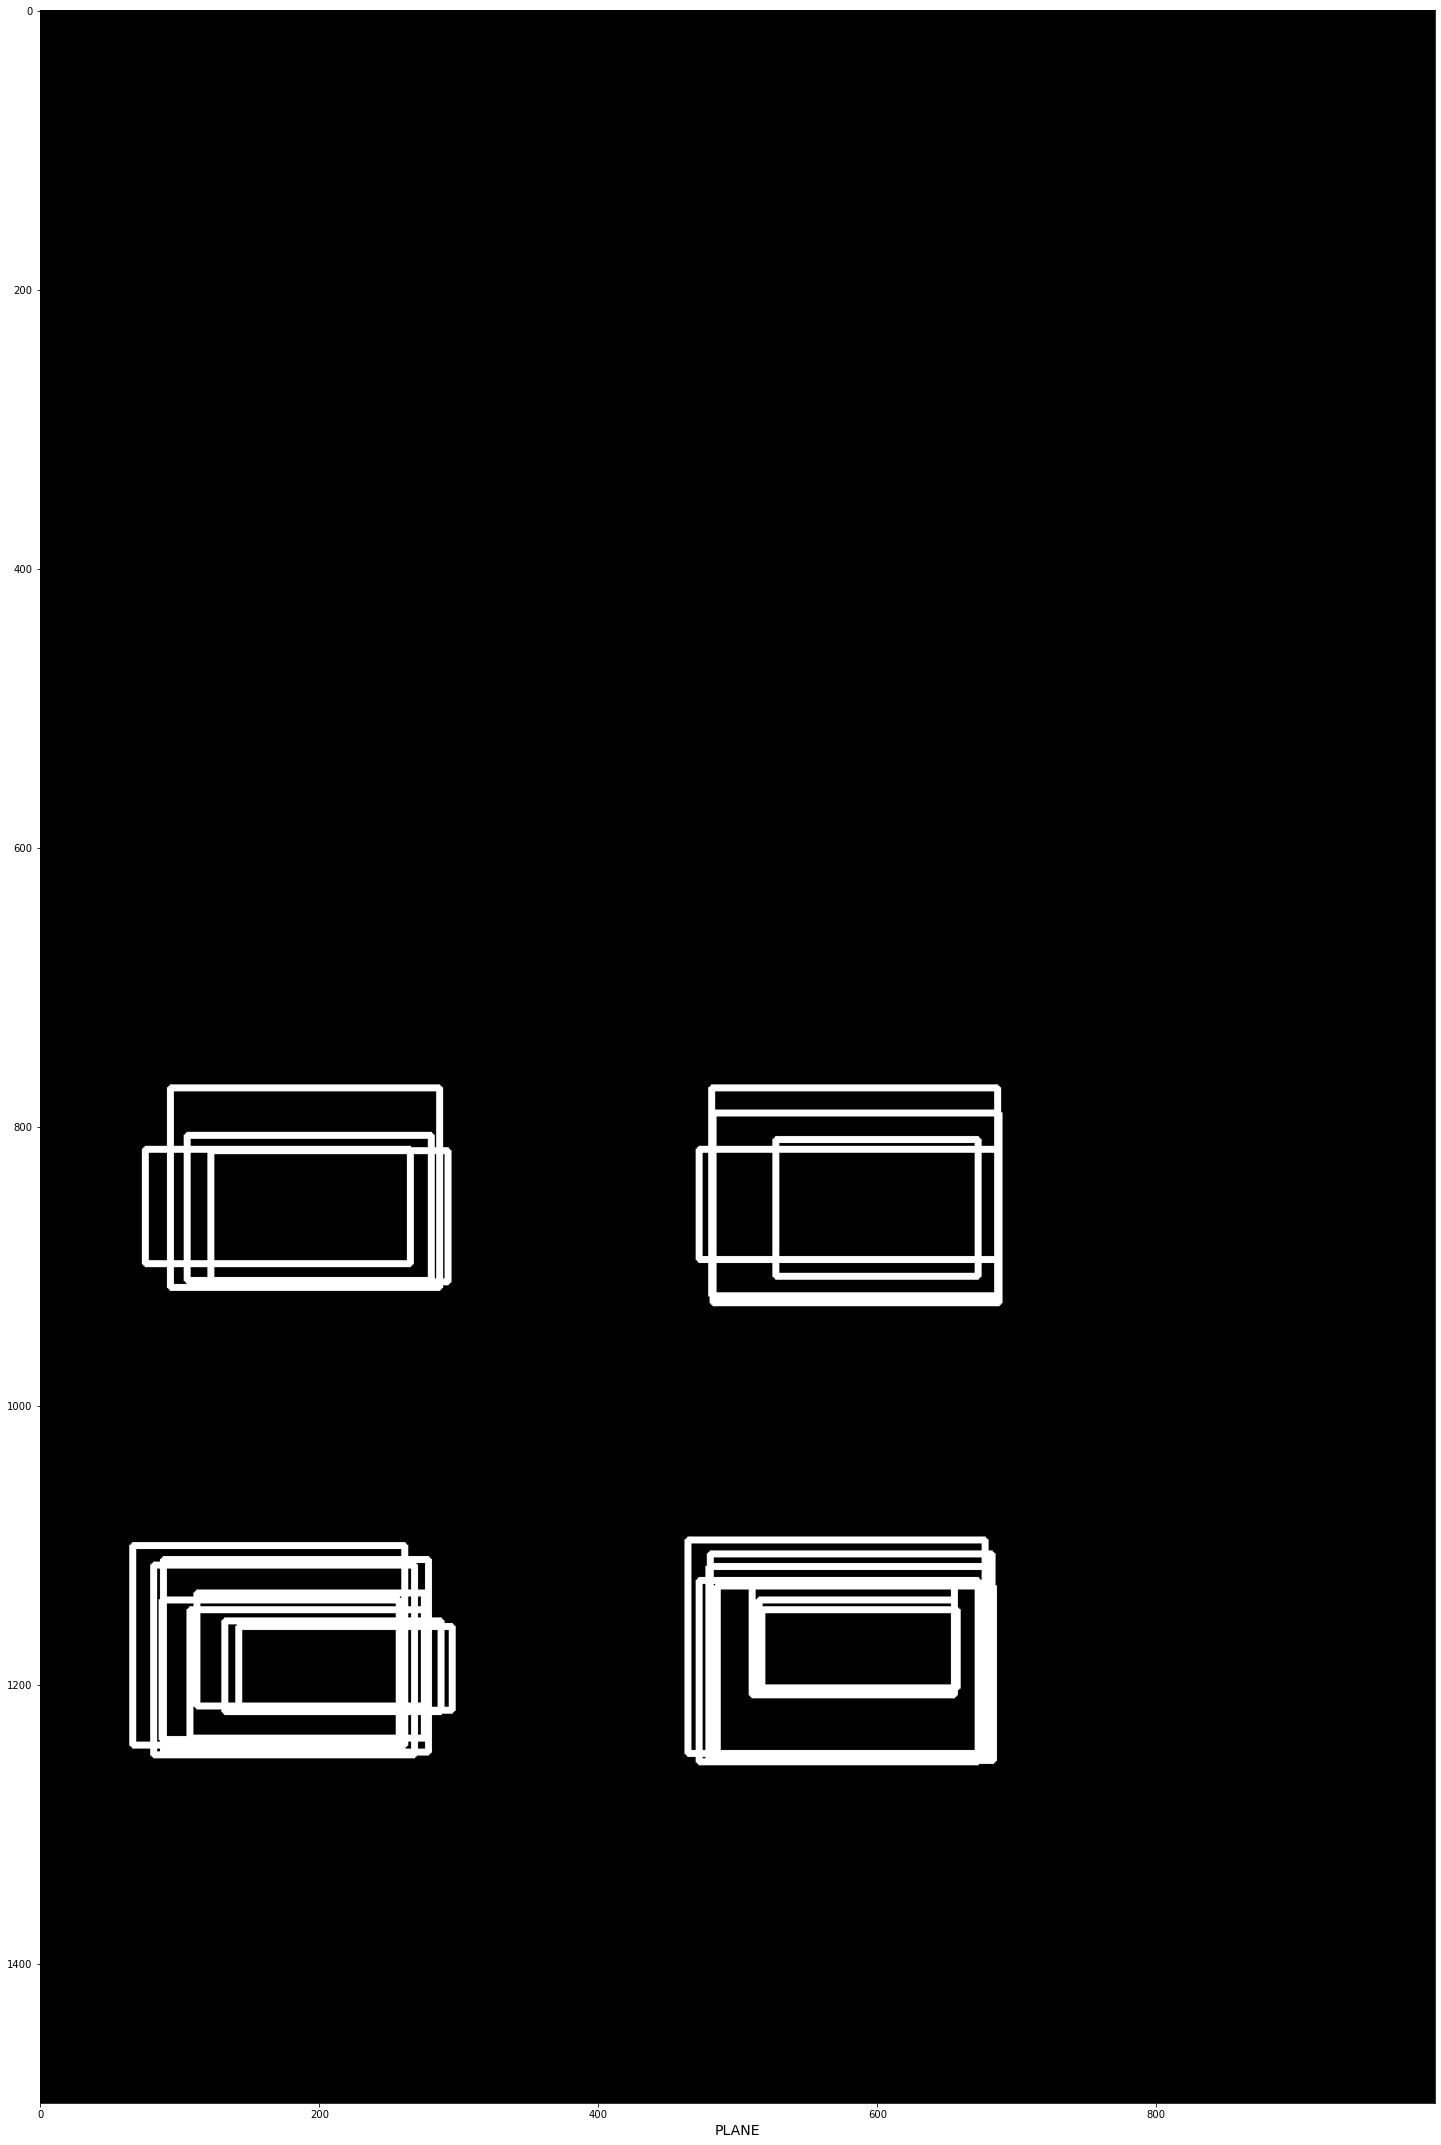

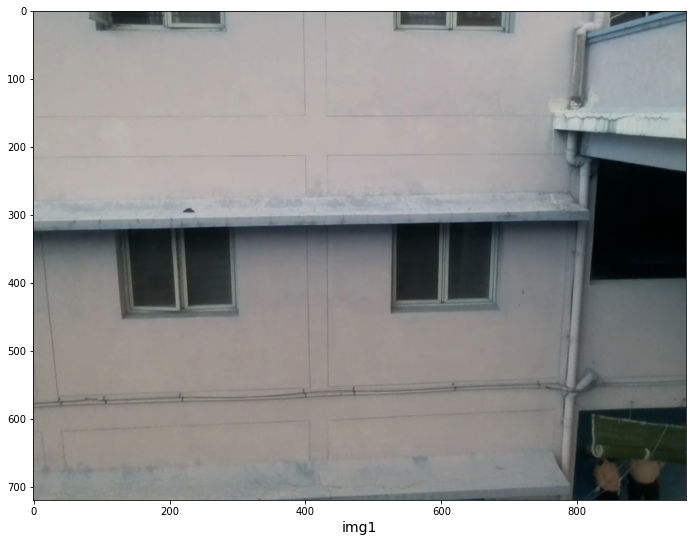

[[[495. 307.]
  [495. 465.]
  [698. 465.]
  [698. 307.]]

 [[122. 330.]
  [122. 440.]
  [295. 440.]
  [295. 330.]]]
(2, 4, 2)
[495, 307, 698, 465]
[122, 330, 295, 440]


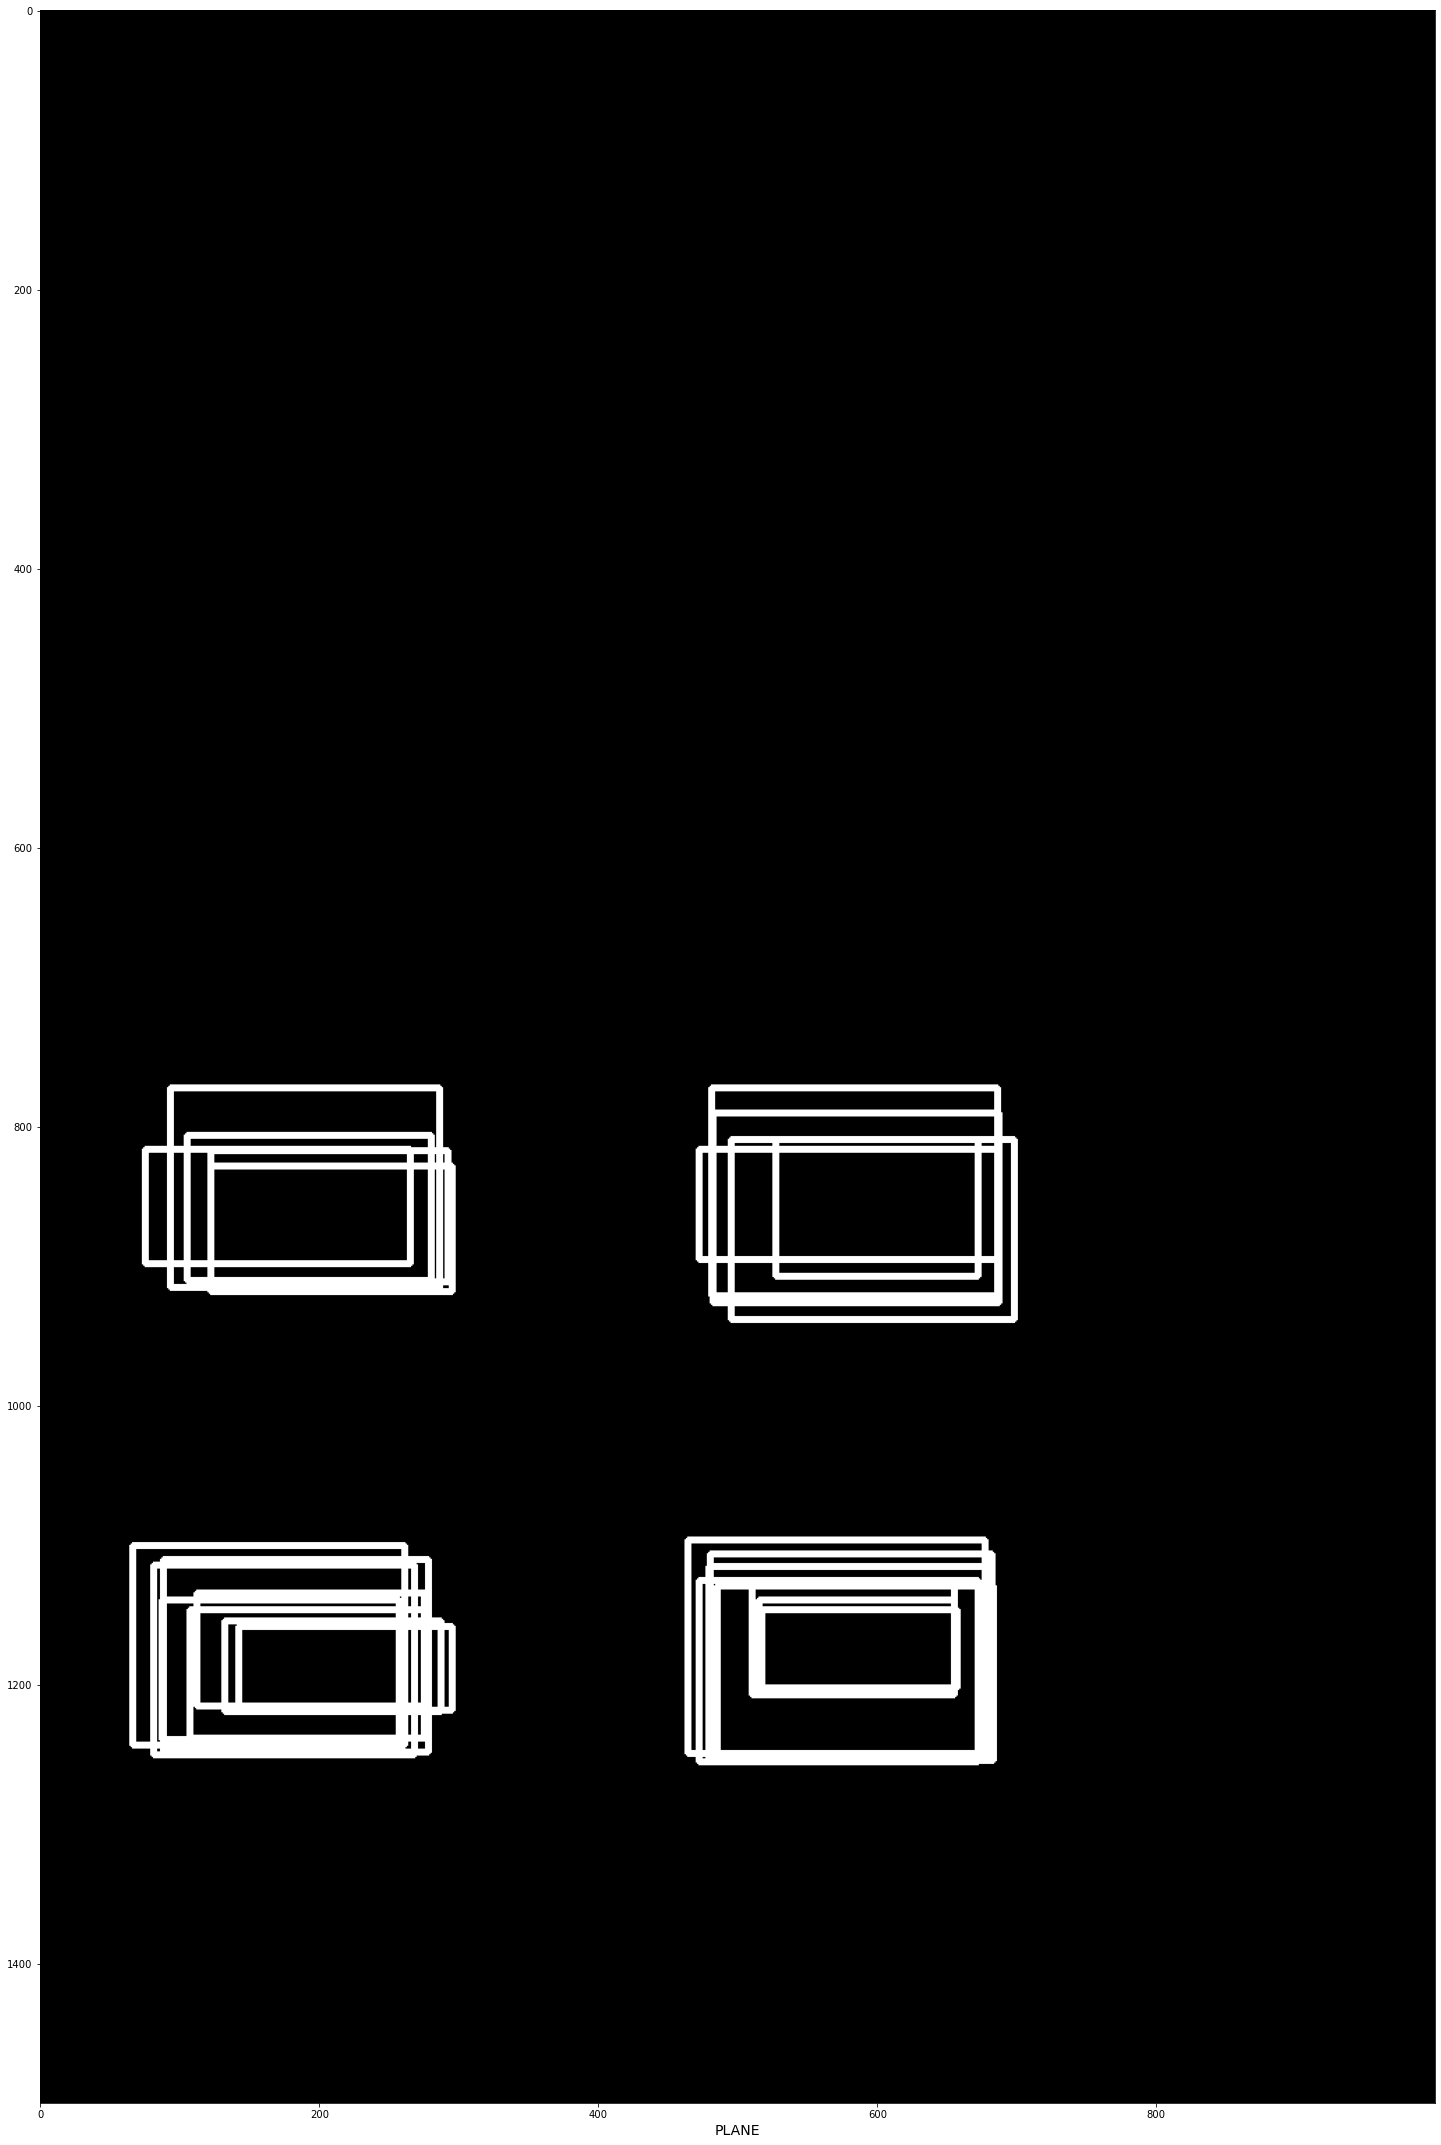

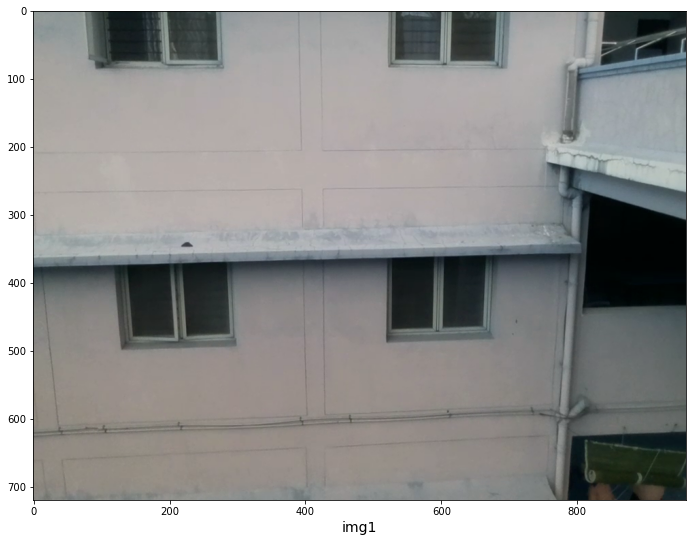

[[[122. 385.]
  [122. 487.]
  [295. 487.]
  [295. 385.]]

 [[525. 370.]
  [525. 477.]
  [667. 477.]
  [667. 370.]]

 [[483.   0.]
  [483. 100.]
  [708. 100.]
  [708.   0.]]

 [[ 92.   0.]
  [ 92.  97.]
  [295.  97.]
  [295.   0.]]]
(4, 4, 2)
[122, 385, 295, 487]
[525, 370, 667, 477]
[483, 0, 708, 100]
[92, 0, 295, 97]


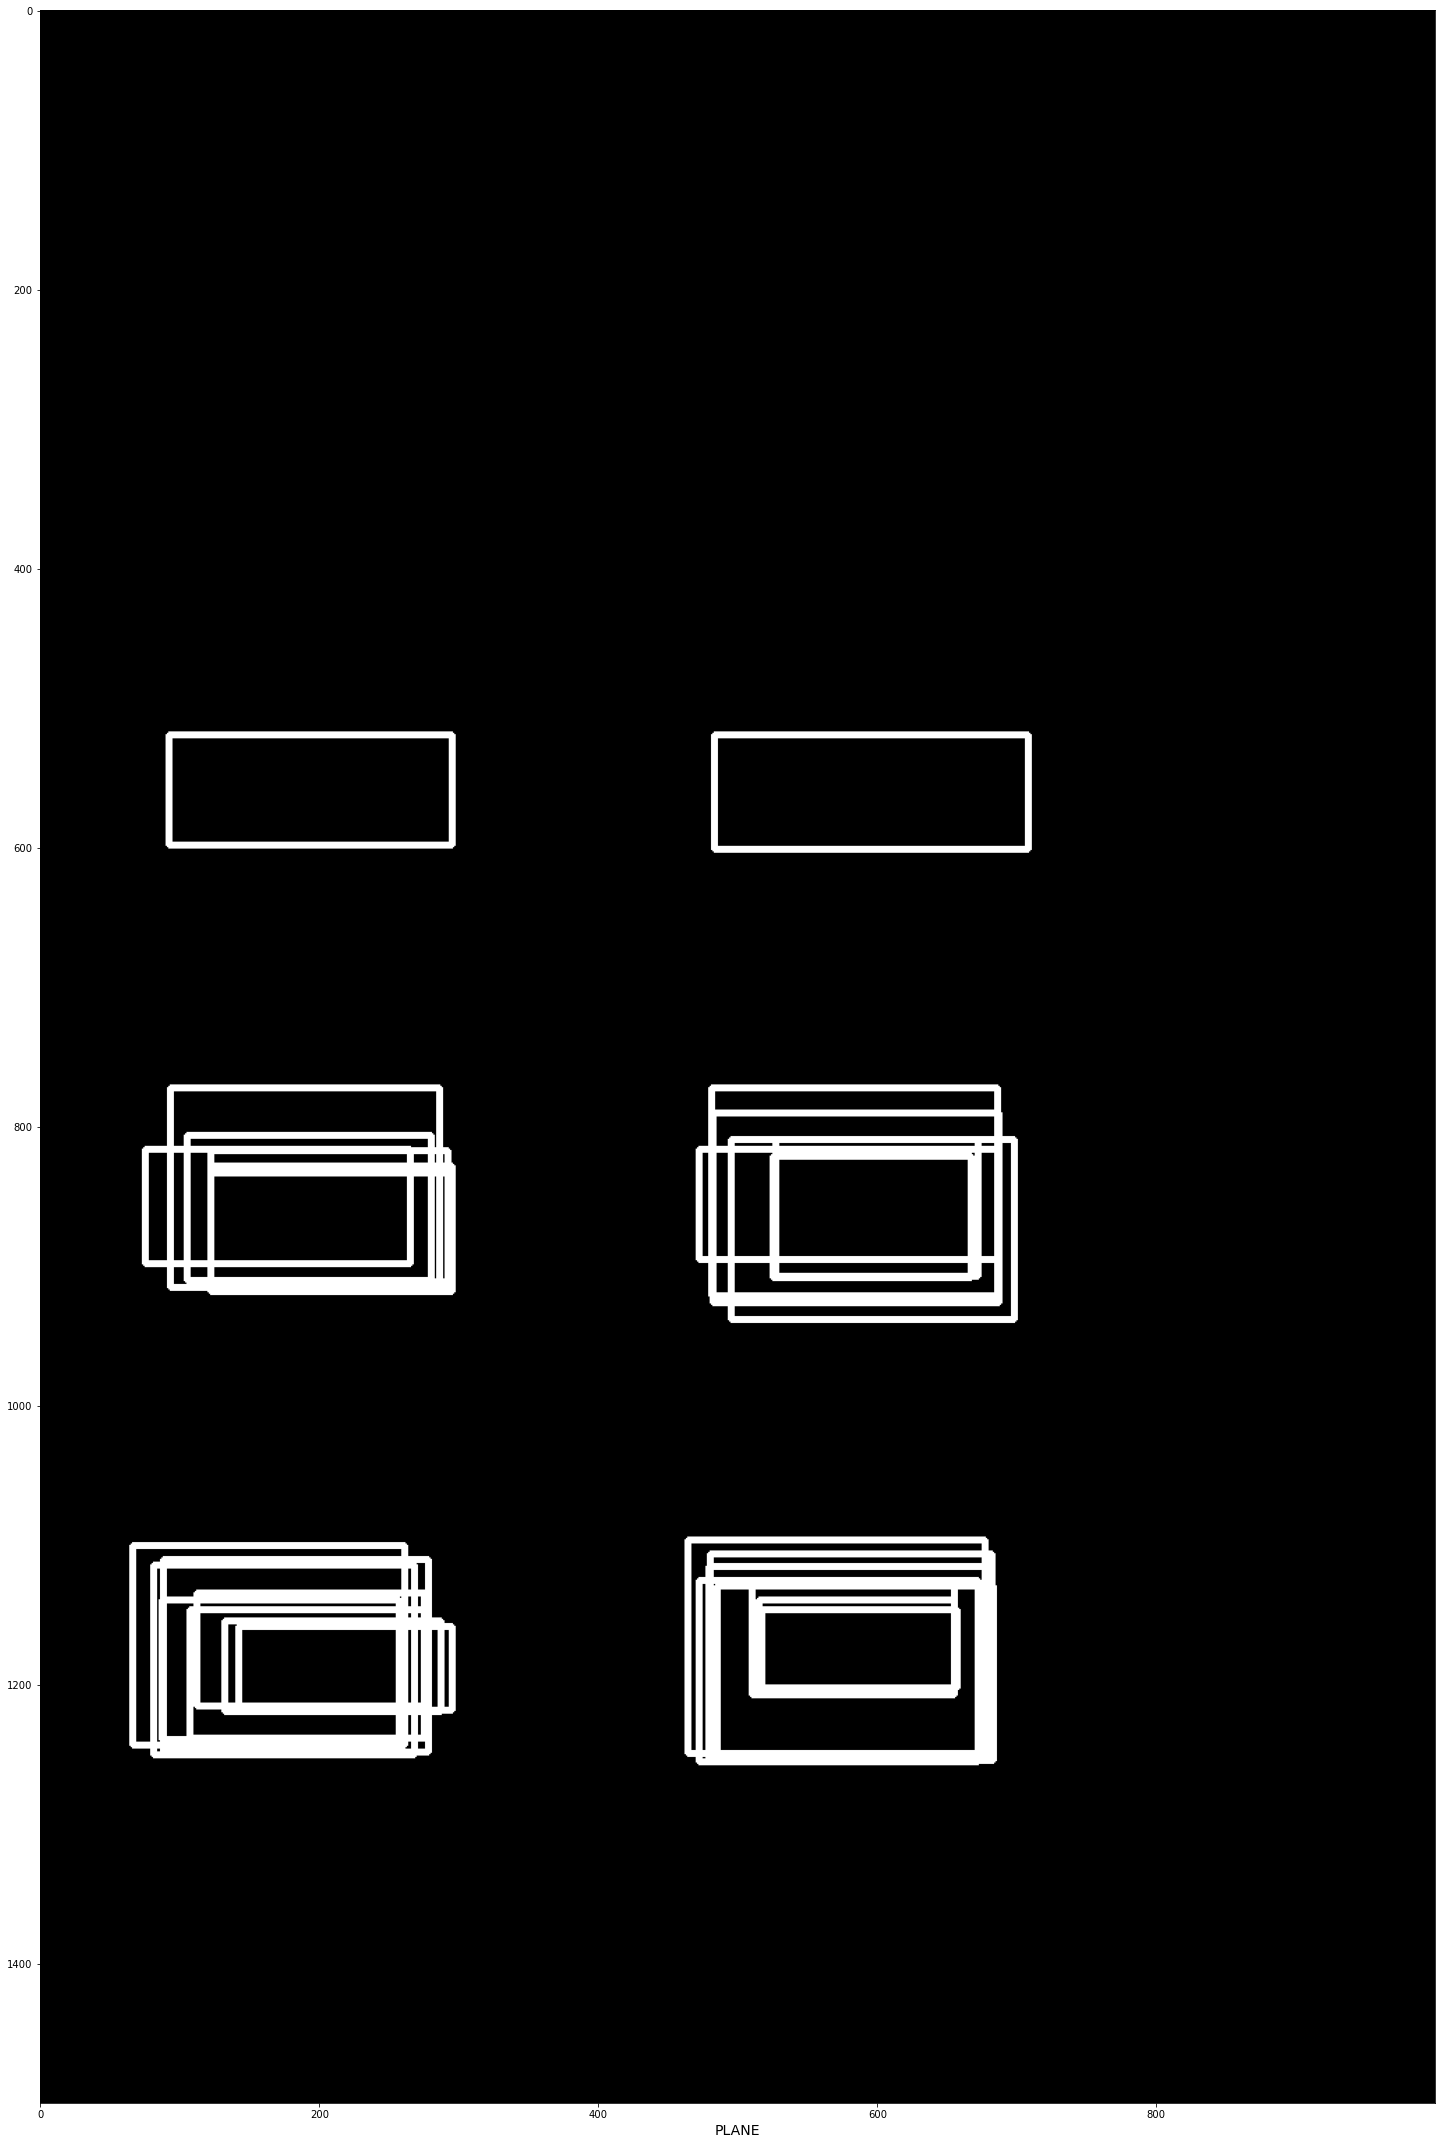

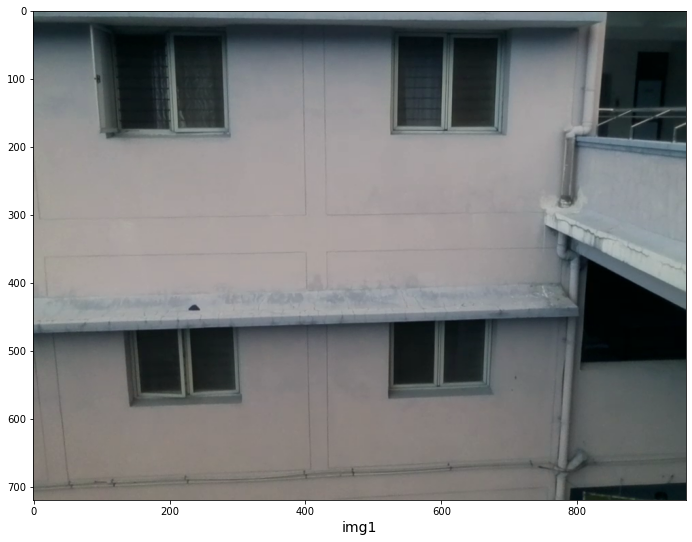

[[[135. 477.]
  [135. 572.]
  [302. 572.]
  [302. 477.]]

 [[525. 462.]
  [525. 560.]
  [670. 560.]
  [670. 462.]]

 [[488.  12.]
  [488. 202.]
  [710. 202.]
  [710.  12.]]

 [[ 95.  27.]
  [ 95. 180.]
  [287. 180.]
  [287.  27.]]]
(4, 4, 2)
[135, 477, 302, 572]
[525, 462, 670, 560]
[488, 12, 710, 202]
[95, 27, 287, 180]


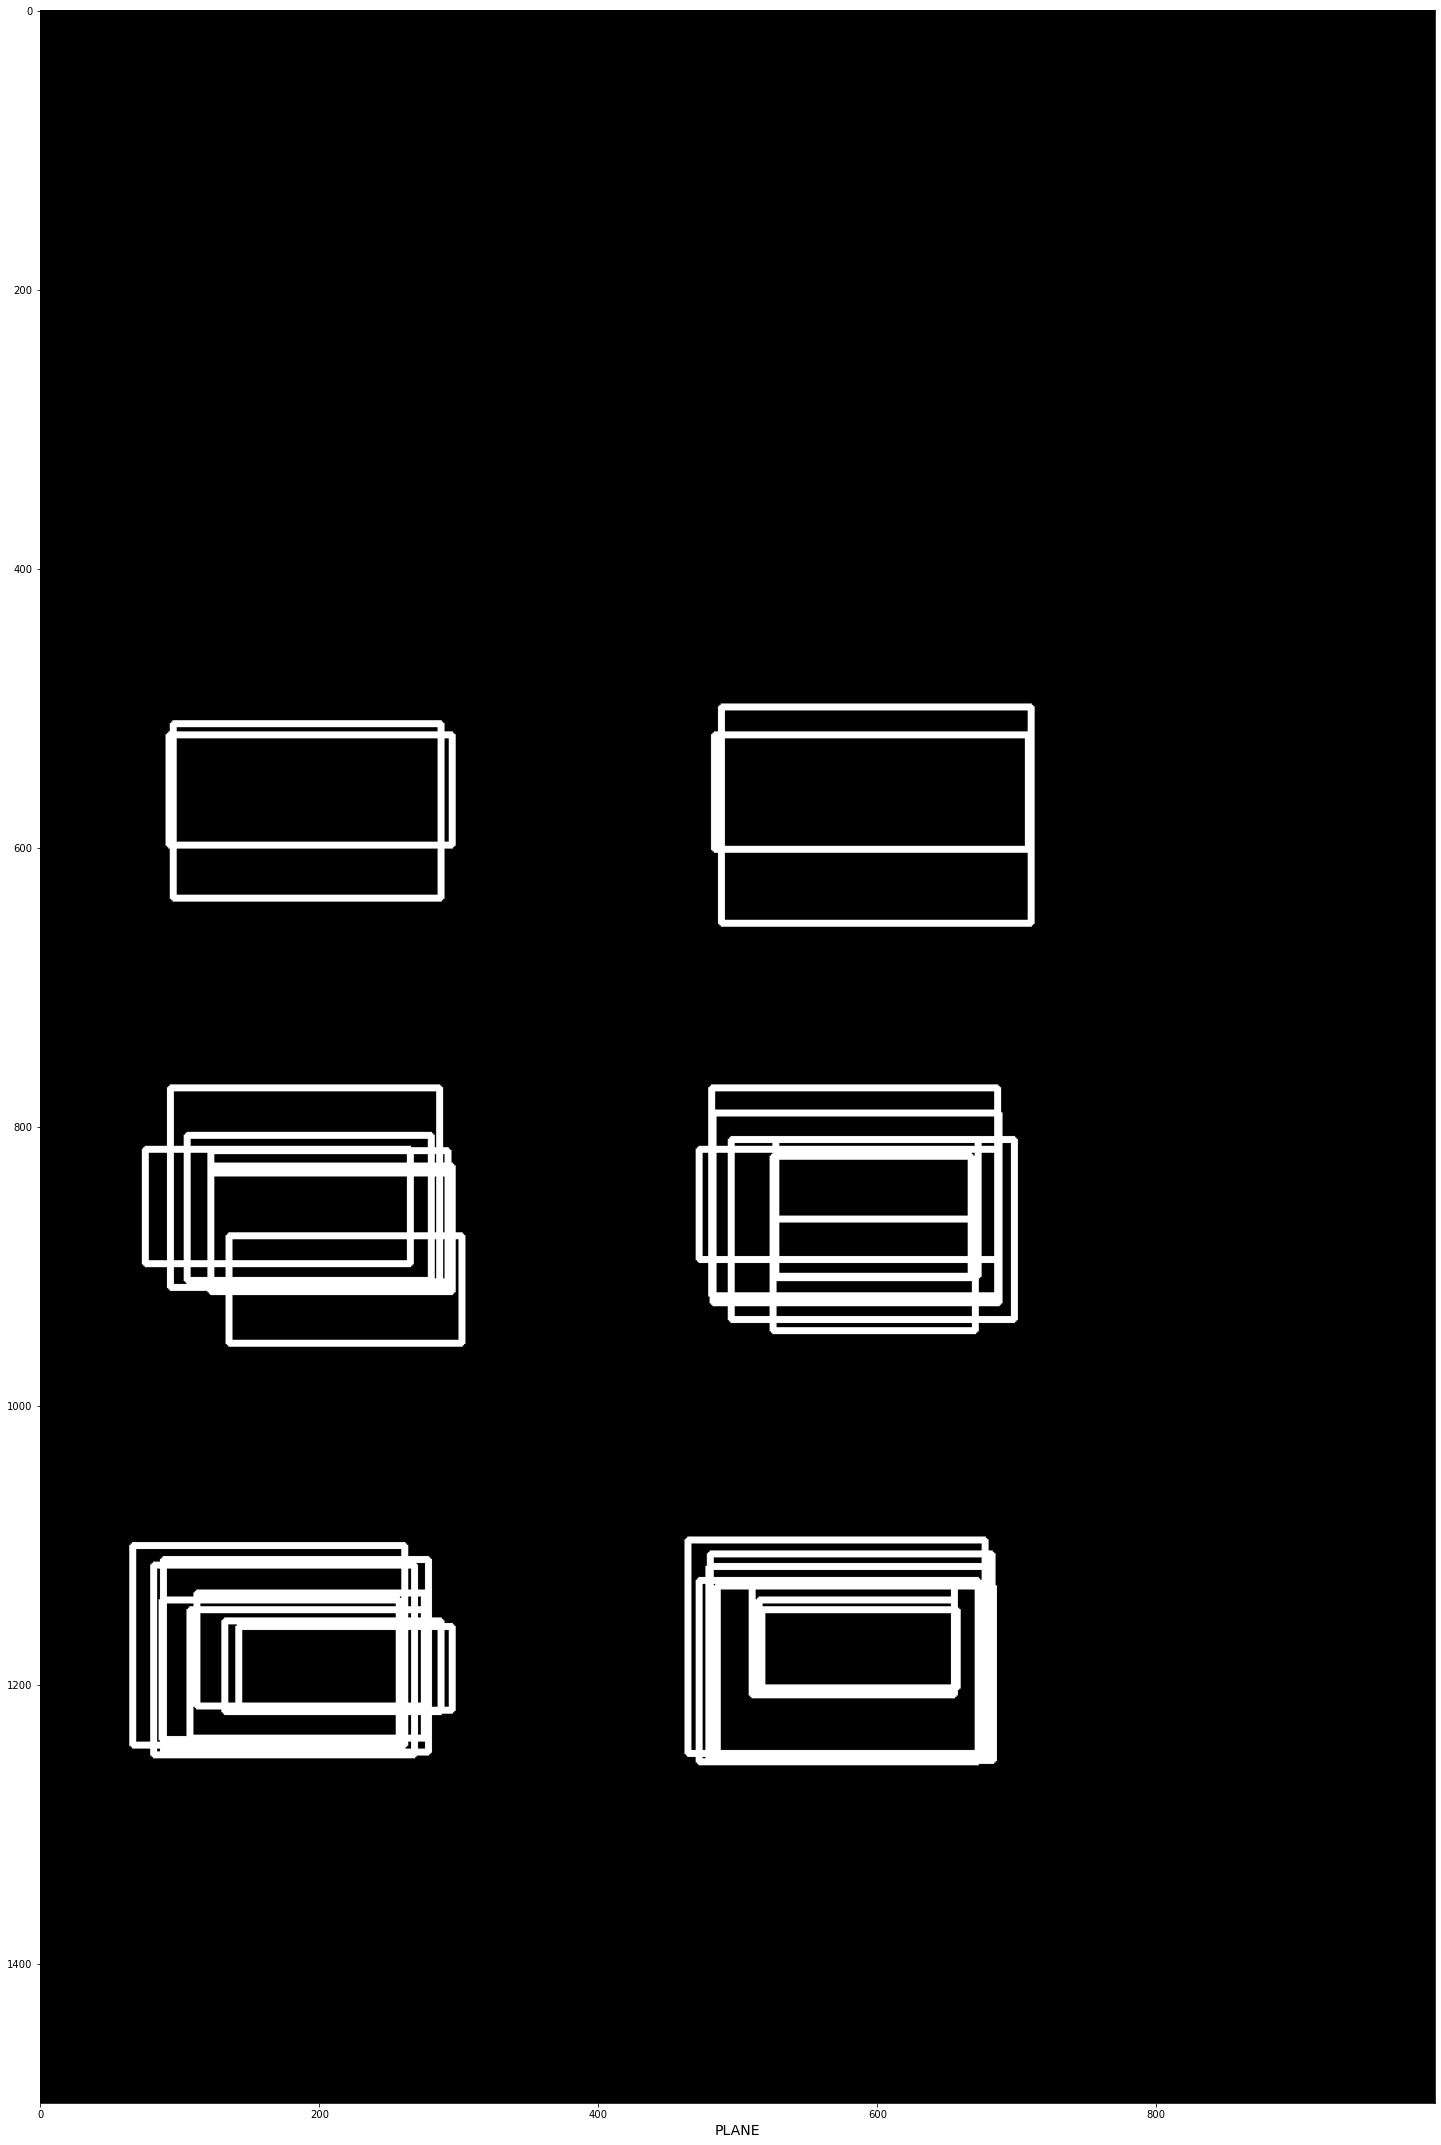

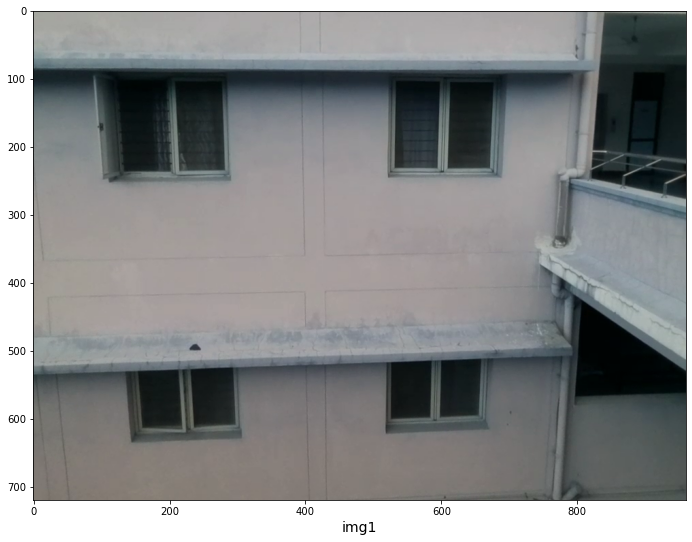

[[[140. 535.]
  [140. 625.]
  [302. 625.]
  [302. 535.]]

 [[520. 525.]
  [520. 610.]
  [665. 610.]
  [665. 525.]]

 [[482.  77.]
  [482. 265.]
  [700. 265.]
  [700.  77.]]

 [[ 97.  92.]
  [ 97. 245.]
  [285. 245.]
  [285.  92.]]]
(4, 4, 2)
[140, 535, 302, 625]
[520, 525, 665, 610]
[482, 77, 700, 265]
[97, 92, 285, 245]


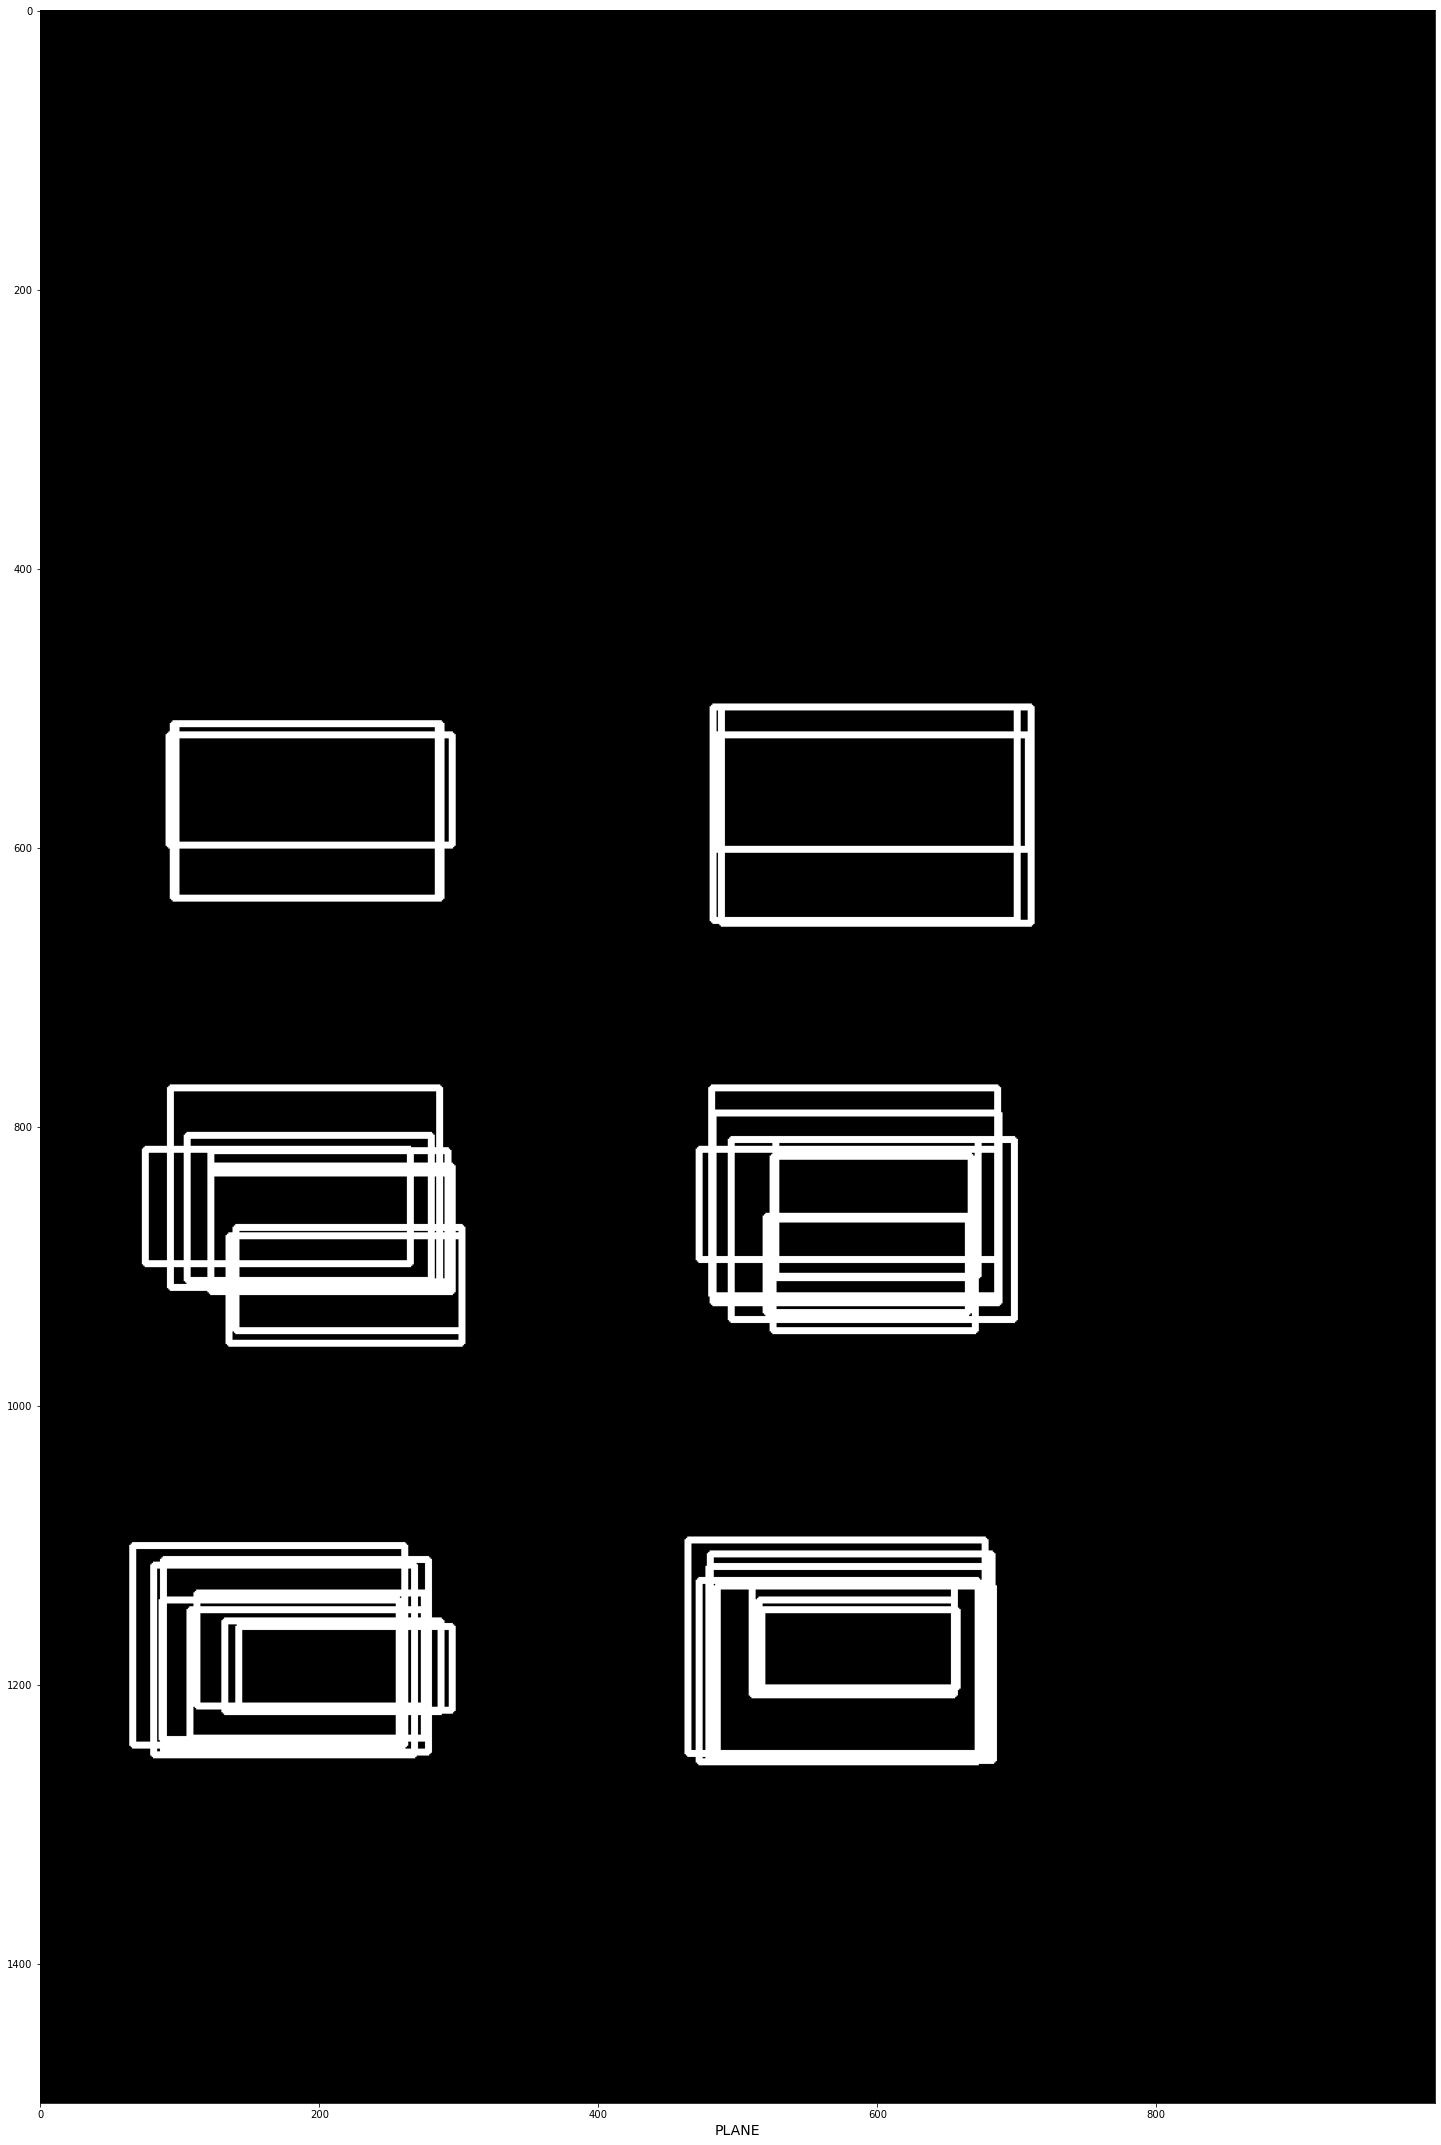

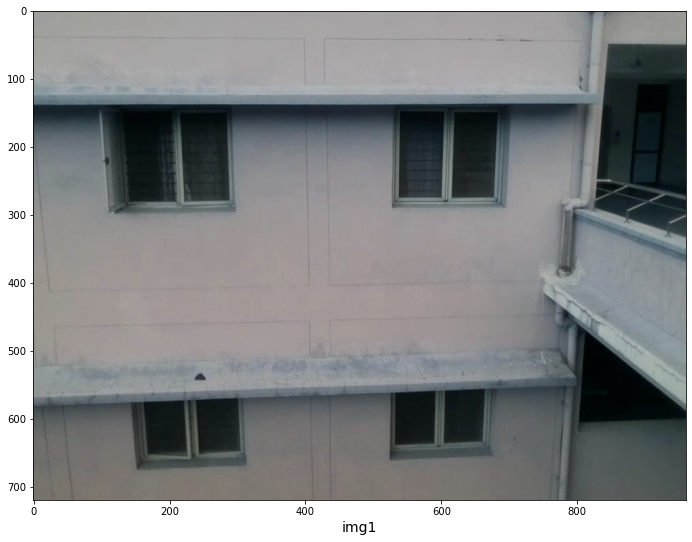

[[[145. 582.]
  [145. 662.]
  [307. 662.]
  [307. 582.]]

 [[525. 565.]
  [525. 650.]
  [667. 650.]
  [667. 565.]]

 [[496. 127.]
  [496. 310.]
  [708. 310.]
  [708. 127.]]

 [[118. 127.]
  [118. 300.]
  [308. 300.]
  [308. 127.]]]
(4, 4, 2)
[145, 582, 307, 662]
[525, 565, 667, 650]
[496, 127, 708, 310]
[118, 127, 308, 300]


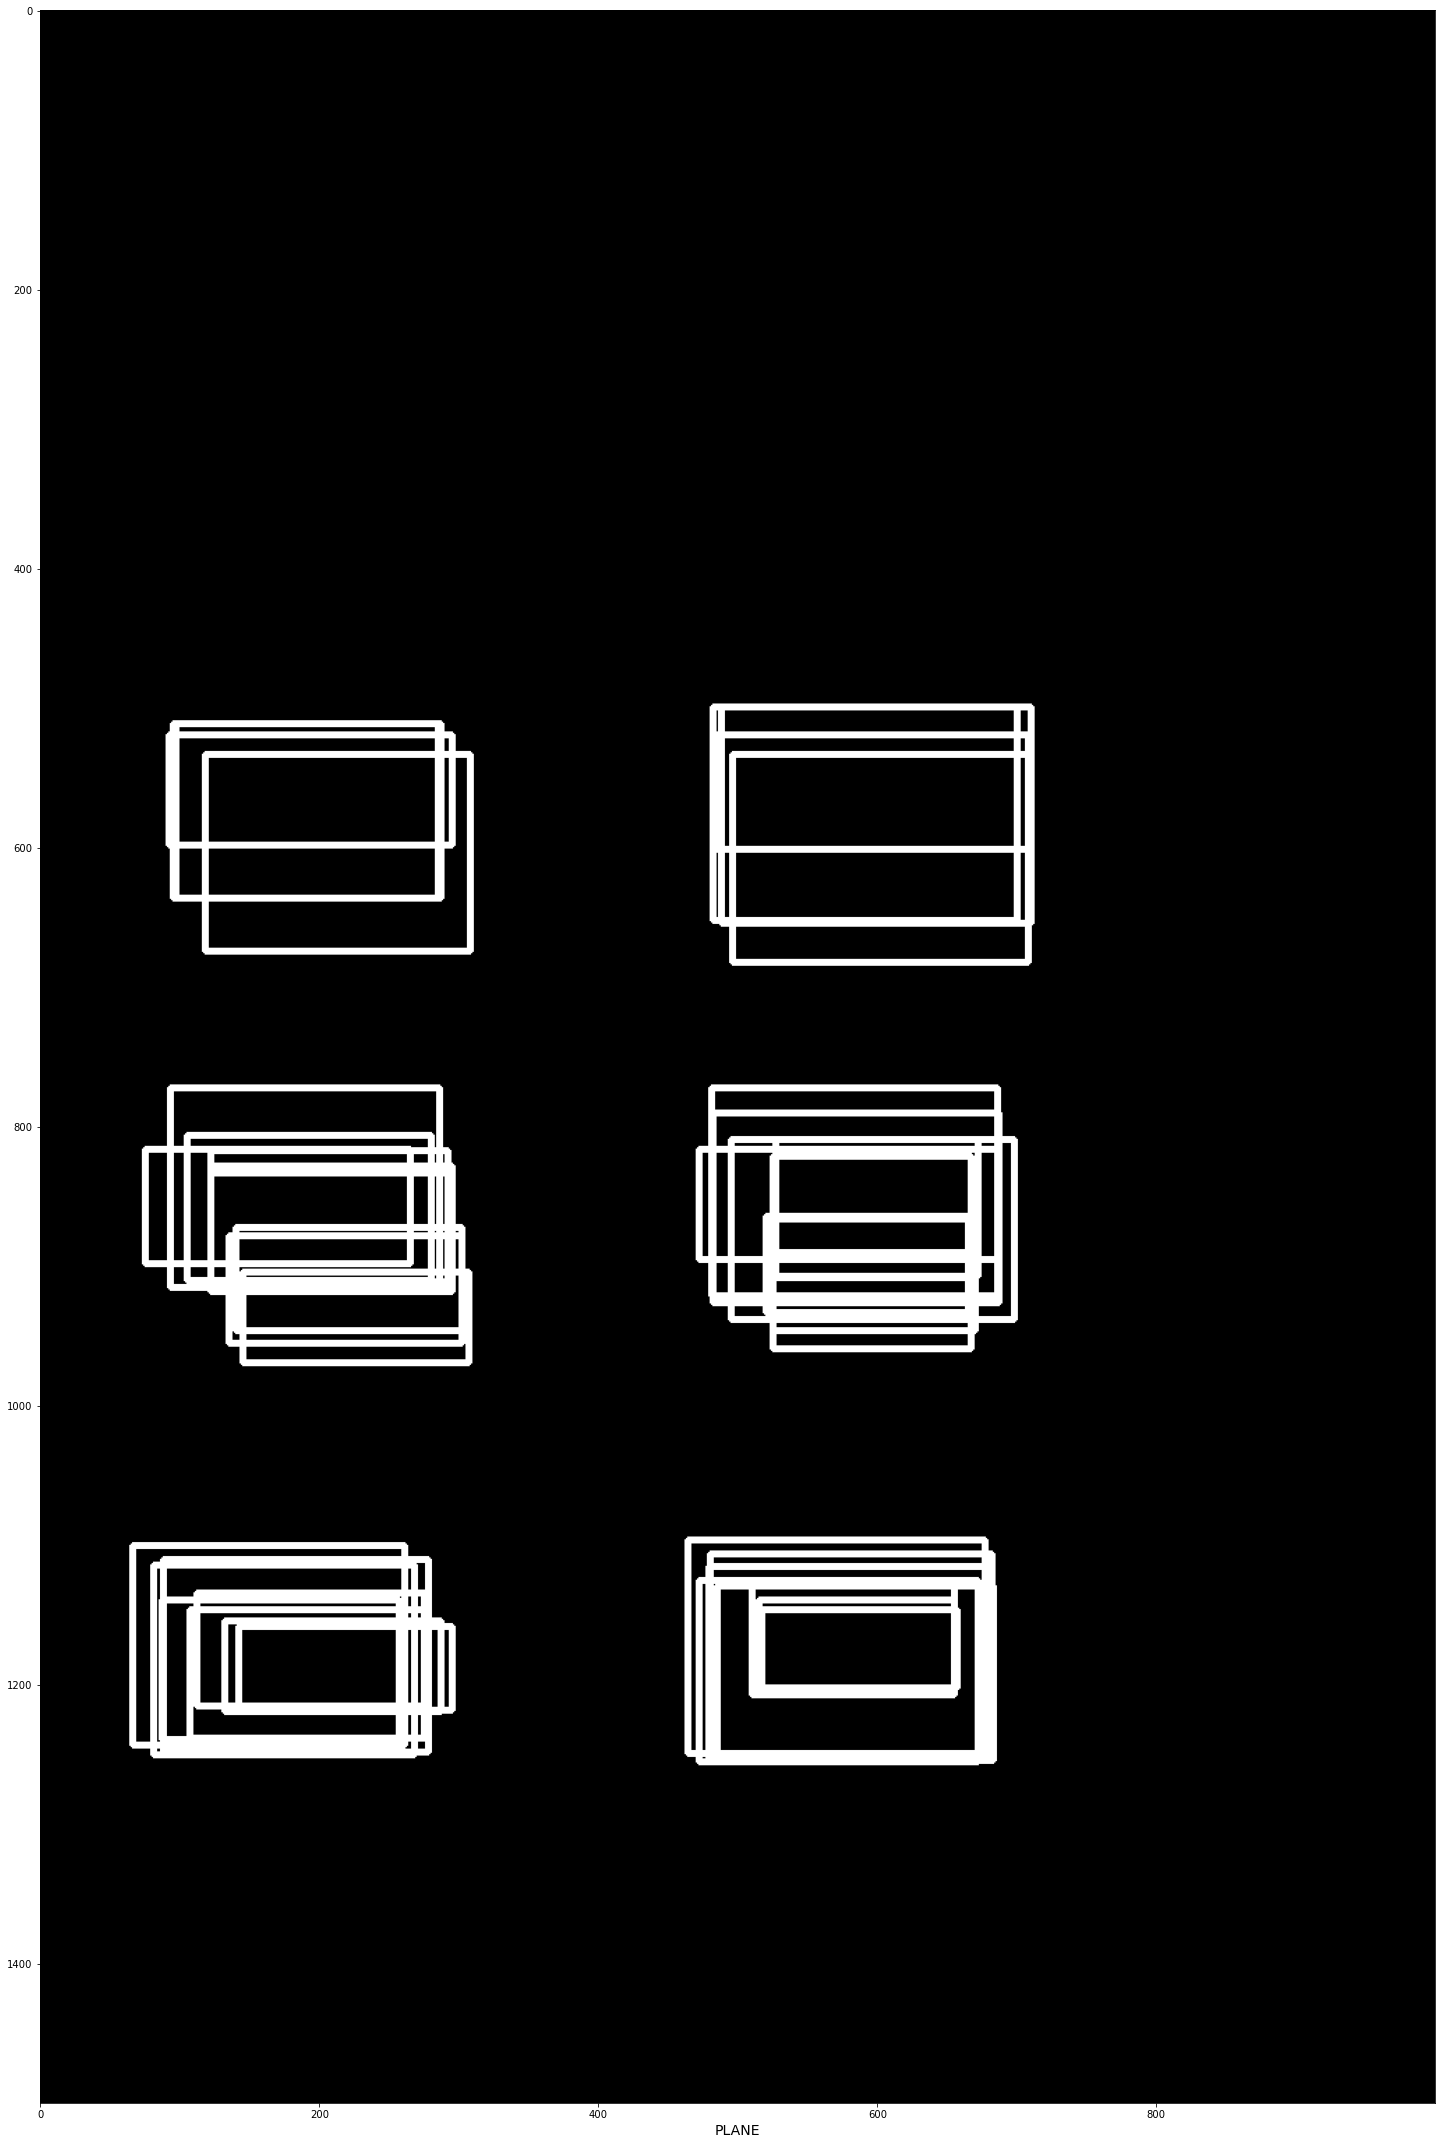

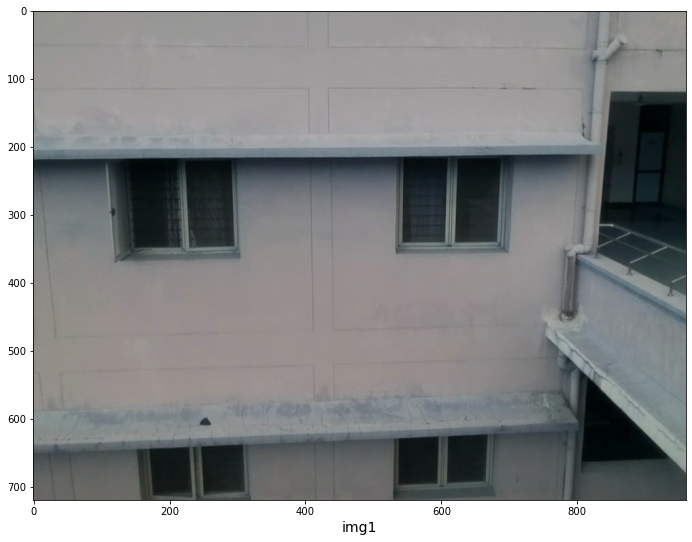

[[[530. 635.]
  [530. 707.]
  [672. 707.]
  [672. 635.]]

 [[115. 225.]
  [115. 357.]
  [297. 357.]
  [297. 225.]]

 [[537. 220.]
  [537. 352.]
  [692. 352.]
  [692. 220.]]]
(3, 4, 2)
[530, 635, 672, 707]
[115, 225, 297, 357]
[537, 220, 692, 352]


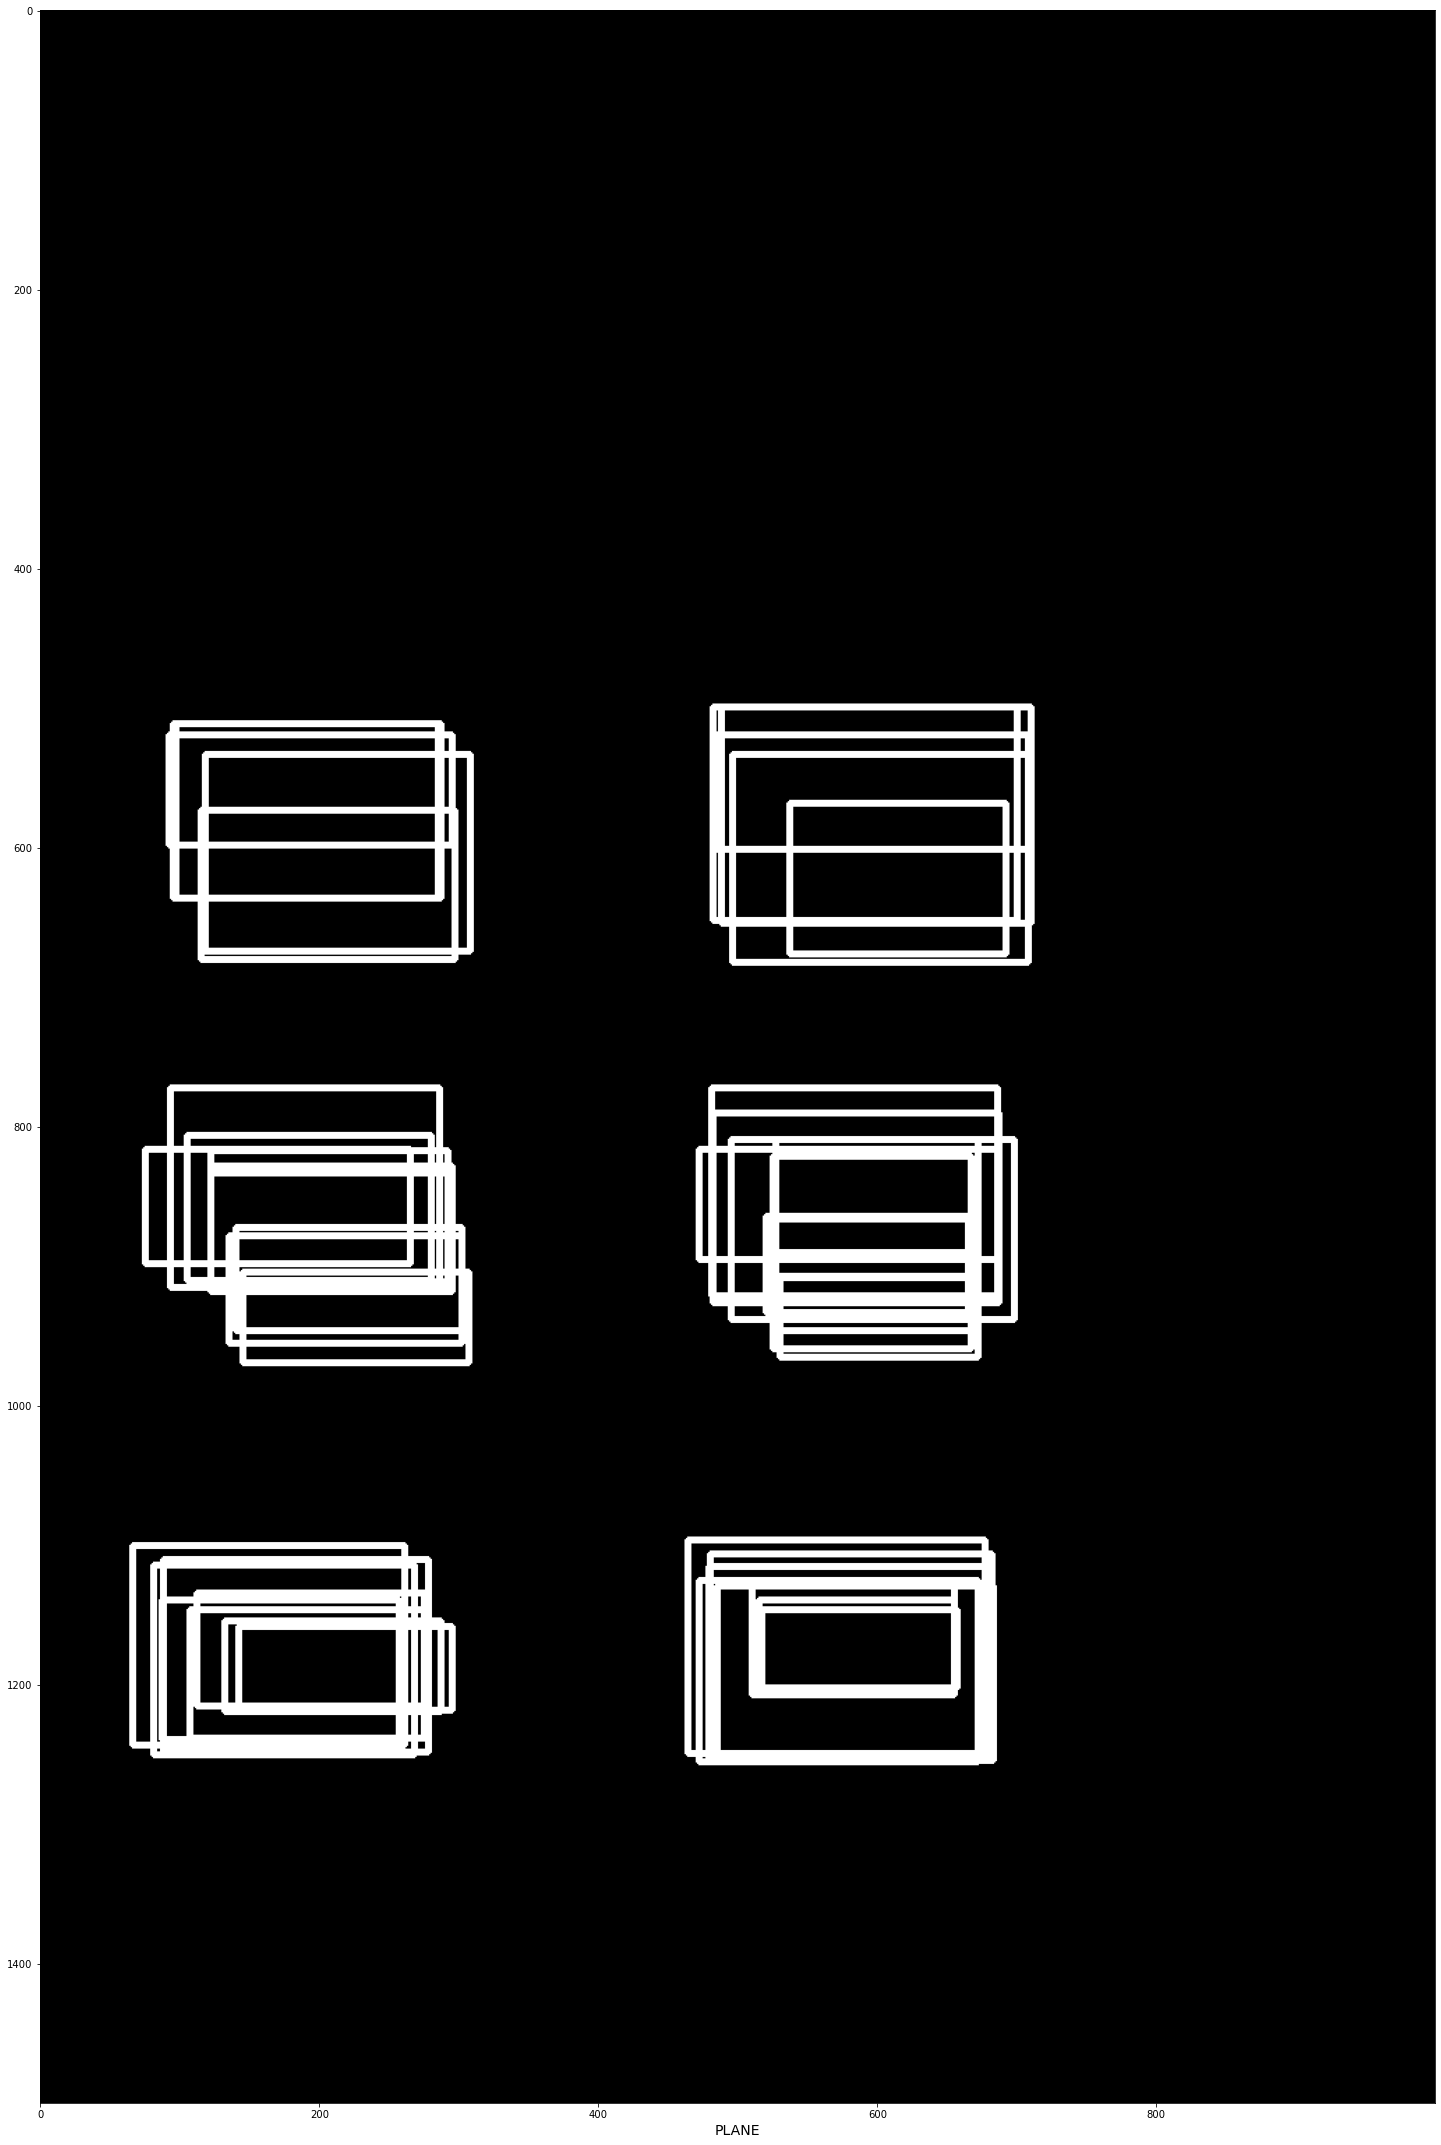

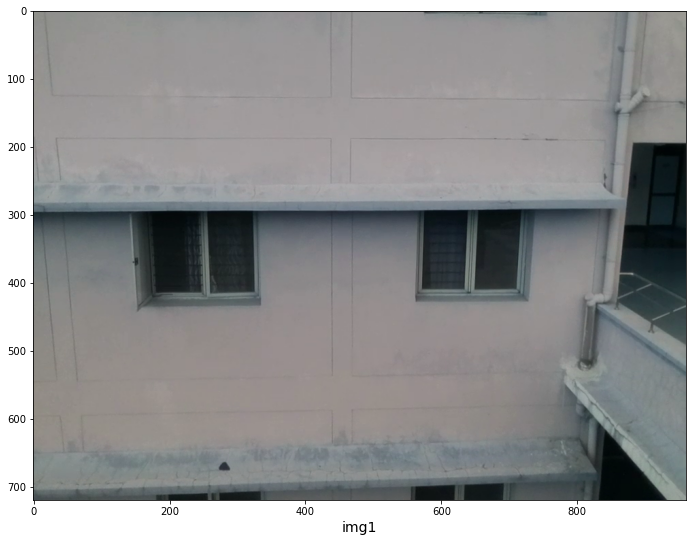

[[[529. 285.]
  [529. 447.]
  [739. 447.]
  [739. 285.]]

 [[157. 285.]
  [157. 437.]
  [349. 437.]
  [349. 285.]]]
(2, 4, 2)
[529, 285, 739, 447]
[157, 285, 349, 437]


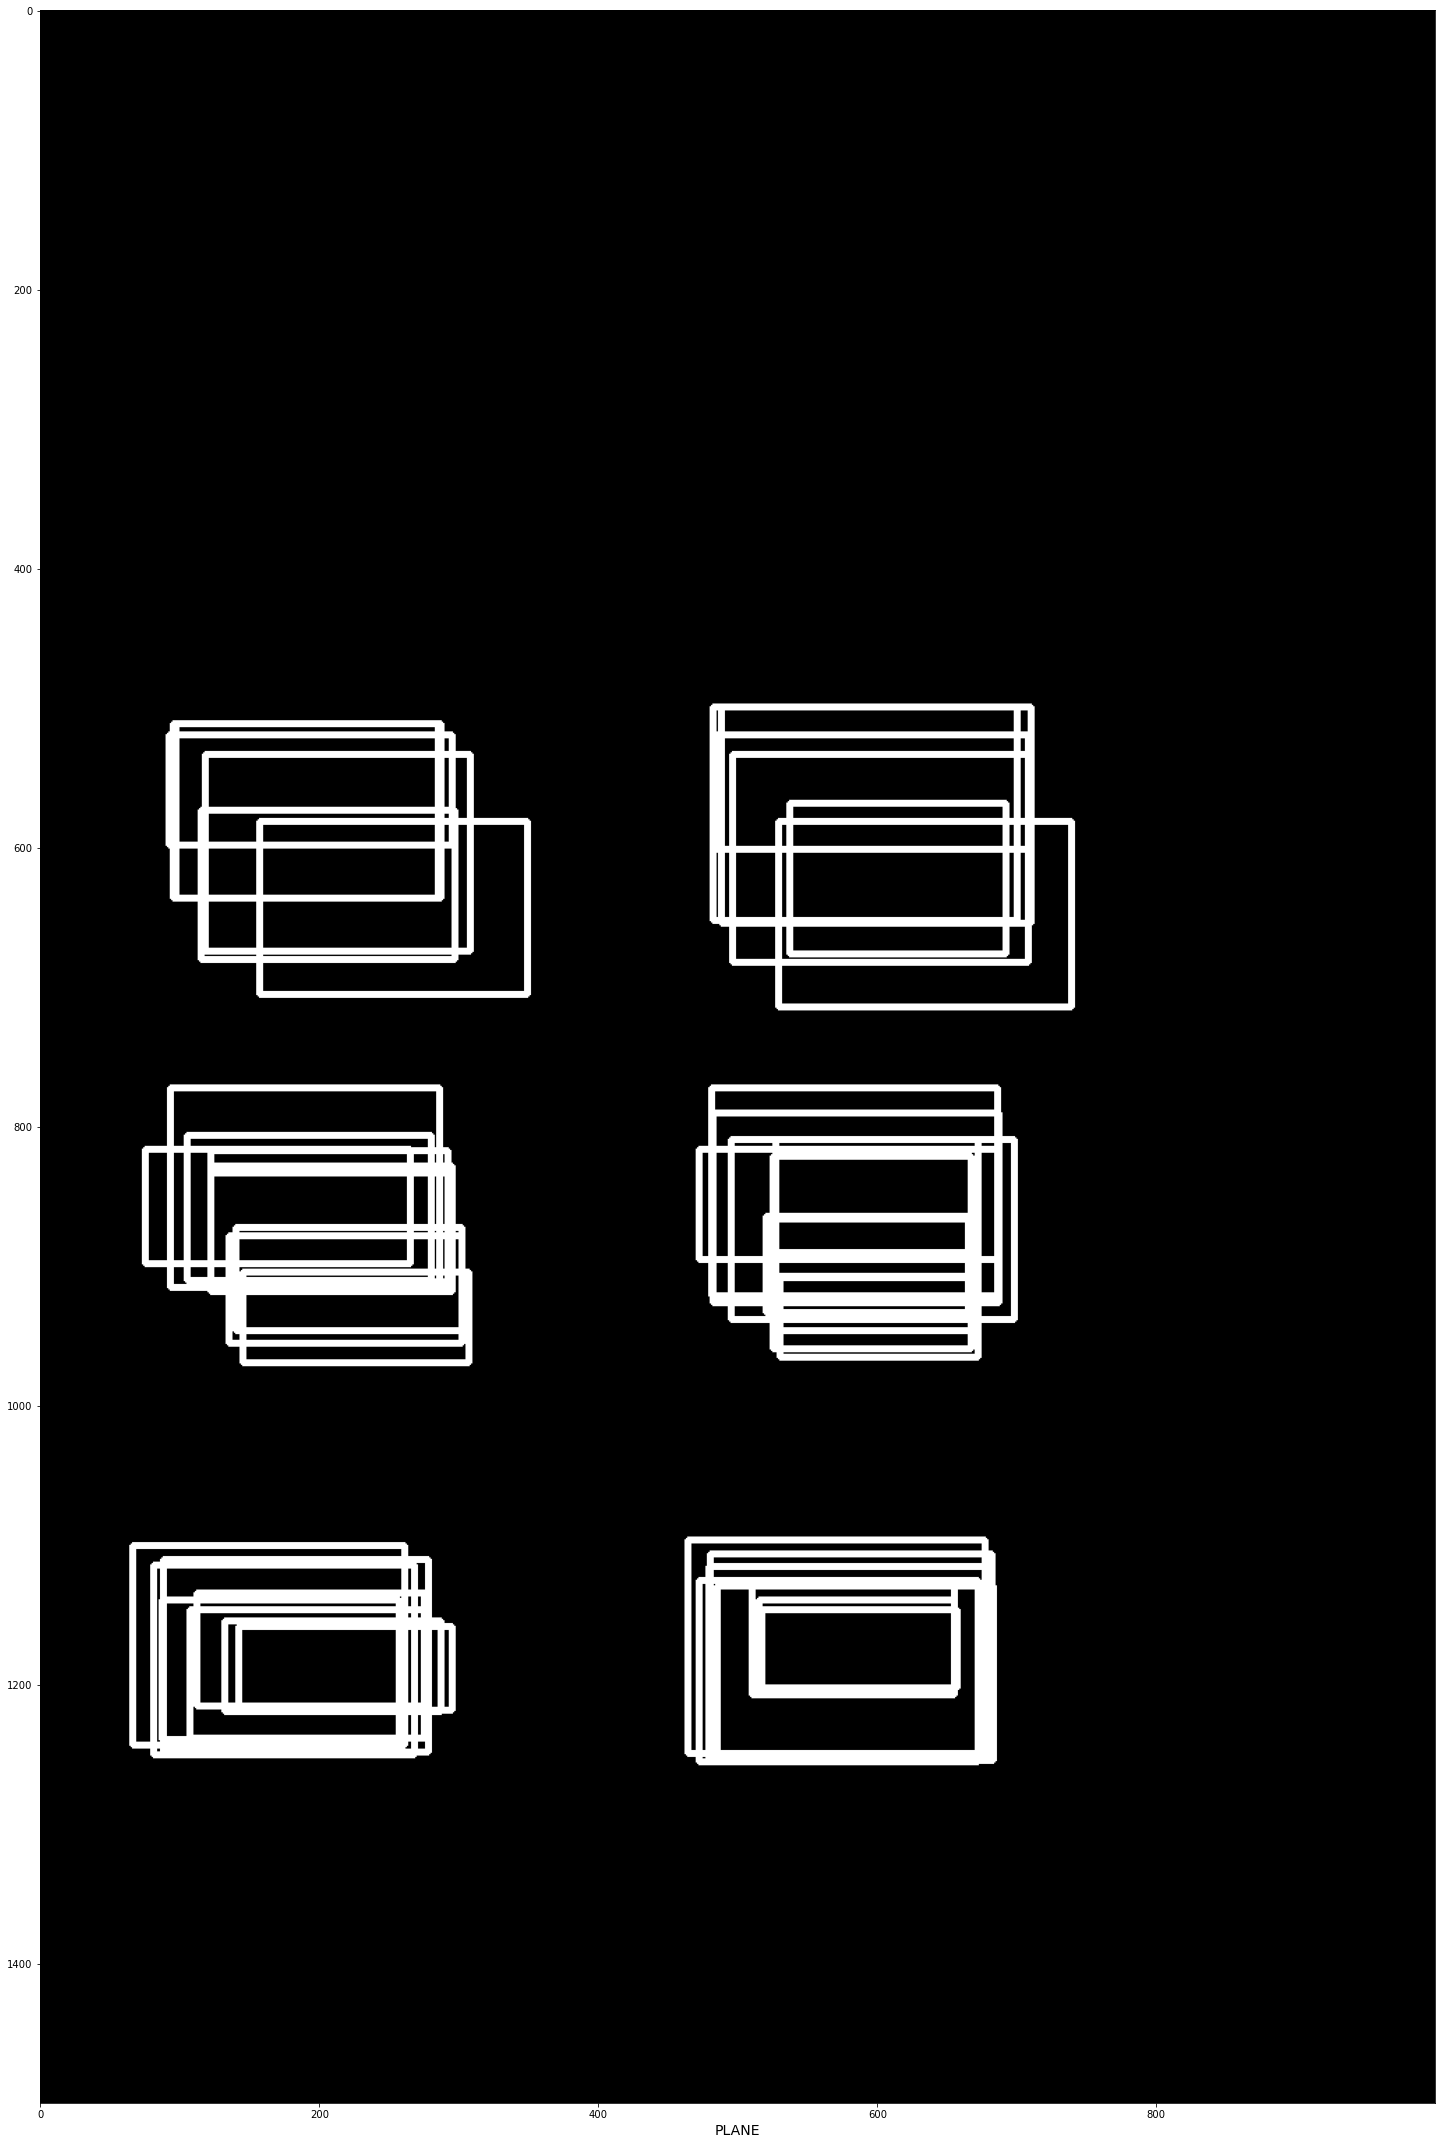

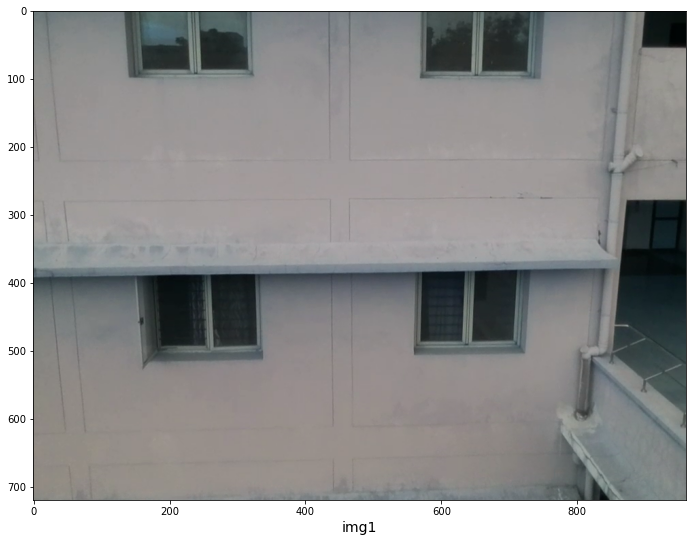

[[[157. 395.]
  [157. 502.]
  [332. 502.]
  [332. 395.]]

 [[565. 390.]
  [565. 500.]
  [717. 500.]
  [717. 390.]]

 [[135.   0.]
  [135. 115.]
  [340. 115.]
  [340.   0.]]

 [[544.   0.]
  [544. 112.]
  [757. 112.]
  [757.   0.]]]
(4, 4, 2)
[157, 395, 332, 502]
[565, 390, 717, 500]
[135, 0, 340, 115]
[544, 0, 757, 112]


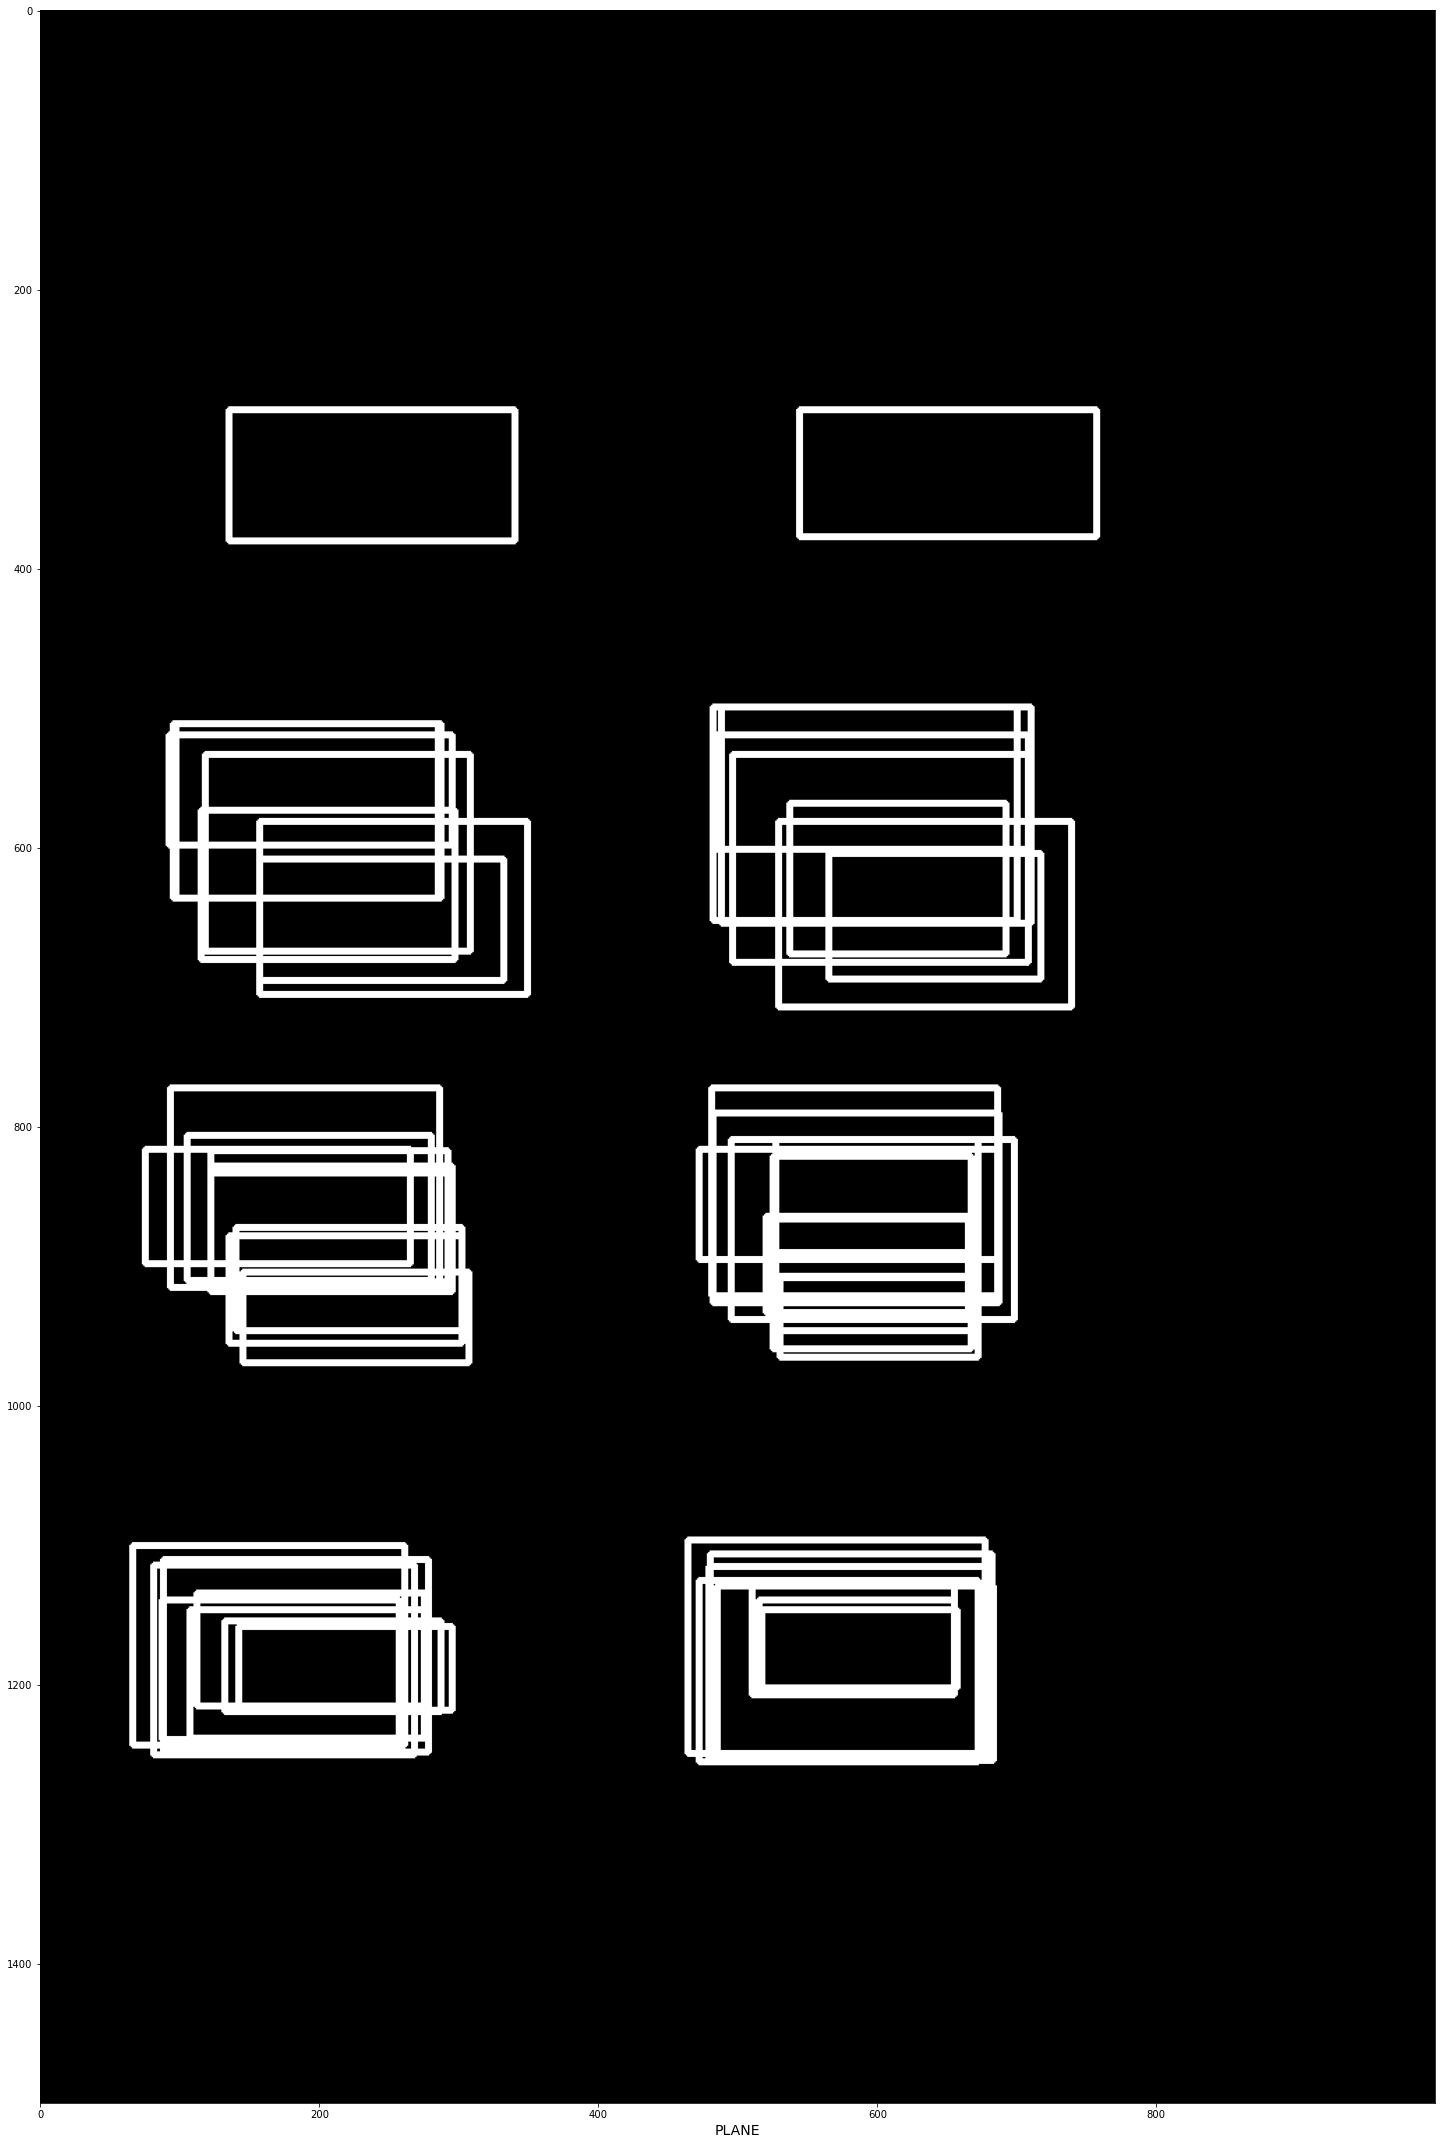

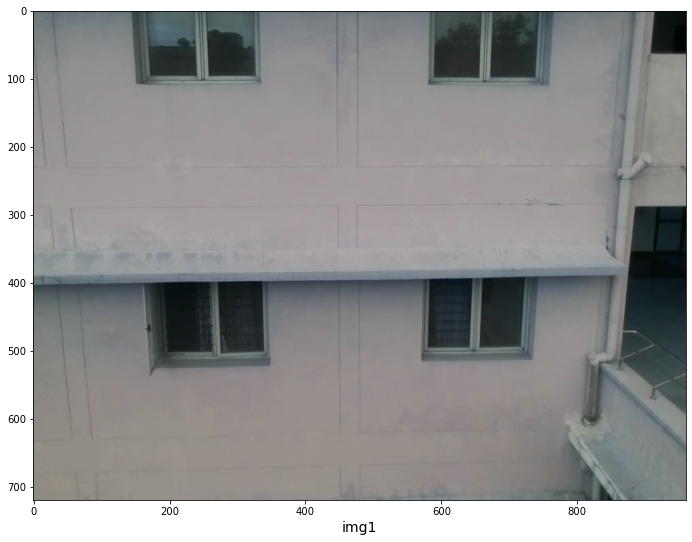

[[[170. 402.]
  [170. 515.]
  [345. 515.]
  [345. 402.]]

 [[575. 400.]
  [575. 510.]
  [727. 510.]
  [727. 400.]]

 [[148.   0.]
  [148. 127.]
  [350. 127.]
  [350.   0.]]

 [[555.   0.]
  [555. 125.]
  [768. 125.]
  [768.   0.]]]
(4, 4, 2)
[170, 402, 345, 515]
[575, 400, 727, 510]
[148, 0, 350, 127]
[555, 0, 768, 125]


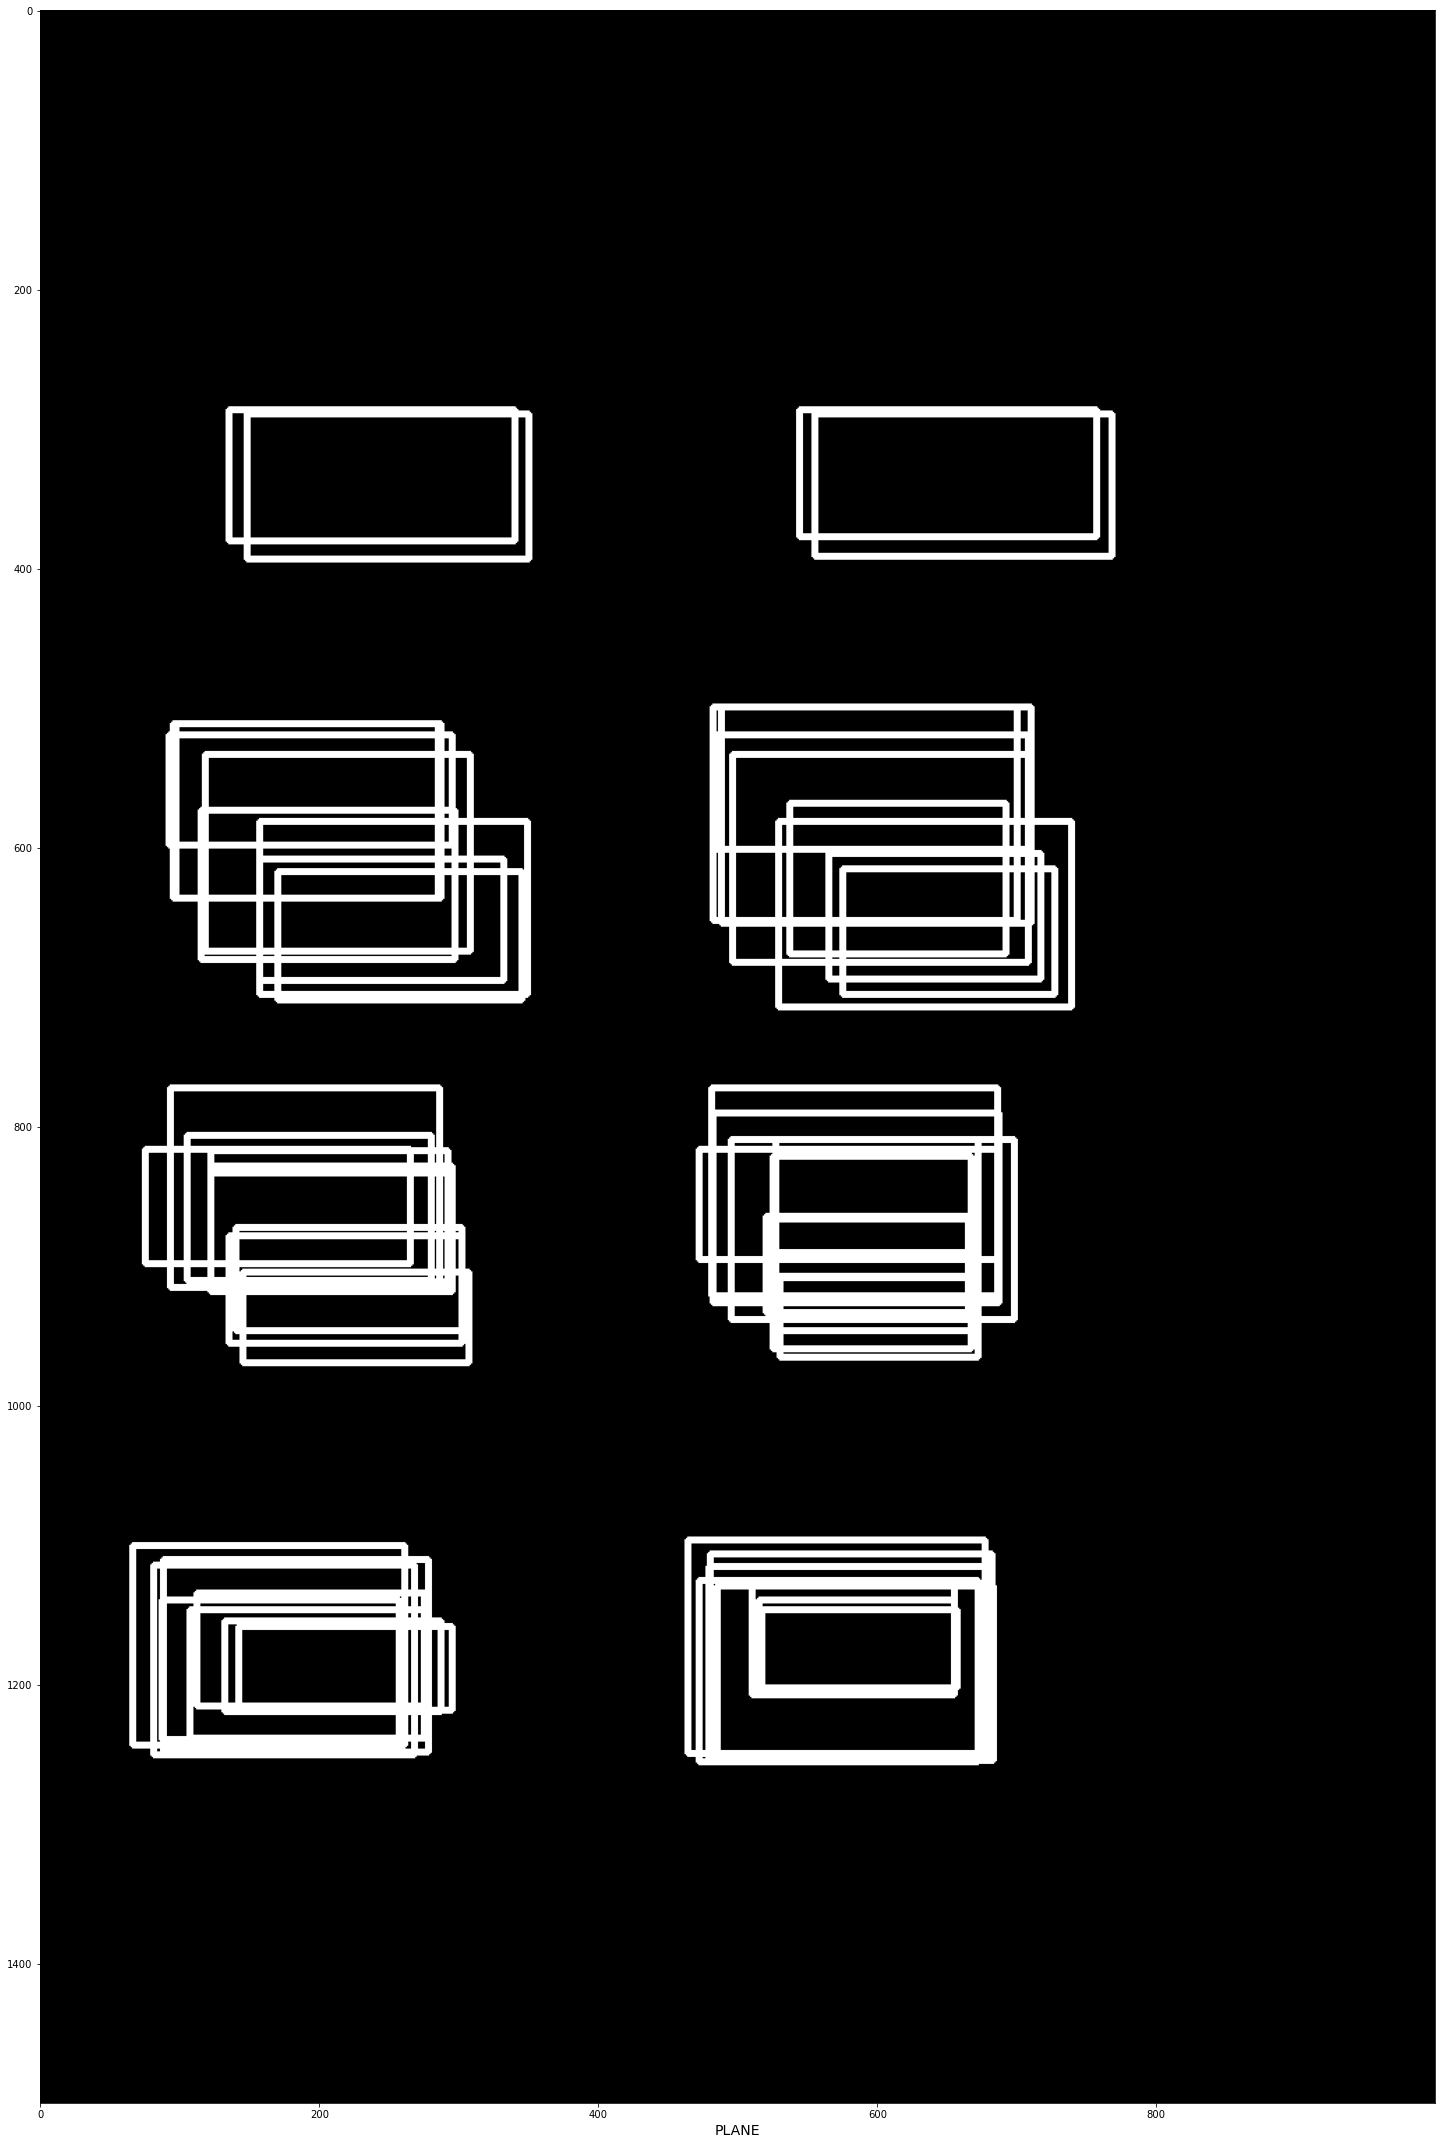

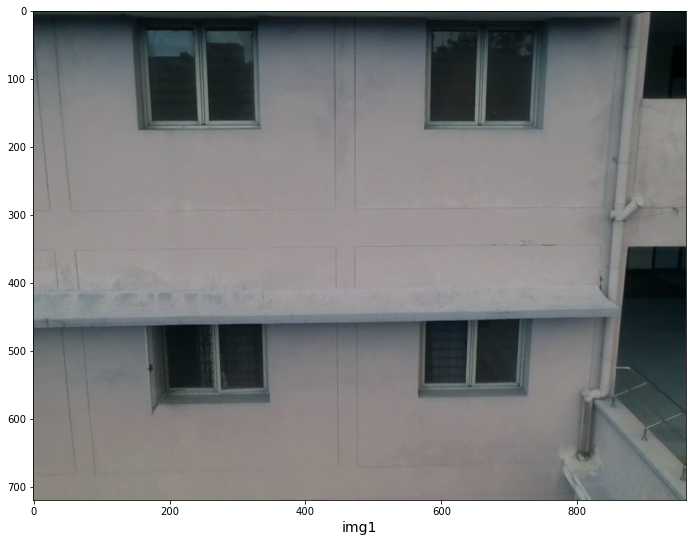

[[[170. 470.]
  [170. 567.]
  [345. 567.]
  [345. 470.]]

 [[570. 462.]
  [570. 562.]
  [720. 562.]
  [720. 462.]]

 [[546.   7.]
  [546. 190.]
  [756. 190.]
  [756.   7.]]

 [[150.  22.]
  [150. 170.]
  [330. 170.]
  [330.  22.]]]
(4, 4, 2)
[170, 470, 345, 567]
[570, 462, 720, 562]
[546, 7, 756, 190]
[150, 22, 330, 170]


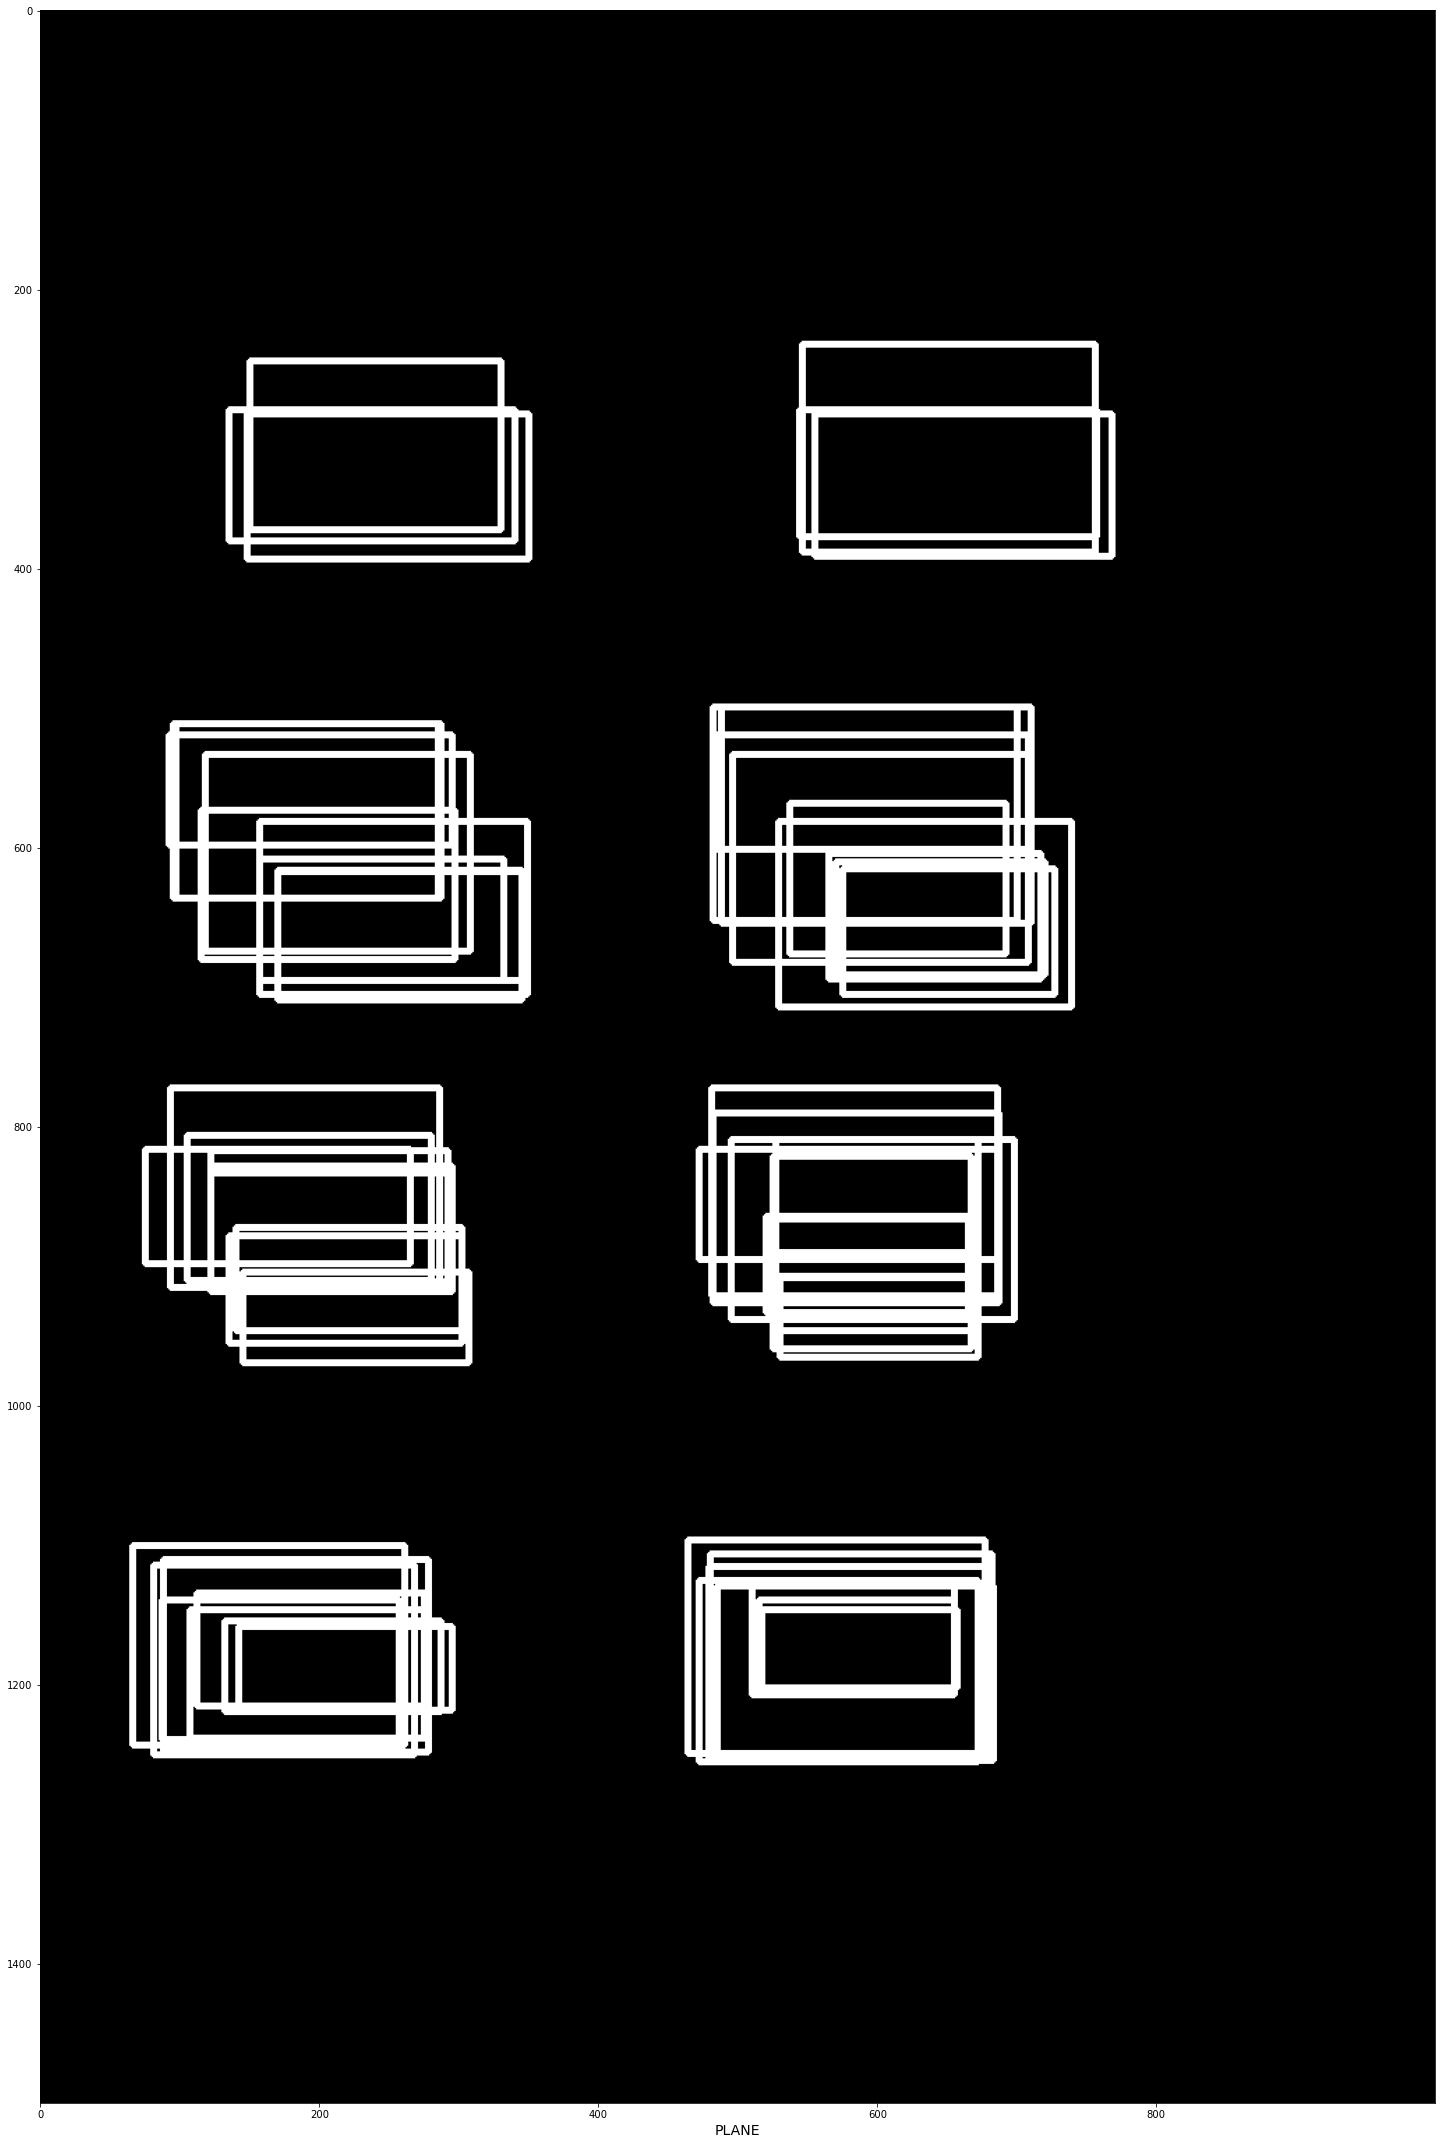

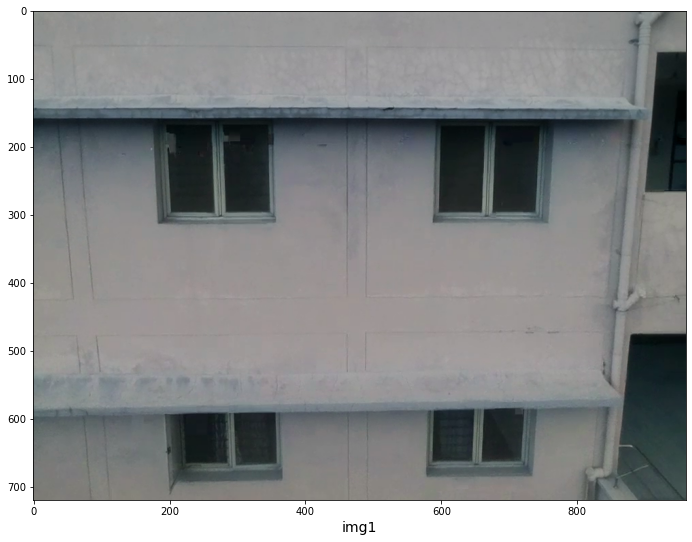

[[[200. 600.]
  [200. 682.]
  [360. 682.]
  [360. 600.]]

 [[580. 592.]
  [580. 677.]
  [727. 677.]
  [727. 592.]]

 [[562. 147.]
  [562. 327.]
  [764. 327.]
  [764. 147.]]

 [[178. 147.]
  [178. 325.]
  [375. 325.]
  [375. 147.]]]
(4, 4, 2)
[200, 600, 360, 682]
[580, 592, 727, 677]
[562, 147, 764, 327]
[178, 147, 375, 325]


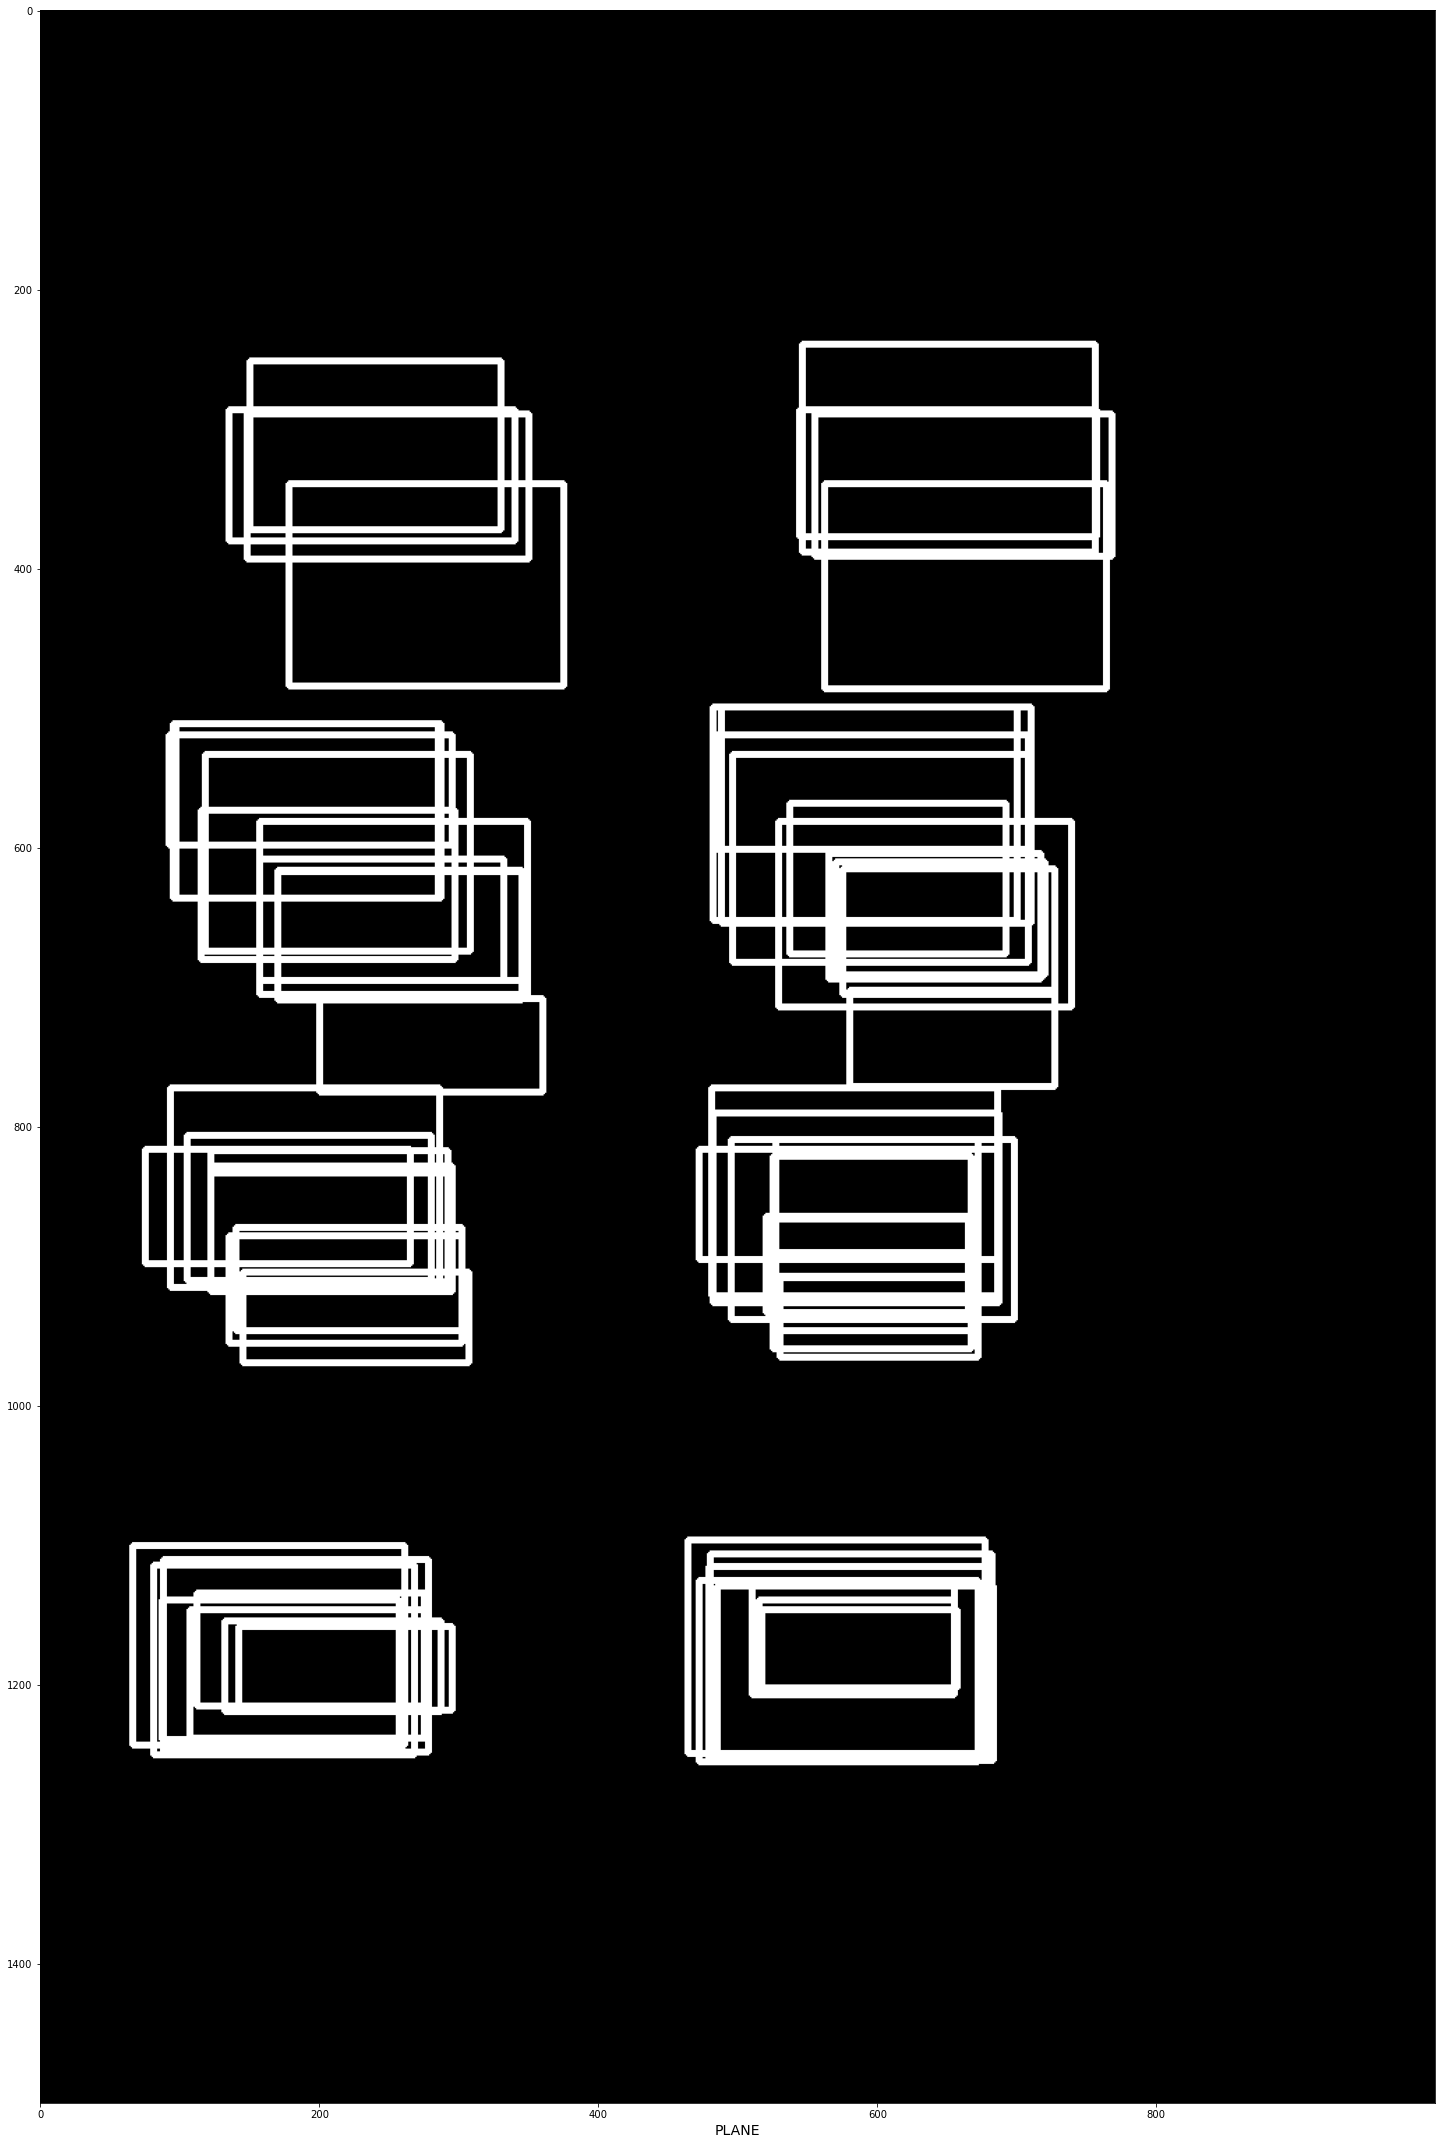

before NMS: [[ 472 1125  672 1255]
 [  81 1114  268 1250]
 [ 145  904  307  969]
 [ 530  907  672  965]
 [ 200  708  360  775]
 [ 580  702  727  771]
 [ 562  339  764  486]
 [ 178  339  375  484]]


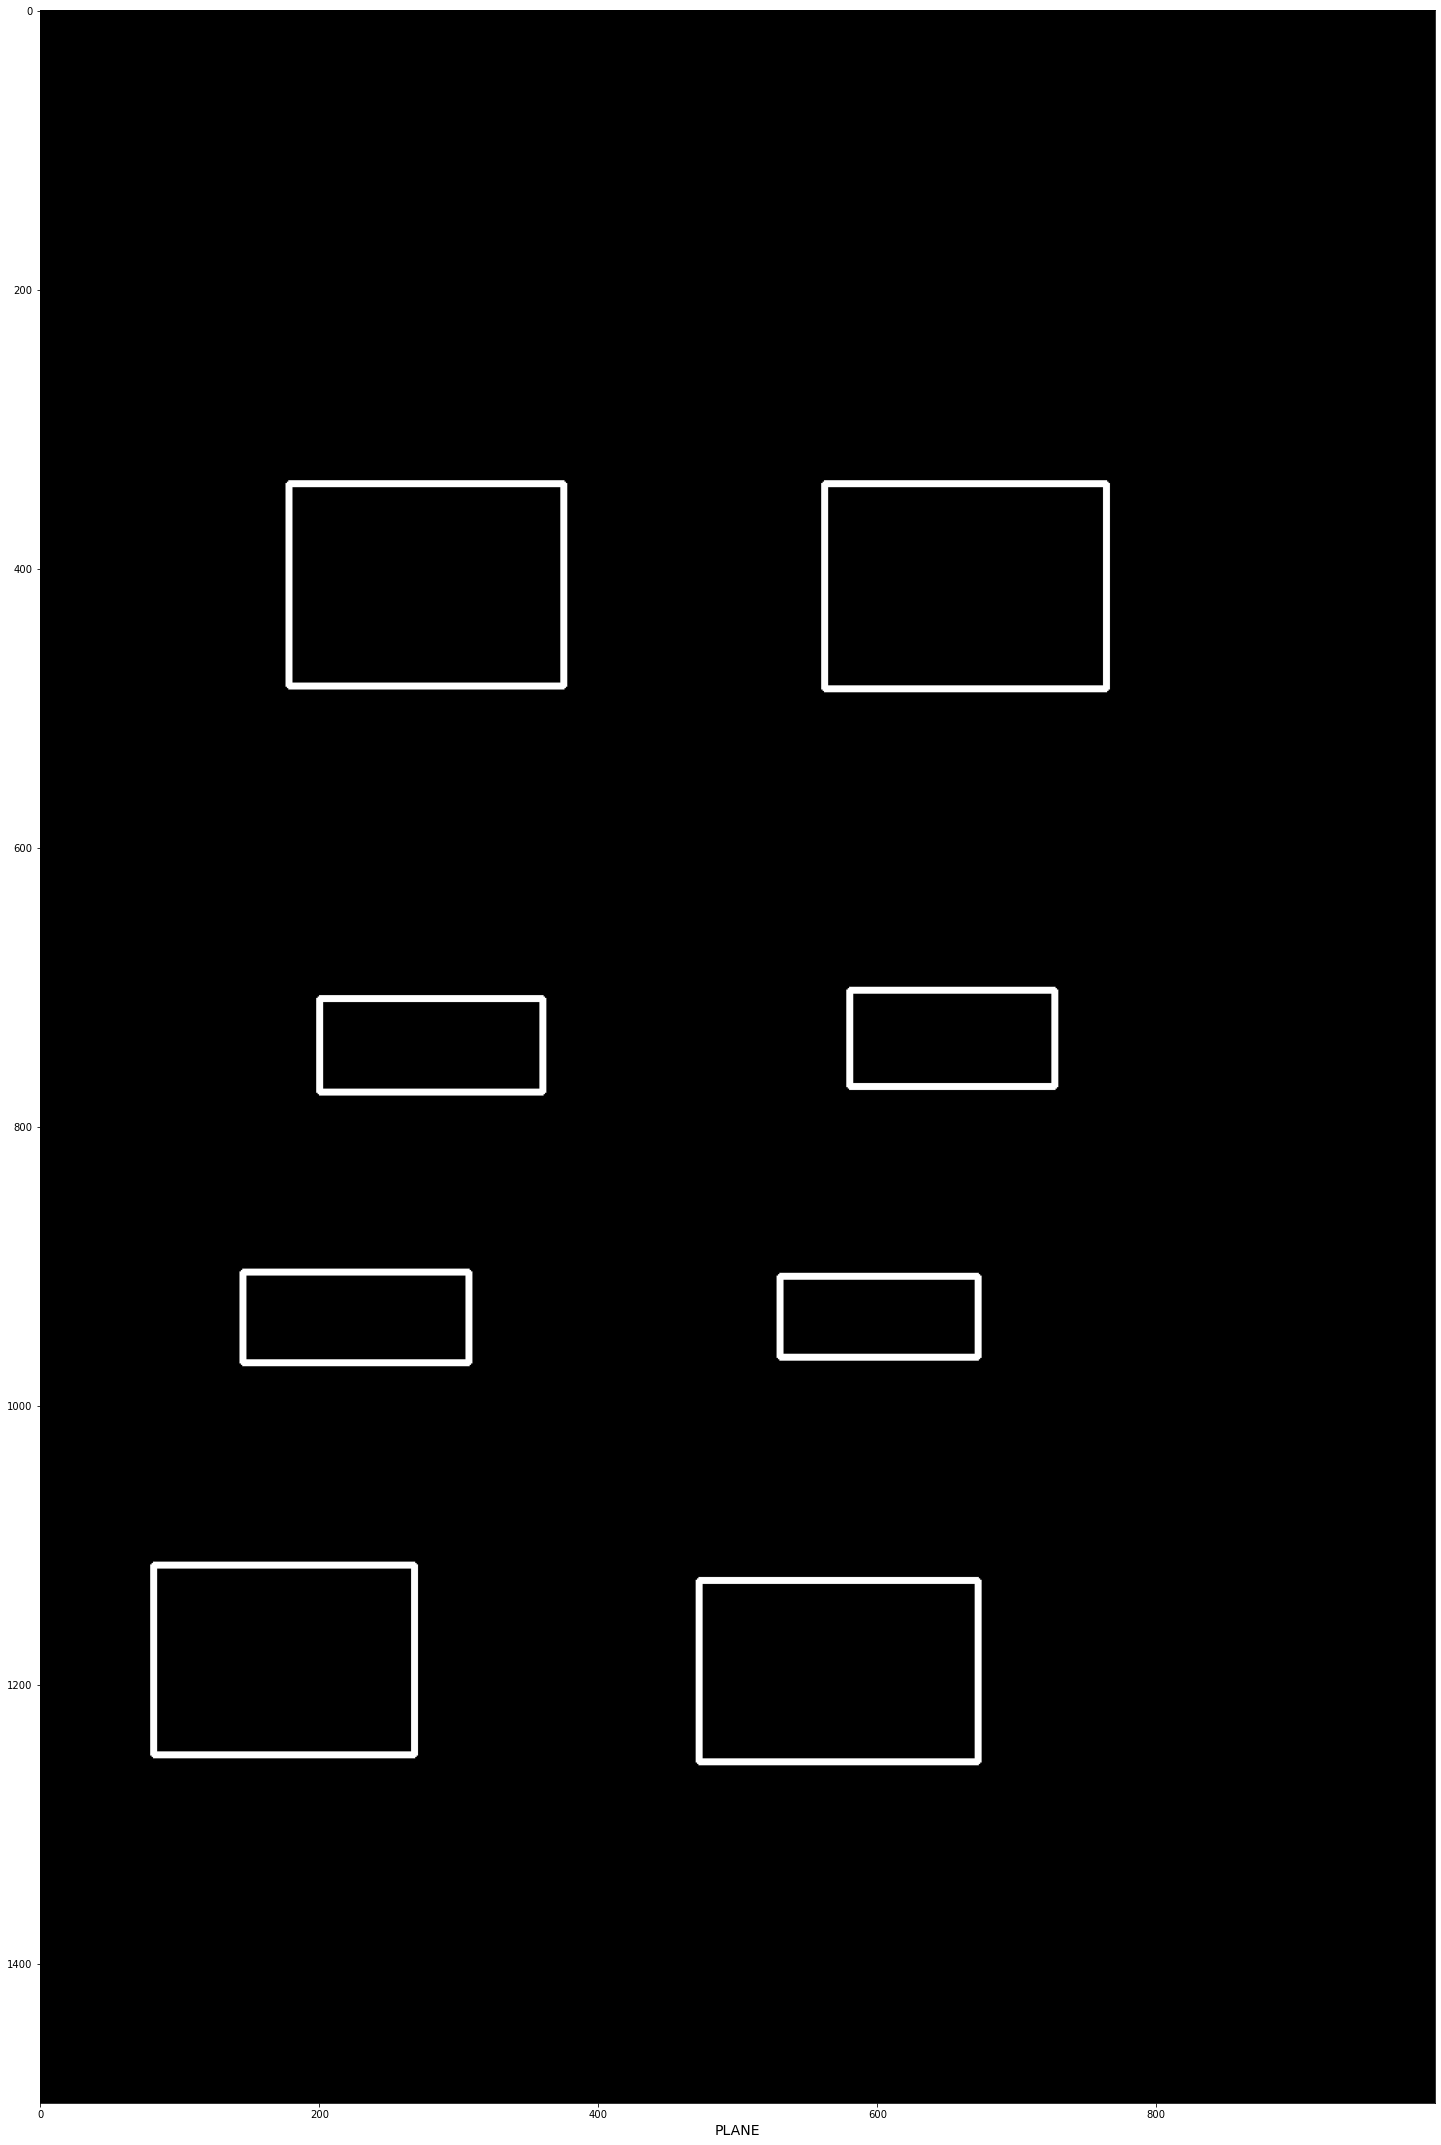

(8, 4)
after NMS: [[ 472 1125  672 1255]
 [  81 1114  268 1250]
 [ 145  904  307  969]
 [ 530  907  672  965]
 [ 200  708  360  775]
 [ 580  702  727  771]
 [ 562  339  764  486]
 [ 178  339  375  484]]
(8, 4)


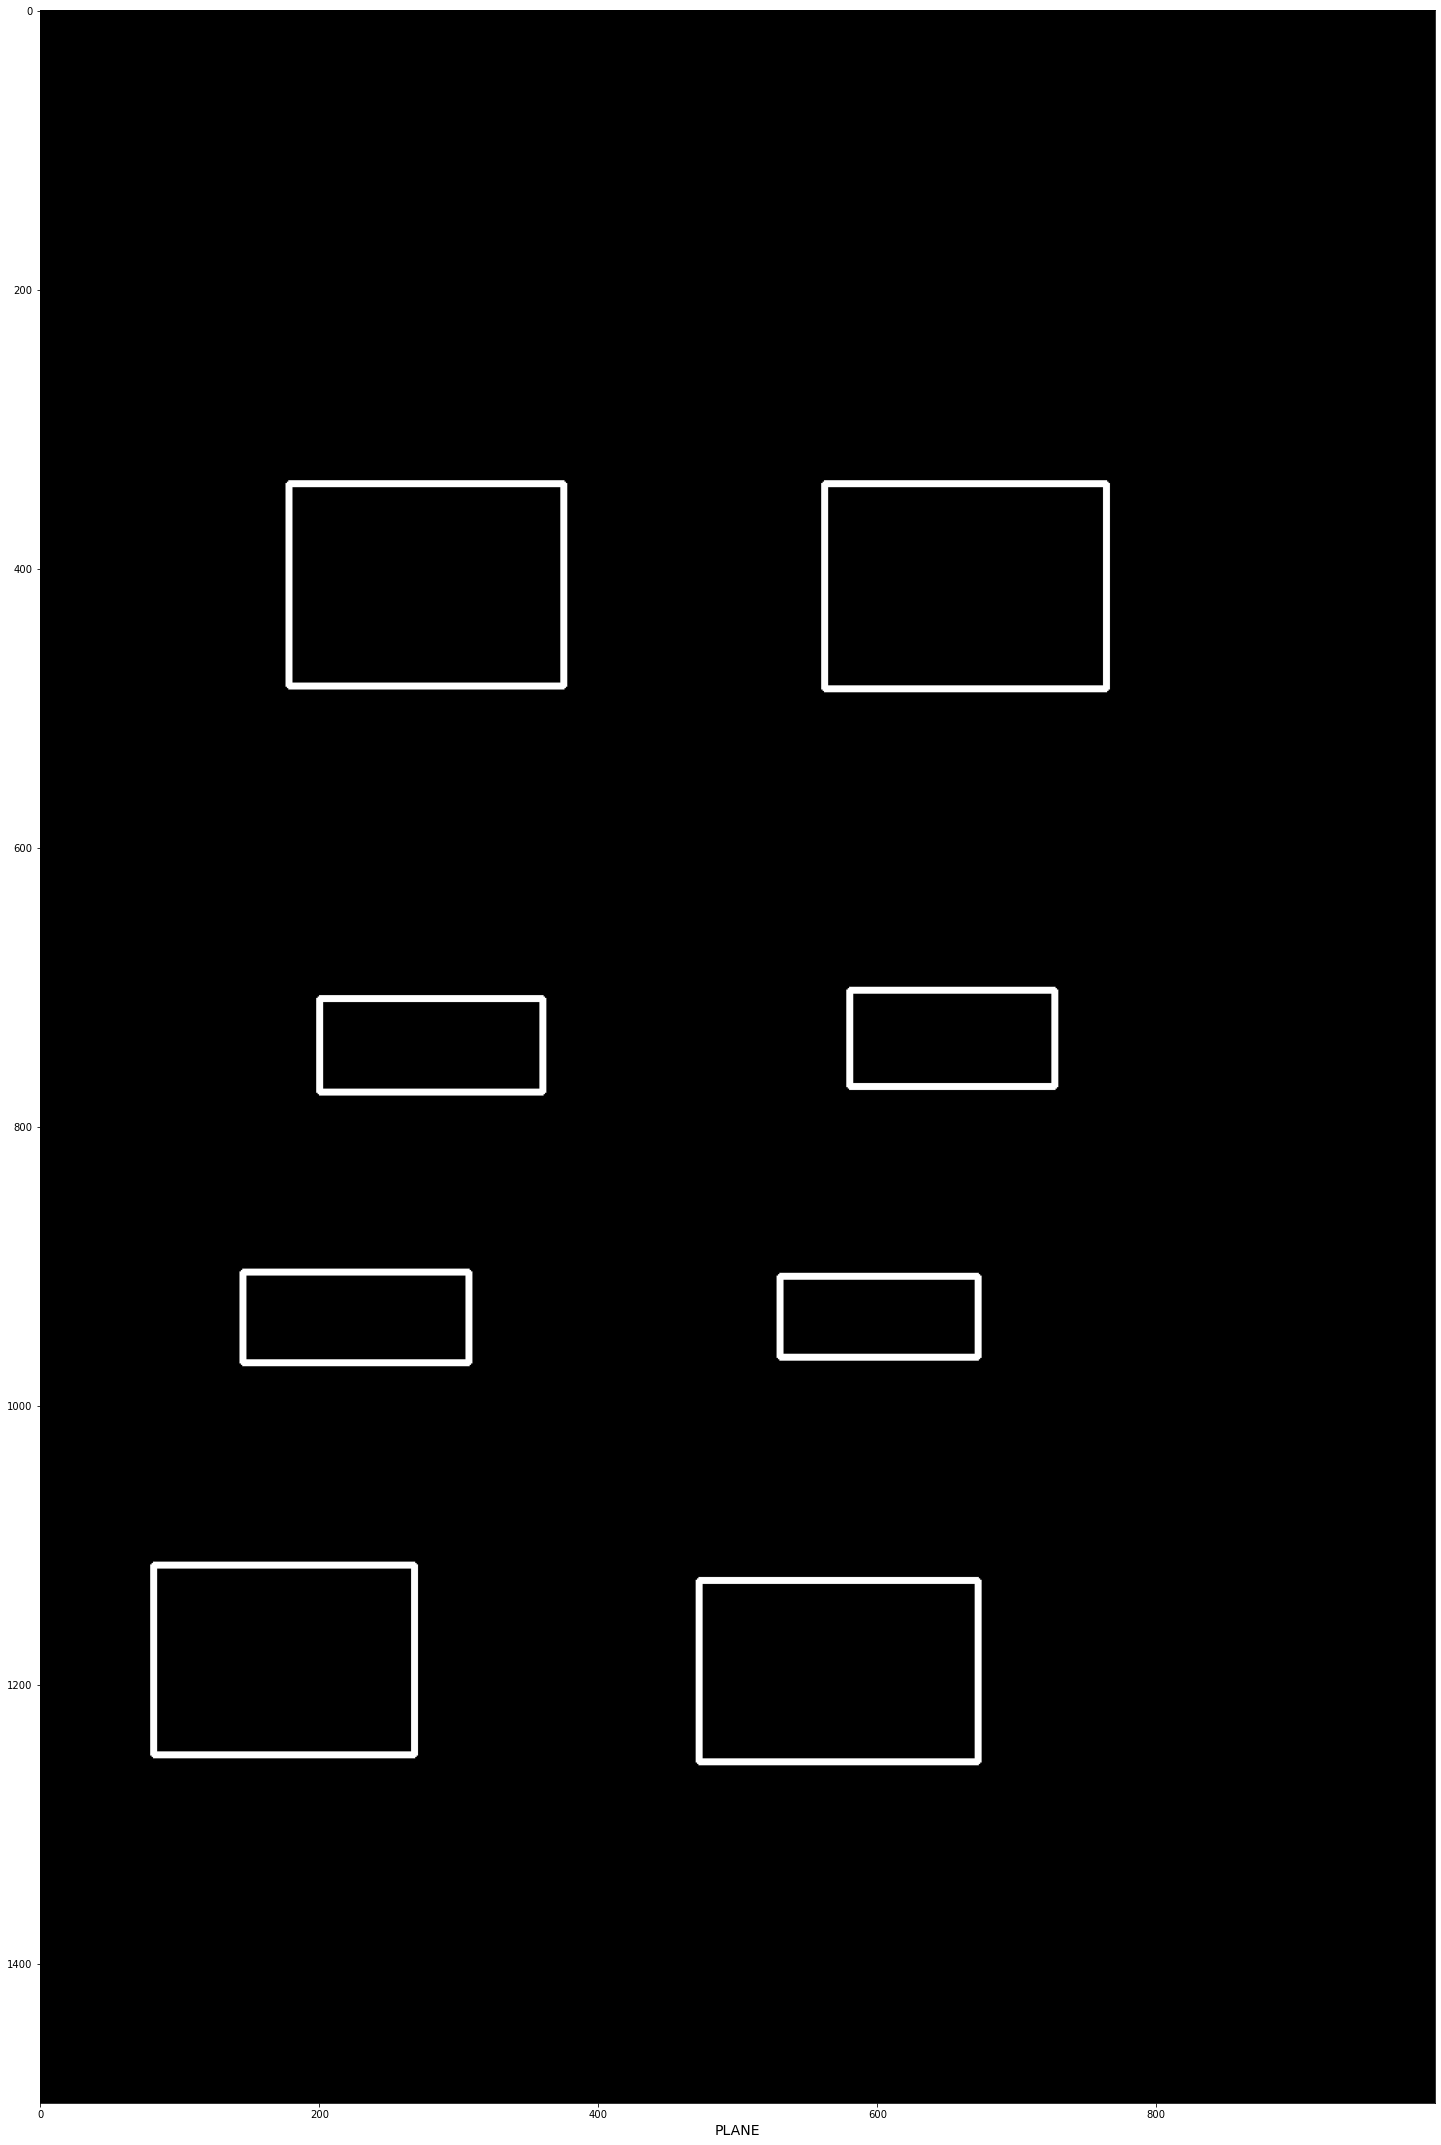

Total no. of windows in seq: 8
yAvg Heights: [ 310.   318.   563.5  564.   758.5  763.5 1087.5 1088.5]
avgStoreyHeights:  [314.0, 563.75, 761.0, 1088.0]
StoreyCount after running post processing module:  4
finallist 20
Total no. of windows in seq: 8
StoreyCount: 4
storeyHeights: [310.0, 563.5, 758.5, 1087.5]
FinalBoxes: [[ 472 1125  672 1255]
 [  81 1114  268 1250]
 [ 145  904  307  969]
 [ 530  907  672  965]
 [ 200  708  360  775]
 [ 580  702  727  771]
 [ 562  339  764  486]
 [ 178  339  375  484]]
FinalBoxes (in list): [array([ 472, 1125,  672, 1255]), array([  81, 1114,  268, 1250]), array([145, 904, 307, 969]), array([530, 907, 672, 965]), array([200, 708, 360, 775]), array([580, 702, 727, 771]), array([562, 339, 764, 486]), array([178, 339, 375, 484])]


In [115]:
## Running Vertical Plane Mapping

## Loading coords from CSV File
FinalList = loadCoordsFromCSV(coordFilePath)

# grab the paths to the input images and initialize our images list

print("[INFO] loading images...")
### OLD DATA
# imagePaths = sorted(list(paths.list_images(imgPath)))
imagePaths = [imgPath + imgName for imgName in imgNames]
# print(imagePaths)

assert len(heights_allImages) == len(imagePaths), "Height Info and ImageSeq does not match. Please provide correct height info for seq"
assert len(FinalList) == len(imagePaths), "Window coords CSV File and ImageSeq does not match."
images = []

# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
    #print(image.shape)
    images.append(image)
    print(imagePath)

windowCount = len(FinalList[0])
print("startWindowCount:", windowCount)
allMappedBoxes = []
## MAIN LOOP ##
for i in range(len(images)):
    img1 = images[i]
    
    # read images and transform them to grayscale
    # Make sure that the train image is the image that will be transformed
    # Opencv defines the color channel in the order BGR 
    # Transform it to RGB to be compatible to matplotlib
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(16,9))
    ax1.imshow(img1, cmap="gray")
    ax1.set_xlabel("img1", fontsize=14)
    plt.show()
    
    ## Preparing Binary Mask and mapping bounding box coordinates
    ## COORDS1 and COORDS2 : WOULD COME FROM TEXT FILEW
    coords1 = FinalList[i]
    print(coords1)
    print(coords1.shape)
    
    # print(np.any(np.isnan(coords1)))
    # print(np.isnan(coords1[0][0][0]))
    # print(math.isnan(coords1[0][0][0]))
    
    ## CHECK NAN Condition if so skip as there are no windows in the img
    if coords1.shape[0] == 1 and np.any(np.isnan(coords1)): 
        print('Skipping as there is no window')
        continue

    coords1 = coords1.astype(int)
    padding = 0

    ## Commented as the coords would come from recorded text File.
    pick1 = mapToPickv1(coords1, padding)
    
    mappedBoxes = mapToVerticalPlane(focalLength,depth,pick1,heights_allImages[i], verticalPlaneCopy, img1,i)
    allMappedBoxes = allMappedBoxes + mappedBoxes
    allMappedBoxes = non_max_suppression_fast(np.array(allMappedBoxes), nmsThresh).tolist()
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlaneCopy, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()
    
## NMS
print("before NMS:", np.array(allMappedBoxes))
plotBoxes(np.copy(verticalPlane), allMappedBoxes)
print(np.array(allMappedBoxes).shape)

finalBoxes = non_max_suppression_fast(np.array(allMappedBoxes), nmsThresh)
#finalBoxes = np.array(finalBoxes)
print("after NMS:", finalBoxes)
print(finalBoxes.shape)

plotBoxes(np.copy(verticalPlane), finalBoxes)
print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
storeyCount, storeyHeights,avgStoreyHeights = calculateStoreys(finalBoxes, heightOfPlane = verticalPlane.shape[0])

len(images)

print('finallist',len(FinalList))

## Final Result of Vertical Plane Mapping Approach 

print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
print("StoreyCount:", storeyCount)
print("storeyHeights:", storeyHeights)

print("FinalBoxes:", finalBoxes)
print("FinalBoxes (in list):", list(finalBoxes))

imu correction <br>
differences bw storey heights across vertical seq of windows <br>
differences bw centres of the windows average (intra sequence) across vertical seqs <br>
differences bw windows of a single vertical set <br>
    Height Differences between storeys of a single vertical sequence <br>
    
averge building height and storey height across all seq for final ans <br>
plot imu height data and all seq height data to compare <br>

In [116]:
# Height Differences between stories of a single vertical sequence
print('Diff in storeyheights:', np.diff(np.array(storeyHeights)))
print('Diff in AvgStoreyHeights:', np.diff(np.array(avgStoreyHeights)))

# apply offset using imu data of the first image captured
# offset is due to the ground ground visibility in the first capture
# --- Assuming the the camera is orthogonal and in level with the window 
# --- (window centre and camera centre coinciding)


offset_building = avgStoreyHeights[0] - heights_allImages[0]

offset_final = offset_building - offset_ramp
print('Offset Final:', offset_final)
storeyHeights_final = avgStoreyHeights - offset_final*(np.array(np.ones(len(avgStoreyHeights))))
print('final storey heights', storeyHeights_final)

print('Height difference between 2 consecutive stories of a single vertical sequence', 
      np.diff(np.array(storeyHeights_final)))

Diff in storeyheights: [253.5 195.  329. ]
Diff in AvgStoreyHeights: [249.75 197.25 327.  ]
Offset Final: 113.0
final storey heights [201.   450.75 648.   975.  ]
Height difference between 2 consecutive stories of a single vertical sequence [249.75 197.25 327.  ]


In [117]:
# imu plot data for this seq
plt.figure()
plt.plot(heights_allImages, label = 'IMU All Image Height Data')
plt.plot(storeyHeights_final, label = 'Storey Heights of a ' + str(storeyCount) + ' storey sequence')
t_line = range(len(heights_allImages))
for i in range(len(storeyHeights_final)):
    plt.plot(t_line, np.repeat(storeyHeights_final[i], len(heights_allImages)),
             label = str(len(storeyHeights_final) - i - 1) + ' storey avg height', 
plt.legend(bbox_to_anchor=(2, 1))
plt.title('Average or Mid heights of stories')
plt.show()

SyntaxError: invalid syntax (<ipython-input-117-66332fbbb3e9>, line 10)

### Testing Pytorch NMS

In [ ]:
from torchvision.ops import nms
import torch
boxes = torch.from_numpy(np.array(allMappedBoxes)).type(torch.float32)
scores = torch.ones(boxes.shape[0], dtype=torch.float32)
print(scores.shape[0])
print(boxes.shape[0])
indices = nms(boxes = boxes, scores = scores, iou_threshold=0)
print(indices)
finalBoxesPytorch =  []

for i in indices:
    finalBoxesPytorch.append(allMappedBoxes[i])

print(finalBoxesPytorch)
print(np.array(finalBoxesPytorch).shape)
plotBoxes(np.copy(verticalPlane), np.array(finalBoxesPytorch))


print("Total no. of windows in seq: " + str(np.array(finalBoxesPytorch).shape[0]))
storeyCountPytorch, storeyHeightsPytorch,avgStoreyHeightsPytorch = calculateStoreys(np.array(finalBoxesPytorch), heightOfPlane = verticalPlane.shape[0])

## Final Result of Vertical Plane Mapping Approach 

print("Total no. of windows in seq: " + str(np.array(finalBoxesPytorch).shape[0]))
print("StoreyCount:", storeyCountPytorch)
print("AvgstoreyHeights:", avgStoreyHeightsPytorch)

print("StoreyHeighDiff", np.diff(np.array(avgStoreyHeightsPytorch)))

def py_cpu_softnms(dets, sc, Nt=0, sigma=0.001, thresh=0.99, method=1):
    """
    py_cpu_softnms
    :param dets:   boexs 坐标矩阵 format [y1, x1, y2, x2]
    :param sc:     每个 boxes 对应的分数
    :param Nt:     iou 交叠门限
    :param sigma:  使用 gaussian 函数的方差
    :param thresh: 最后的分数门限
    :param method: 使用的方法
    :return:       留下的 boxes 的 index
    """

    # indexes concatenate boxes with the last column
    N = dets.shape[0]
    print(N)
    indexes = np.array([np.arange(N)])
    dets = np.concatenate((dets, indexes.T), axis=1)
    
    print('dets:', dets)
    # the order of boxes coordinate is [y1,x1,y2,x2]
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = sc
    print(sc.shape)
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    print('scores init before loop:', scores)

    for i in range(N):
        print('scores init in loop:', scores)
    # intermediate parameters for later parameters exchange
        tBD = dets[i, :].copy()
        tscore = scores[i].copy()
        tarea = areas[i].copy()
        pos = i + 1

        #
        if i != N-1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0
        if tscore < maxscore:
            dets[i, :] = dets[maxpos + i + 1, :]
            dets[maxpos + i + 1, :] = tBD
            tBD = dets[i, :]

            scores[i] = scores[maxpos + i + 1]
            scores[maxpos + i + 1] = tscore
            tscore = scores[i]

            areas[i] = areas[maxpos + i + 1]
            areas[maxpos + i + 1] = tarea
            tarea = areas[i]

        # IoU calculate
        xx1 = np.maximum(dets[i, 0], dets[pos:, 0])
        yy1 = np.maximum(dets[i, 1], dets[pos:, 1])
        xx2 = np.minimum(dets[i, 2], dets[pos:, 2])
        yy2 = np.minimum(dets[i, 3], dets[pos:, 3])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[pos:] - inter)

        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = weight[ovr > Nt] - ovr[ovr > Nt]
        elif method == 2:  # gaussian
            weight = np.exp(-(ovr * ovr) / sigma)
        else:  # original NMS
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = 0
        print('ovr:', ovr)
        print('weight:', weight)
        print('scores in loop:', scores)
        scores[pos:] = weight * scores[pos:]
    
    print('scores:', scores)
    # select the boxes and keep the corresponding indexes
    inds = dets[:, 4][scores > thresh]
    keep = inds.astype(int)

    return keep

scores = torch.ones(boxes.shape[0], dtype=torch.float32)
print('scoreShape:', scores.shape[0])
print('scores:', scores)
indices = py_cpu_softnms(boxes.numpy(), scores.numpy(), method = 2)
print(indices.shape)
print(indices)

finalBoxesSoftNMS = []
for i in indices:
    finalBoxesSoftNMS.append(allMappedBoxes[i])

print(finalBoxesSoftNMS)
print(np.array(finalBoxesSoftNMS).shape)
plotBoxes(np.copy(verticalPlane), np.array(finalBoxesSoftNMS))


print("Total no. of windows in seq: " + str(np.array(finalBoxesSoftNMS).shape[0]))
storeyCountSoftNMS, storeyHeightsSoftNMS,avgStoreyHeightsSoftNMS = calculateStoreys(np.array(finalBoxesSoftNMS), heightOfPlane = verticalPlane.shape[0])

## Final Result of Vertical Plane Mapping Approach 

print("Total no. of windows in seq: " + str(np.array(finalBoxesSoftNMS).shape[0]))
print("StoreyCount:", storeyCountSoftNMS)
print("AvgstoreyHeights:", avgStoreyHeightsSoftNMS)

print("StoreyHeighDiff", np.diff(np.array(avgStoreyHeightsSoftNMS)))